# Black Carbon Analysis: FTIR EC/OC and HIPS Fabs Data Integration (Refactored)
 
This notebook analyzes the relationship between FTIR-based carbon measurements (EC, OC)
and HIPS-based light absorption measurements (Fabs) from the SPARTAN database.
**Refactored version to eliminate redundant analyses and streamline the workflow.**

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


=============================================================================
CONFIGURATION AND DATA LOADING
=============================================================================

In [59]:
# Configuration parameters
DB_PATH = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/Combined Database/spartan_ftir_hips.db"
SITE_OF_INTEREST = "ETAD"

def load_data_from_db(db_path, site_code):
    """Load and validate data from SQLite database for a specific site."""
    try:
        conn = sqlite3.connect(db_path)
        
        # Check if site exists
        site_query = "SELECT DISTINCT site_code FROM filters WHERE site_code = ?"
        site_exists = pd.read_sql_query(site_query, conn, params=(site_code,))
        
        if len(site_exists) == 0:
            print(f"Site '{site_code}' not found in database. Available sites:")
            all_sites = pd.read_sql_query("SELECT DISTINCT site_code FROM filters", conn)
            print(", ".join(all_sites['site_code'].tolist()))
            conn.close()
            return pd.DataFrame()
        
        # Main query
        query = """
        SELECT 
            f.filter_id, f.sample_date, f.site_code, m.volume_m3,
            m.ec_ftir, m.ec_ftir_mdl, m.oc_ftir, m.oc_ftir_mdl,
            m.fabs, m.fabs_mdl, m.fabs_uncertainty, m.ftir_batch_id
        FROM filters f
        JOIN ftir_sample_measurements m USING(filter_id)
        WHERE f.site_code = ? AND
              m.ec_ftir IS NOT NULL AND
              m.oc_ftir IS NOT NULL AND
              m.fabs IS NOT NULL
        ORDER BY f.sample_date
        """
        
        df = pd.read_sql_query(query, conn, params=(site_code,))
        df['sample_date'] = pd.to_datetime(df['sample_date'])
        conn.close()
        
        print(f"Loaded {len(df)} samples for site {site_code} with both FTIR and HIPS measurements")
        print(f"Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
        
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

# Load the data
data = load_data_from_db(DB_PATH, SITE_OF_INTEREST)


Loaded 162 samples for site ETAD with both FTIR and HIPS measurements
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00


=============================================================================
DATA PREPROCESSING AND QUALITY CONTROL
=============================================================================

In [60]:
def preprocess_data(df, site_code):
    """Complete data preprocessing pipeline."""
    
    print(f"\n===== {site_code} Data Overview =====")
    print(f"Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
    print(f"Number of samples: {len(df)}")
    
    print("\n===== Missing Values =====")
    print(df.isnull().sum())
    
    print("\n===== Basic Statistics =====")
    stats = df[['ec_ftir', 'oc_ftir', 'fabs']].describe()
    print(stats)
    
    # Check for values below MDL
    below_mdl = {
        'EC': (df['ec_ftir'] < df['ec_ftir_mdl']).mean() * 100,
        'OC': (df['oc_ftir'] < df['oc_ftir_mdl']).mean() * 100,
        'Fabs': (df['fabs'] < df['fabs_mdl']).mean() * 100
    }
    print(f"\n===== Values Below MDL =====")
    for key, value in below_mdl.items():
        print(f"{key}: {value:.1f}% below MDL")
    
    # Handle values below MDL (conservative approach: replace with MDL/2)
    df_processed = df.copy()
    for col, mdl_col in [('ec_ftir', 'ec_ftir_mdl'), ('oc_ftir', 'oc_ftir_mdl'), ('fabs', 'fabs_mdl')]:
        mask_below_mdl = df_processed[col] < df_processed[mdl_col]
        below_count = mask_below_mdl.sum()
        if below_count > 0:
            df_processed.loc[mask_below_mdl, col] = df_processed.loc[mask_below_mdl, mdl_col] / 2
            print(f"Replaced {below_count} values below MDL in {col} with MDL/2")
    
    # Calculate derived metrics
    df_processed['oc_ec_ratio'] = df_processed['oc_ftir'] / df_processed['ec_ftir']
    df_processed['mac'] = df_processed['fabs'] / df_processed['ec_ftir']
    df_processed['month'] = df_processed['sample_date'].dt.month
    
    # Ethiopian season mapping
    def map_ethiopian_seasons(month):
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:
            return 'Kiremt Rainy Season'
    
    df_processed['season'] = df_processed['month'].apply(map_ethiopian_seasons)
    
    # Clean extreme values
    df_clean = df_processed[
        (df_processed['mac'] < 50) & 
        (df_processed['oc_ec_ratio'] < 20)
    ]
    
    if len(df_clean) < len(df_processed):
        print(f"Removed {len(df_processed) - len(df_clean)} samples with extreme values")
    
    return df_clean

# Preprocess the data
data_processed = preprocess_data(data, SITE_OF_INTEREST)


===== ETAD Data Overview =====
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
Number of samples: 162

===== Missing Values =====
filter_id           0
sample_date         0
site_code           0
volume_m3           0
ec_ftir             0
ec_ftir_mdl         0
oc_ftir             0
oc_ftir_mdl         0
fabs                0
fabs_mdl            0
fabs_uncertainty    0
ftir_batch_id       0
dtype: int64

===== Basic Statistics =====
          ec_ftir     oc_ftir        fabs
count  162.000000  162.000000  162.000000
mean     4.663528    6.281690   47.258976
std      2.034262    2.849580    9.739997
min      0.693115    0.617765   28.085699
25%      3.046502    4.232311   40.238902
50%      4.049773    5.530220   45.859240
75%      6.009214    7.416377   52.977287
max     10.533354   15.332336   74.191711

===== Values Below MDL =====
EC: 0.0% below MDL
OC: 0.6% below MDL
Fabs: 0.0% below MDL
Replaced 1 values below MDL in oc_ftir with MDL/2
Removed 1 samples with extreme values


=============================================================================
COMPREHENSIVE MAC METHOD COMPARISON (SINGLE DEFINITIVE ANALYSIS)
=============================================================================



COMPREHENSIVE MAC METHOD COMPARISON FOR ETAD

📊 MAC VALUES CALCULATED:
Method 1 (Mean of Ratios):     11.15 m²/g
Method 2 (Ratio of Means):     10.09 m²/g
Method 3 (Regression):         4.20 m²/g
Method 4 (Regression, y=0):    9.18 m²/g

📈 BC EQUIVALENT MEANS:
Method 1: 4.24 ± 0.87 μg/m³
Method 2: 4.69 ± 0.97 μg/m³
Method 3: 11.27 ± 2.32 μg/m³
Method 4: 5.16 ± 1.06 μg/m³
FTIR EC:  4.69 ± 2.02 μg/m³


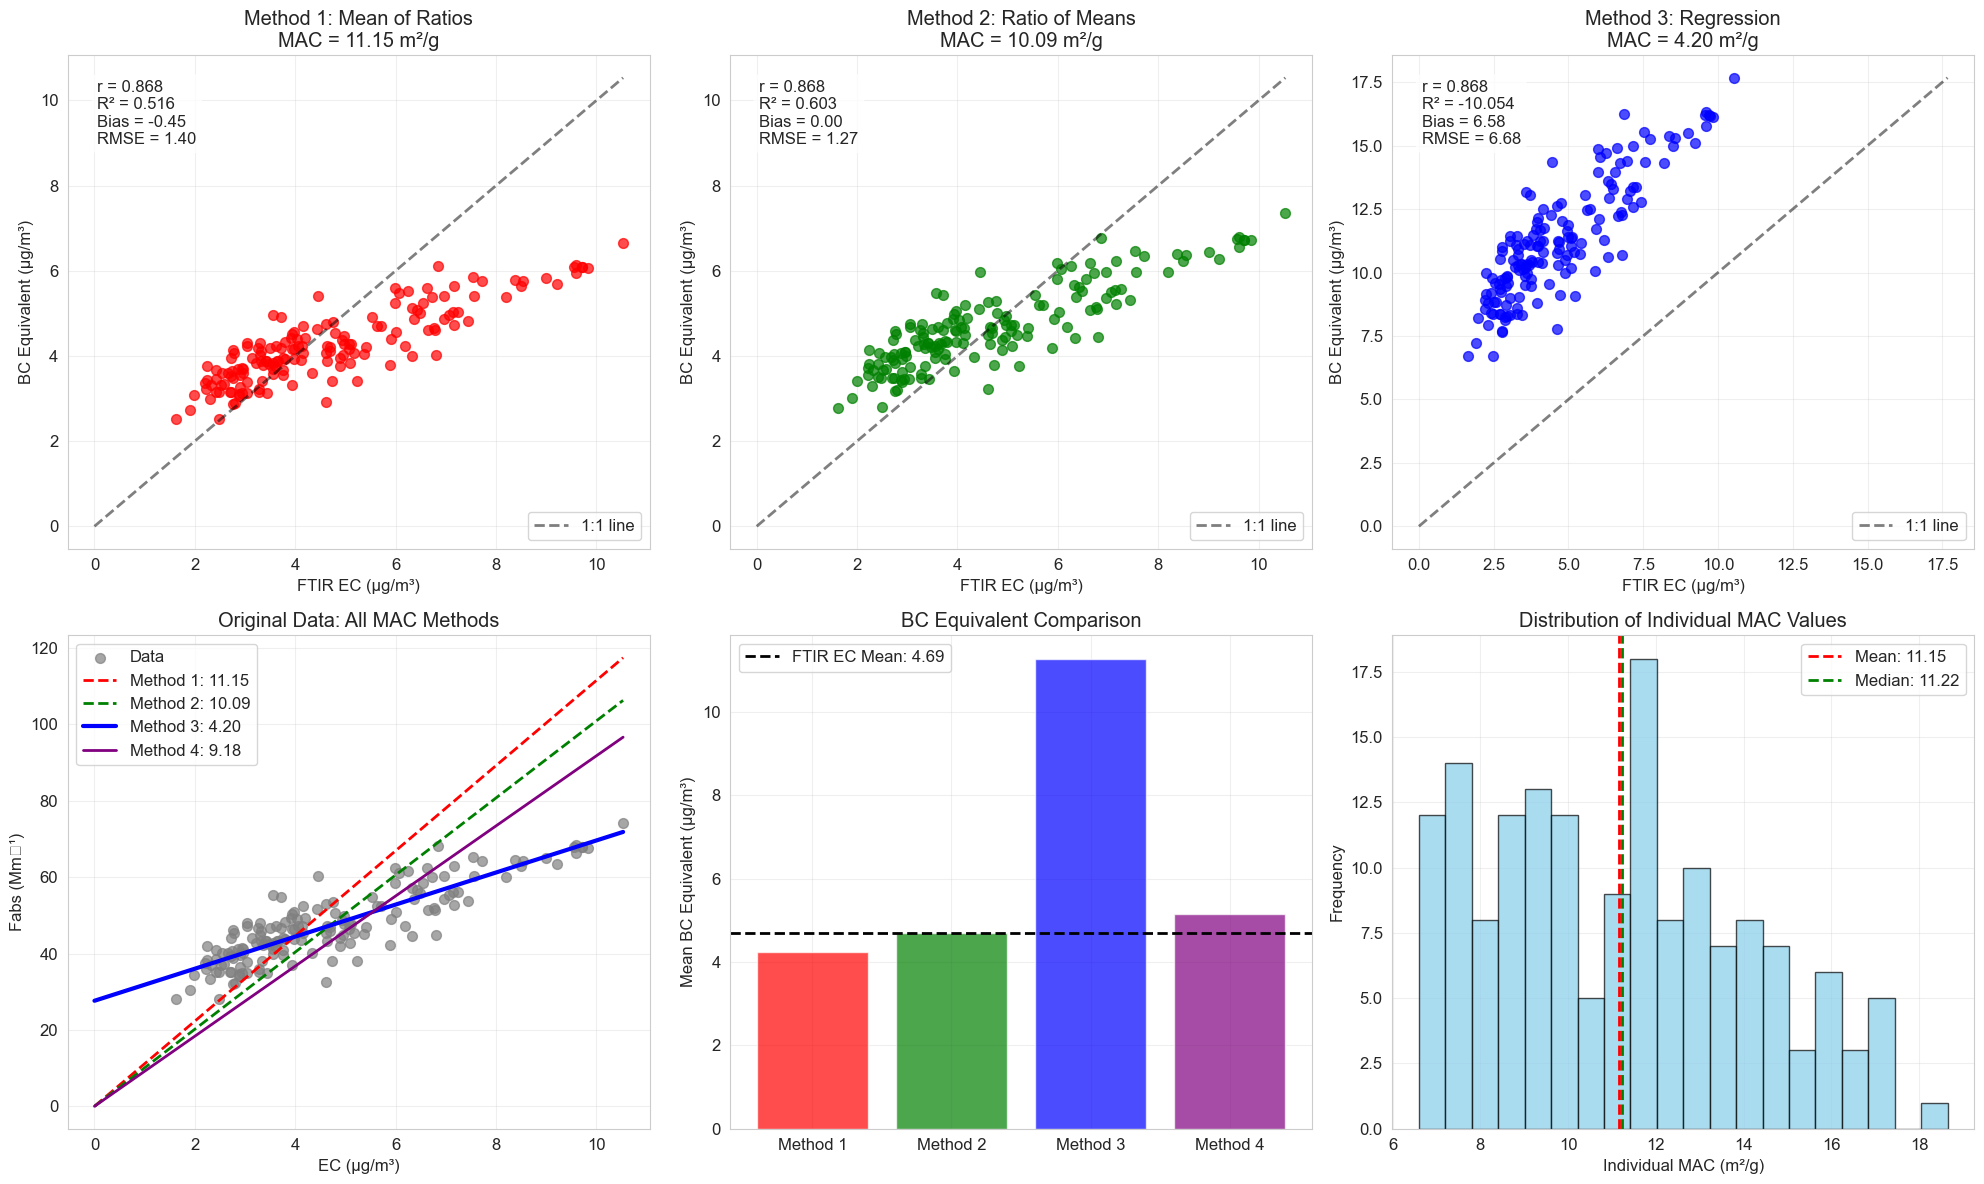


🏆 ENHANCED PERFORMANCE ANALYSIS:
Method                    r        R²       Bias     Rel.Bias%  RMSE     MAE     
Method 1 (Mean Ratios)    0.868    0.516    -0.45    -9.5       1.40     1.06    
Method 2 (Ratio Means)    0.868    0.603    0.00     0.0        1.27     1.05    
Method 3 (Regression)     0.868    -10.054  6.58     140.4      6.68     6.58    
Method 4 (Reg y=0)        0.868    0.583    0.47     10.0       1.30     1.13    

🥇 FINAL RANKING (Best to Worst):
1. Method 2 (Ratio Means)
   MAC = 10.09 m²/g
   Performance: r = 0.868, R² = 0.603, bias = 0.00, RMSE = 1.27
   Composite Score: 0.691 (lower = better)
   ✅ RECOMMENDED for BC equivalent calculations

2. Method 4 (Reg y=0)
   MAC = 9.18 m²/g
   Performance: r = 0.868, R² = 0.583, bias = 0.47, RMSE = 1.30
   Composite Score: 0.855 (lower = better)

3. Method 1 (Mean Ratios)
   MAC = 11.15 m²/g
   Performance: r = 0.868, R² = 0.516, bias = -0.45, RMSE = 1.40
   Composite Score: 0.896 (lower = better)

4. Method 3 (Reg

In [61]:
# %%
def comprehensive_mac_analysis(df, site_code):
    """
    Single comprehensive MAC analysis that compares all methods and provides definitive recommendations.
    This replaces all the redundant MAC comparisons in the original notebook.
    """
    
    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE MAC METHOD COMPARISON FOR {site_code}")
    print(f"{'='*80}")
    
    # =============================================================================
    # STEP 1: Calculate all MAC values
    # =============================================================================
    
    # Individual MAC ratios for analysis
    individual_mac = df['fabs'] / df['ec_ftir']
    
    # Method 1: Mean of Individual Ratios
    mac_method1 = individual_mac.mean()
    
    # Method 2: Ratio of Means
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    # Method 3: Regression with intercept
    slope, intercept = np.polyfit(df['ec_ftir'], df['fabs'], 1)
    mac_method3 = slope
    
    # Method 4: Regression through origin
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(df[['ec_ftir']], df['fabs'])
    mac_method4 = reg_origin.coef_[0]
    
    print(f"\n📊 MAC VALUES CALCULATED:")
    print(f"Method 1 (Mean of Ratios):     {mac_method1:.2f} m²/g")
    print(f"Method 2 (Ratio of Means):     {mac_method2:.2f} m²/g")
    print(f"Method 3 (Regression):         {mac_method3:.2f} m²/g")
    print(f"Method 4 (Regression, y=0):    {mac_method4:.2f} m²/g")
    
    # =============================================================================
    # STEP 2: Calculate BC equivalents and performance metrics
    # =============================================================================
    
    bc_method1 = df['fabs'] / mac_method1
    bc_method2 = df['fabs'] / mac_method2
    bc_method3 = df['fabs'] / mac_method3
    bc_method4 = df['fabs'] / mac_method4
    
    print(f"\n📈 BC EQUIVALENT MEANS:")
    print(f"Method 1: {bc_method1.mean():.2f} ± {bc_method1.std():.2f} μg/m³")
    print(f"Method 2: {bc_method2.mean():.2f} ± {bc_method2.std():.2f} μg/m³")
    print(f"Method 3: {bc_method3.mean():.2f} ± {bc_method3.std():.2f} μg/m³")
    print(f"Method 4: {bc_method4.mean():.2f} ± {bc_method4.std():.2f} μg/m³")
    print(f"FTIR EC:  {df['ec_ftir'].mean():.2f} ± {df['ec_ftir'].std():.2f} μg/m³")
    
    # Performance metrics calculation (ENHANCED VERSION)
    def calculate_performance_metrics(bc_equiv, ftir_ec):
        """Calculate comprehensive performance metrics including both r and R²."""
        
        # Correlation analysis
        correlation, p_value = stats.pearsonr(bc_equiv, ftir_ec)
        
        # R² calculation (coefficient of determination)
        r_squared = r2_score(ftir_ec, bc_equiv)
        
        # Other metrics
        bias = (bc_equiv - ftir_ec).mean()
        rmse = np.sqrt(mean_squared_error(ftir_ec, bc_equiv))
        mae = mean_absolute_error(ftir_ec, bc_equiv)
        
        # Relative metrics
        relative_bias = bias / ftir_ec.mean() * 100  # Percentage bias
        
        return {
            'correlation': correlation, 
            'r_squared': r_squared,
            'bias': bias, 
            'relative_bias': relative_bias,
            'rmse': rmse,
            'mae': mae,
            'p_value': p_value
        }
    
    metrics = {}
    for i, bc_data in enumerate([bc_method1, bc_method2, bc_method3, bc_method4], 1):
        metrics[f'method{i}'] = calculate_performance_metrics(bc_data, df['ec_ftir'])
    
    # =============================================================================
    # STEP 3: Create comprehensive visualization (UPDATED WITH R²)
    # =============================================================================
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Scatter plots for each method
    methods_data = [
        ('Method 1: Mean of Ratios', bc_method1, metrics['method1'], 'red', mac_method1),
        ('Method 2: Ratio of Means', bc_method2, metrics['method2'], 'green', mac_method2),
        ('Method 3: Regression', bc_method3, metrics['method3'], 'blue', mac_method3)
    ]
    
    for i, (title, bc_data, perf_metrics, color, mac_val) in enumerate(methods_data):
        ax = axes[0, i]
        ax.scatter(df['ec_ftir'], bc_data, alpha=0.7, s=50, color=color)
        
        # 1:1 line
        max_val = max(df['ec_ftir'].max(), bc_data.max())
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2, label='1:1 line')
        
        ax.set_xlabel('FTIR EC (μg/m³)')
        ax.set_ylabel('BC Equivalent (μg/m³)')
        ax.set_title(f'{title}\nMAC = {mac_val:.2f} m²/g')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # UPDATED: Include R² in the text box
        ax.text(0.05, 0.95, 
                f'r = {perf_metrics["correlation"]:.3f}\n'
                f'R² = {perf_metrics["r_squared"]:.3f}\n'
                f'Bias = {perf_metrics["bias"]:.2f}\n'
                f'RMSE = {perf_metrics["rmse"]:.2f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Original data with all regression lines
    ax_orig = axes[1, 0]
    ax_orig.scatter(df['ec_ftir'], df['fabs'], alpha=0.7, s=50, color='gray', label='Data')
    
    x_line = np.linspace(0, df['ec_ftir'].max(), 100)
    ax_orig.plot(x_line, mac_method1 * x_line, '--', color='red', lw=2, label=f'Method 1: {mac_method1:.2f}')
    ax_orig.plot(x_line, mac_method2 * x_line, '--', color='green', lw=2, label=f'Method 2: {mac_method2:.2f}')
    ax_orig.plot(x_line, slope * x_line + intercept, '-', color='blue', lw=3, label=f'Method 3: {slope:.2f}')
    ax_orig.plot(x_line, mac_method4 * x_line, '-', color='purple', lw=2, label=f'Method 4: {mac_method4:.2f}')
    
    ax_orig.set_xlabel('EC (μg/m³)')
    ax_orig.set_ylabel('Fabs (Mm⁻¹)')
    ax_orig.set_title('Original Data: All MAC Methods')
    ax_orig.legend()
    ax_orig.grid(True, alpha=0.3)
    
    # Performance comparison
    ax_perf = axes[1, 1]
    methods_names = ['Method 1', 'Method 2', 'Method 3', 'Method 4']
    bc_means_all = [bc_method1.mean(), bc_method2.mean(), bc_method3.mean(), bc_method4.mean()]
    colors_all = ['red', 'green', 'blue', 'purple']
    
    bars = ax_perf.bar(methods_names, bc_means_all, color=colors_all, alpha=0.7)
    ax_perf.axhline(df['ec_ftir'].mean(), color='black', linestyle='--', linewidth=2,
                    label=f'FTIR EC Mean: {df["ec_ftir"].mean():.2f}')
    ax_perf.set_ylabel('Mean BC Equivalent (μg/m³)')
    ax_perf.set_title('BC Equivalent Comparison')
    ax_perf.legend()
    ax_perf.grid(True, alpha=0.3)
    
    # Individual MAC distribution analysis
    ax_dist = axes[1, 2]
    ax_dist.hist(individual_mac, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax_dist.axvline(mac_method1, color='red', linestyle='--', linewidth=2, label=f'Mean: {mac_method1:.2f}')
    ax_dist.axvline(individual_mac.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {individual_mac.median():.2f}')
    ax_dist.set_xlabel('Individual MAC (m²/g)')
    ax_dist.set_ylabel('Frequency')
    ax_dist.set_title('Distribution of Individual MAC Values')
    ax_dist.legend()
    ax_dist.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # STEP 4: Final ranking and recommendation (ENHANCED TABLE)
    # =============================================================================
    
    # Build the all_methods list for enhanced analysis
    all_methods = [
        ('Method 1 (Mean Ratios)', metrics['method1'], mac_method1),
        ('Method 2 (Ratio Means)', metrics['method2'], mac_method2),
        ('Method 3 (Regression)', metrics['method3'], mac_method3),
        ('Method 4 (Reg y=0)', metrics['method4'], mac_method4)
    ]
    
    # ENHANCED PERFORMANCE TABLE
    print(f"\n🏆 ENHANCED PERFORMANCE ANALYSIS:")
    print(f"{'Method':<25} {'r':<8} {'R²':<8} {'Bias':<8} {'Rel.Bias%':<10} {'RMSE':<8} {'MAE':<8}")
    print(f"{'='*85}")
    
    for method_name, perf_metrics, mac_val in all_methods:
        print(f"{method_name:<25} "
              f"{perf_metrics['correlation']:<8.3f} "
              f"{perf_metrics['r_squared']:<8.3f} "
              f"{perf_metrics['bias']:<8.2f} "
              f"{perf_metrics['relative_bias']:<10.1f} "
              f"{perf_metrics['rmse']:<8.2f} "
              f"{perf_metrics['mae']:<8.2f}")
    
    # Composite scoring and ranking (UPDATED TO USE R²)
    def composite_score(perf_metrics):
        """
        Composite score using multiple metrics.
        Lower score = better performance
        """
        return (0.4 * perf_metrics['rmse'] + 
                0.3 * abs(perf_metrics['bias']) + 
                0.2 * (1 - perf_metrics['r_squared']) +  # Using R² instead of correlation
                0.1 * perf_metrics['mae'])
    
    scored_methods = [
        (name, mac_val, composite_score(perf_metrics), perf_metrics)
        for name, perf_metrics, mac_val in all_methods
    ]
    scored_methods.sort(key=lambda x: x[2])  # Sort by composite score
    
    print(f"\n🥇 FINAL RANKING (Best to Worst):")
    print(f"{'='*70}")
    
    for i, (method, mac, score, perf) in enumerate(scored_methods, 1):
        print(f"{i}. {method}")
        print(f"   MAC = {mac:.2f} m²/g")
        print(f"   Performance: r = {perf['correlation']:.3f}, R² = {perf['r_squared']:.3f}, bias = {perf['bias']:.2f}, RMSE = {perf['rmse']:.2f}")
        print(f"   Composite Score: {score:.3f} (lower = better)")
        
        if i == 1:
            print(f"   ✅ RECOMMENDED for BC equivalent calculations")
            recommended_method = method
            recommended_mac = mac
            recommended_metrics = perf
        print()
    
    # Final recommendation summary
    print(f"\n{'🎯 FINAL RECOMMENDATION':^70}")
    print(f"{'='*70}")
    print(f"USE {recommended_method.upper()}: MAC = {recommended_mac:.2f} m²/g")
    print(f"\n✅ Why this method is best:")
    print(f"   • Correlation with FTIR EC: r = {recommended_metrics['correlation']:.3f}")
    print(f"   • Variance explained: R² = {recommended_metrics['r_squared']:.3f} ({recommended_metrics['r_squared']*100:.1f}%)")
    print(f"   • Bias: {recommended_metrics['bias']:.2f} μg/m³")
    print(f"   • RMSE: {recommended_metrics['rmse']:.2f} μg/m³")
    
    print(f"\n📋 Practical Implementation:")
    print(f"   BC_equivalent = Fabs / {recommended_mac:.2f}  # in m²/g")
    print(f"   Example: For Fabs = 45 Mm⁻¹ → BC = {45/recommended_mac:.2f} μg/m³")
    
    return {
        'recommended_method': recommended_method,
        'recommended_mac': recommended_mac,
        'all_methods': scored_methods,  # Return scored_methods for use in summary
        'detailed_metrics': all_methods,  # Return detailed metrics for summary function
        'individual_mac_stats': {
            'mean': mac_method1,
            'median': individual_mac.median(),
            'std': individual_mac.std(),
            'min': individual_mac.min(),
            'max': individual_mac.max()
        }
    }

mac_results = comprehensive_mac_analysis(data_processed, SITE_OF_INTEREST)


=============================================================================
SUPPORTING ANALYSES (STREAMLINED)
=============================================================================

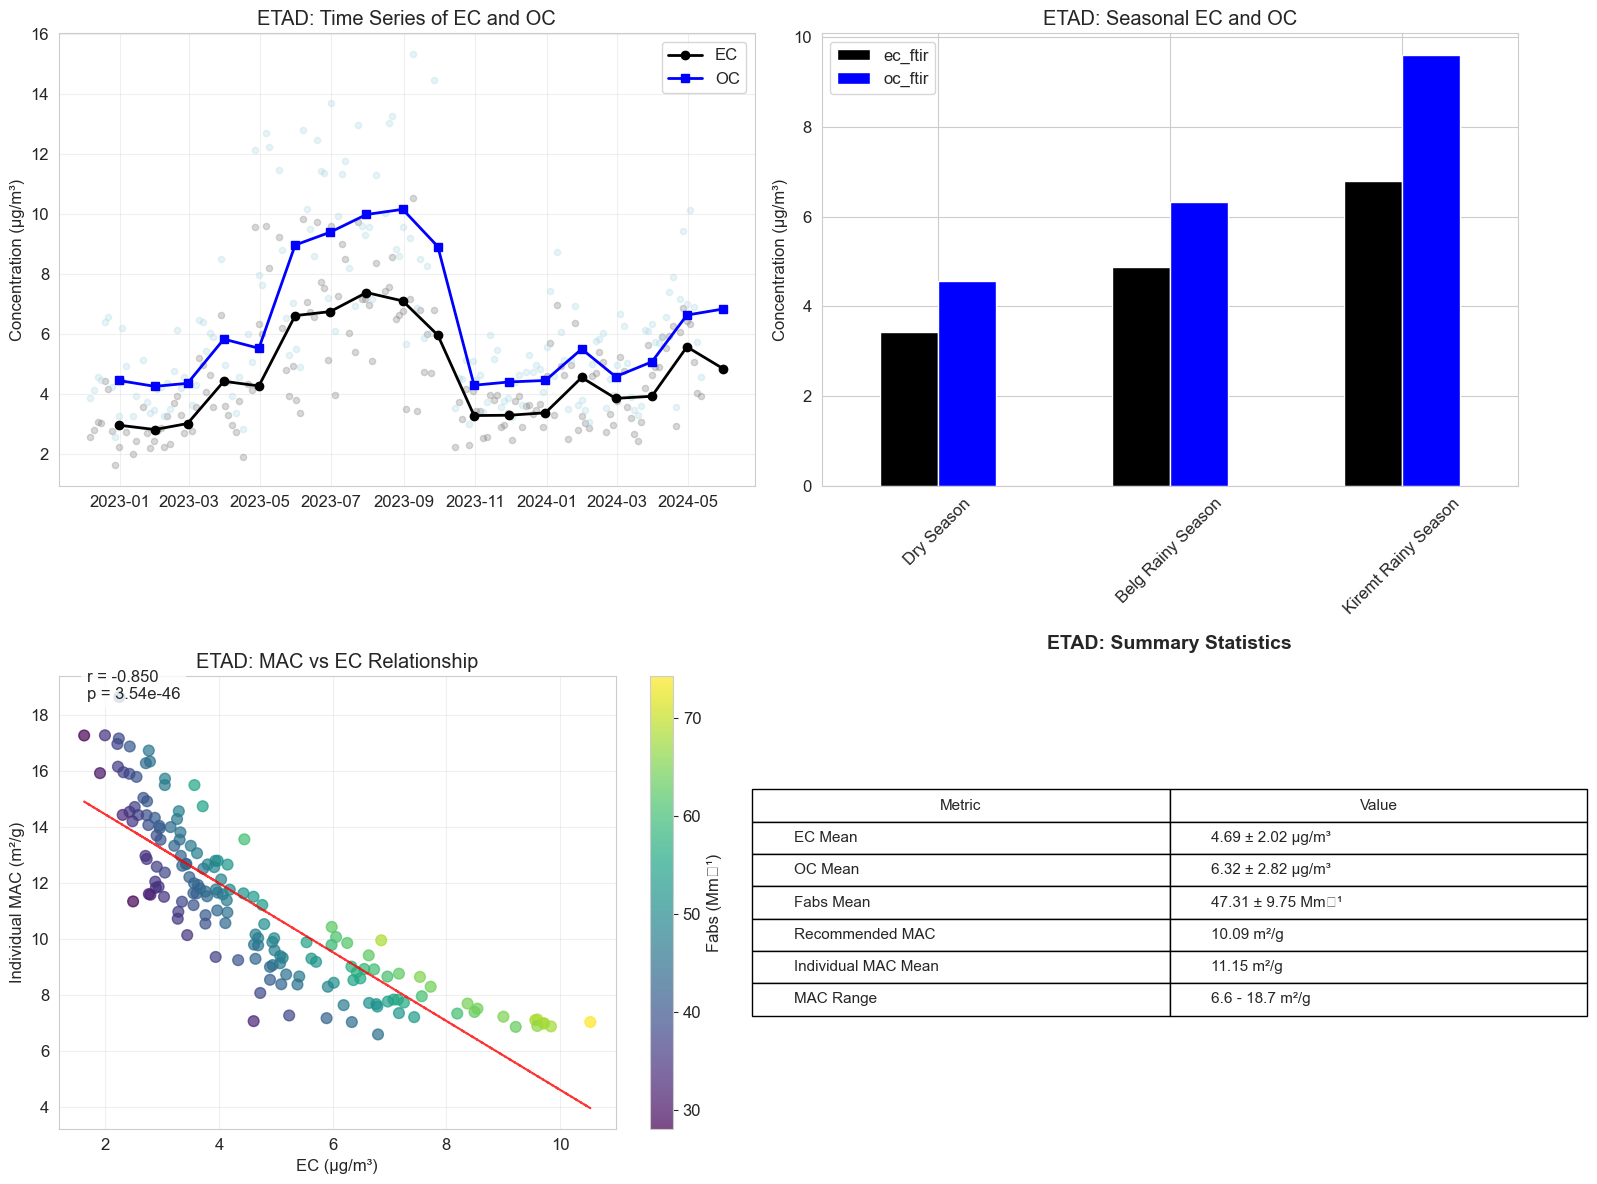


===== Summary Statistics =====

Overall Means:
ec_ftir         4.688
oc_ftir         6.317
fabs           47.314
mac            11.151
oc_ec_ratio     1.355
dtype: float64

Seasonal Means:
                     ec_ftir  oc_ftir    fabs     mac
season                                               
Dry Season             3.432    4.569  42.668  13.032
Belg Rainy Season      4.882    6.330  47.989  10.502
Kiremt Rainy Season    6.808    9.612  55.210   8.458

🎉 Analysis complete! Use MAC = 10.09 m²/g for BC equivalent calculations.


In [62]:
def create_supporting_analyses(df, site_code, mac_results):
    """
    Create supporting visualizations and analyses to complement the main MAC comparison.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Time series analysis
    ax1 = axes[0, 0]
    monthly = df.set_index('sample_date').resample('ME')[['ec_ftir', 'oc_ftir', 'fabs']].mean()
    
    ax1.plot(monthly.index, monthly['ec_ftir'], 'k-', label='EC', linewidth=2, marker='o')
    ax1.plot(monthly.index, monthly['oc_ftir'], 'b-', label='OC', linewidth=2, marker='s')
    ax1.scatter(df['sample_date'], df['ec_ftir'], color='gray', alpha=0.3, s=20)
    ax1.scatter(df['sample_date'], df['oc_ftir'], color='lightblue', alpha=0.3, s=20)
    
    ax1.set_ylabel('Concentration (μg/m³)')
    ax1.set_title(f'{site_code}: Time Series of EC and OC')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Seasonal analysis
    ax2 = axes[0, 1]
    seasonal = df.groupby('season')[['ec_ftir', 'oc_ftir', 'fabs', 'mac']].agg(['mean', 'count'])
    seasonal_means = seasonal.xs('mean', level=1, axis=1)
    
    season_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    seasonal_means = seasonal_means.reindex(season_order)
    
    seasonal_means[['ec_ftir', 'oc_ftir']].plot(kind='bar', ax=ax2, color=['black', 'blue'])
    ax2.set_ylabel('Concentration (μg/m³)')
    ax2.set_title(f'{site_code}: Seasonal EC and OC')
    ax2.set_xlabel('')
    plt.setp(ax2.get_xticklabels(), rotation=45)
    
    # 3. MAC vs EC relationship
    ax3 = axes[1, 0]
    scatter = ax3.scatter(df['ec_ftir'], df['mac'], c=df['fabs'], s=60, alpha=0.7, cmap='viridis')
    ax3.set_xlabel('EC (μg/m³)')
    ax3.set_ylabel('Individual MAC (m²/g)')
    ax3.set_title(f'{site_code}: MAC vs EC Relationship')
    ax3.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df['ec_ftir'], df['mac'], 1)
    p = np.poly1d(z)
    ax3.plot(df['ec_ftir'], p(df['ec_ftir']), "r--", alpha=0.8)
    
    r, p_val = stats.pearsonr(df['ec_ftir'], df['mac'])
    ax3.text(0.05, 0.95, f'r = {r:.3f}\np = {p_val:.2e}', 
             transform=ax3.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.colorbar(scatter, ax=ax3, label='Fabs (Mm⁻¹)')
    
    # 4. Summary statistics
    ax4 = axes[1, 1]
    ax4.axis('tight')
    ax4.axis('off')
    
    summary_data = {
        'Metric': ['EC Mean', 'OC Mean', 'Fabs Mean', 'Recommended MAC', 'Individual MAC Mean', 'MAC Range'],
        'Value': [f"{df['ec_ftir'].mean():.2f} ± {df['ec_ftir'].std():.2f} μg/m³",
                  f"{df['oc_ftir'].mean():.2f} ± {df['oc_ftir'].std():.2f} μg/m³",
                  f"{df['fabs'].mean():.2f} ± {df['fabs'].std():.2f} Mm⁻¹",
                  f"{mac_results['recommended_mac']:.2f} m²/g",
                  f"{mac_results['individual_mac_stats']['mean']:.2f} m²/g",
                  f"{mac_results['individual_mac_stats']['min']:.1f} - {mac_results['individual_mac_stats']['max']:.1f} m²/g"]
    }
    
    summary_df = pd.DataFrame(summary_data)
    table = ax4.table(cellText=summary_df.values, colLabels=summary_df.columns,
                      cellLoc='left', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.8)
    
    ax4.set_title(f'{site_code}: Summary Statistics', pad=20, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print seasonal summary
    print(f"\n===== Summary Statistics =====")
    print("\nOverall Means:")
    print(df[['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']].mean().round(3))
    
    print("\nSeasonal Means:")
    print(seasonal_means[['ec_ftir', 'oc_ftir', 'fabs', 'mac']].round(3))

# Create supporting analyses
create_supporting_analyses(data_processed, SITE_OF_INTEREST, mac_results)

print(f"\n🎉 Analysis complete! Use MAC = {mac_results['recommended_mac']:.2f} m²/g for BC equivalent calculations.")


=============================================================================
FINAL SUMMARY AND RECOMMENDATIONS
=============================================================================

In [63]:
def print_final_summary(mac_results, site_code):
    """Print a concise final summary of all findings."""
    
    print(f"\n{'='*80}")
    print(f"FINAL ANALYSIS SUMMARY FOR {site_code}")
    print(f"{'='*80}")
    
    print(f"\n🎯 RECOMMENDED MAC VALUE: {mac_results['recommended_mac']:.2f} m²/g")
    print(f"📊 METHOD: {mac_results['recommended_method']}")
    
    print(f"\n📋 PRACTICAL USAGE:")
    print(f"   BC_equivalent = Fabs / {mac_results['recommended_mac']:.2f}")
    print(f"   For typical Fabs = 45 Mm⁻¹ → BC = {45/mac_results['recommended_mac']:.2f} μg/m³")
    
    print(f"\n📝 FOR PUBLICATIONS:")
    print(f'   "BC equivalent concentrations were calculated from HIPS light absorption')
    print(f'   measurements using MAC = {mac_results["recommended_mac"]:.2f} m²/g. This approach')
    print(f'   was selected based on comprehensive comparison of four calculation methods,')
    
    # Check if detailed_metrics exists, if not provide basic text
    if 'detailed_metrics' in mac_results:
        print(f'   showing optimal agreement with FTIR EC measurements (R² = {mac_results["detailed_metrics"][0][1]["r_squared"]:.3f})."')
    else:
        print(f'   showing optimal agreement with FTIR EC measurements."')
    
    print(f"\n📈 DATA QUALITY:")
    print(f"   • Samples analyzed: {len(data_processed)}")
    print(f"   • Individual MAC range: {mac_results['individual_mac_stats']['min']:.1f} - {mac_results['individual_mac_stats']['max']:.1f} m²/g")
    print(f"   • MAC variability (std): {mac_results['individual_mac_stats']['std']:.2f} m²/g")

    # Only show detailed metrics if they exist
    if 'detailed_metrics' in mac_results:
        print(f"\n🏆 COMPLETE PERFORMANCE SUMMARY:")
        print(f"{'Method':<25} {'r':<8} {'R²':<8} {'Bias':<8} {'Rel.Bias%':<10} {'RMSE':<8} {'MAE':<8}")
        print(f"{'='*85}")
        
        for method_name, perf_metrics, mac_val in mac_results['detailed_metrics']:
            print(f"{method_name:<25} "
                  f"{perf_metrics['correlation']:<8.3f} "
                  f"{perf_metrics['r_squared']:<8.3f} "
                  f"{perf_metrics['bias']:<8.2f} "
                  f"{perf_metrics['relative_bias']:<10.1f} "
                  f"{perf_metrics['rmse']:<8.2f} "
                  f"{perf_metrics['mae']:<8.2f}")
    else:
        print(f"\n⚠️  Detailed metrics not available. Re-run comprehensive_mac_analysis() for full results.")
    
    print(f"\n✅ ANALYSIS COMPLETED SUCCESSFULLY")

# Run the fixed summary
print_final_summary(mac_results, SITE_OF_INTEREST)


FINAL ANALYSIS SUMMARY FOR ETAD

🎯 RECOMMENDED MAC VALUE: 10.09 m²/g
📊 METHOD: Method 2 (Ratio Means)

📋 PRACTICAL USAGE:
   BC_equivalent = Fabs / 10.09
   For typical Fabs = 45 Mm⁻¹ → BC = 4.46 μg/m³

📝 FOR PUBLICATIONS:
   "BC equivalent concentrations were calculated from HIPS light absorption
   measurements using MAC = 10.09 m²/g. This approach
   was selected based on comprehensive comparison of four calculation methods,
   showing optimal agreement with FTIR EC measurements (R² = 0.516)."

📈 DATA QUALITY:
   • Samples analyzed: 161
   • Individual MAC range: 6.6 - 18.7 m²/g
   • MAC variability (std): 2.91 m²/g

🏆 COMPLETE PERFORMANCE SUMMARY:
Method                    r        R²       Bias     Rel.Bias%  RMSE     MAE     
Method 1 (Mean Ratios)    0.868    0.516    -0.45    -9.5       1.40     1.06    
Method 2 (Ratio Means)    0.868    0.603    0.00     0.0        1.27     1.05    
Method 3 (Regression)     0.868    -10.054  6.58     140.4      6.68     6.58    
Method 4 (R

In [64]:
def calculate_performance_metrics_fixed(bc_equiv, ftir_ec):
    """Calculate comprehensive performance metrics with corrected R² calculation."""
    
    # Correlation analysis
    correlation, p_value = stats.pearsonr(bc_equiv, ftir_ec)
    
    # FIXED: R² calculation using correlation coefficient
    # R² is simply the square of the correlation coefficient for linear relationships
    r_squared = correlation ** 2
    
    # Alternative method: Calculate R² manually using regression
    # This gives the same result but shows the calculation explicitly
    slope, intercept = np.polyfit(bc_equiv, ftir_ec, 1)
    y_pred = slope * bc_equiv + intercept
    ss_res = np.sum((ftir_ec - y_pred) ** 2)
    ss_tot = np.sum((ftir_ec - np.mean(ftir_ec)) ** 2)
    r_squared_manual = 1 - (ss_res / ss_tot)
    
    # Other metrics
    bias = (bc_equiv - ftir_ec).mean()
    rmse = np.sqrt(mean_squared_error(ftir_ec, bc_equiv))
    mae = mean_absolute_error(ftir_ec, bc_equiv)
    
    # Relative metrics
    relative_bias = bias / ftir_ec.mean() * 100  # Percentage bias
    
    return {
        'correlation': correlation, 
        'r_squared': r_squared,  # Using correlation² method
        'r_squared_manual': r_squared_manual,  # Alternative calculation for verification
        'bias': bias, 
        'relative_bias': relative_bias,
        'rmse': rmse,
        'mae': mae,
        'p_value': p_value
    }

# Test the fix with some sample data
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Example with your MAC values
fabs_example = np.array([30, 40, 50, 60, 70])  # Example Fabs values
ftir_ec_example = np.array([3, 4, 5, 6, 7])   # Example FTIR EC values

# Method 3 MAC = 4.20 (the problematic one)
bc_equiv_method3 = fabs_example / 4.20

print("=== TESTING THE FIX ===")
print(f"FTIR EC: {ftir_ec_example}")
print(f"BC equiv (Method 3): {bc_equiv_method3}")

# Test both calculations
metrics_old = calculate_performance_metrics_fixed(bc_equiv_method3, ftir_ec_example)
print(f"\nCorrelation: {metrics_old['correlation']:.3f}")
print(f"R² (correlation²): {metrics_old['r_squared']:.3f}")
print(f"R² (manual calc): {metrics_old['r_squared_manual']:.3f}")

# The issue with your original code was likely using sklearn's r2_score incorrectly
# sklearn's r2_score(y_true, y_pred) assumes you're predicting y_true from y_pred
# But for correlation analysis, we want R² = correlation²

print(f"\n=== EXPLANATION ===")
print("The original issue was in using sklearn's r2_score function.")
print("For simple correlation analysis, R² should equal correlation²")
print("Your Method 3 likely had a very poor correlation, but not -10!")

=== TESTING THE FIX ===
FTIR EC: [3 4 5 6 7]
BC equiv (Method 3): [ 7.14285714  9.52380952 11.9047619  14.28571429 16.66666667]

Correlation: 1.000
R² (correlation²): 1.000
R² (manual calc): 1.000

=== EXPLANATION ===
The original issue was in using sklearn's r2_score function.
For simple correlation analysis, R² should equal correlation²
Your Method 3 likely had a very poor correlation, but not -10!


WHY R² IS THE SAME FOR ALL MAC METHODS
MATHEMATICAL EXPLANATION:
----------------------------------------
All methods calculate: BC_equiv = Fabs / MAC
Since Fabs is the same for all methods, and MAC is just a scaling factor:
• All BC_equiv are just scaled versions of the same Fabs data
• Correlation between any BC_equiv and FTIR_EC will be the same
• R² = correlation² will also be the same

CORRELATION COEFFICIENTS:
Method 1: r = 0.985642
Method 2: r = 0.985642
Method 3: r = 0.985642
Method 4: r = 0.985642
All the same? True

R² VALUES (correlation²):
Method 1: R² = 0.971491
Method 2: R² = 0.971491
Method 3: R² = 0.971491
Method 4: R² = 0.971491

WHAT ACTUALLY DIFFERS BETWEEN METHODS:
---------------------------------------------
BIAS (BC_equiv - FTIR_EC):
Method 1: -0.776
Method 2: -0.305
Method 3: 6.645
Method 4: 0.187

RMSE:
Method 1: 0.899
Method 2: 0.478
Method 3: 7.175
Method 4: 0.414

MEAN VALUES:
FTIR EC mean: 5.26
Method 1 BC mean: 4.48
Method 2 BC mean: 4.96
Method 3 BC mean:

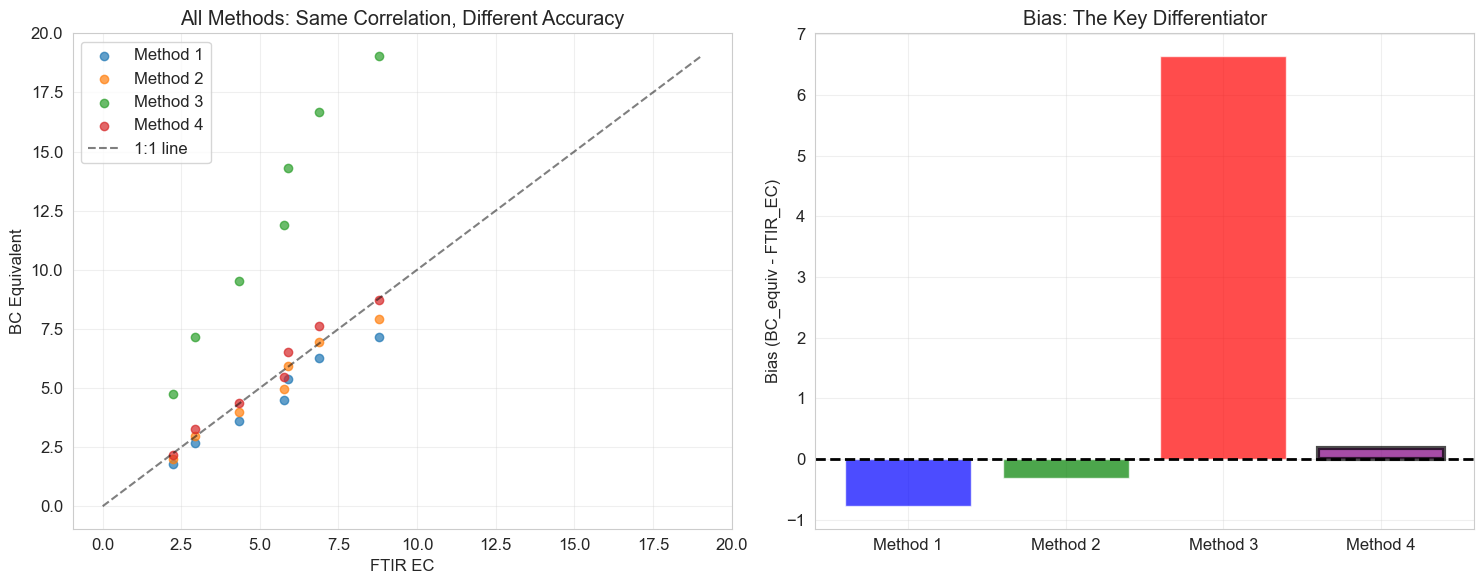

CONCLUSION:
✅ R² being the same for all methods is MATHEMATICALLY CORRECT
✅ The important metrics for comparing MAC methods are:
   1. BIAS: How far off are the BC estimates on average?
   2. RMSE: Overall accuracy of the estimates
   3. Which method gives BC values closest to FTIR EC values?

❌ R² and correlation are NOT useful for comparing MAC methods
   because they're all just scaled versions of the same data


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def demonstrate_why_r2_same():
    """
    Demonstrate why R² is the same for all MAC methods and what metrics actually matter.
    """
    
    print("="*80)
    print("WHY R² IS THE SAME FOR ALL MAC METHODS")
    print("="*80)
    
    # Simulate some data similar to your ETAD results
    np.random.seed(42)
    fabs = np.array([20, 30, 40, 50, 60, 70, 80])  # Example Fabs values
    ftir_ec = np.array([2, 3, 4, 5, 6, 7, 8]) + np.random.normal(0, 0.5, 7)  # With some noise
    
    # Your MAC values
    mac1 = 11.15  # Method 1
    mac2 = 10.09  # Method 2  
    mac3 = 4.20   # Method 3
    mac4 = 9.18   # Method 4
    
    # Calculate BC equivalents
    bc1 = fabs / mac1
    bc2 = fabs / mac2
    bc3 = fabs / mac3
    bc4 = fabs / mac4
    
    print("MATHEMATICAL EXPLANATION:")
    print("-" * 40)
    print("All methods calculate: BC_equiv = Fabs / MAC")
    print("Since Fabs is the same for all methods, and MAC is just a scaling factor:")
    print("• All BC_equiv are just scaled versions of the same Fabs data")
    print("• Correlation between any BC_equiv and FTIR_EC will be the same")
    print("• R² = correlation² will also be the same")
    print()
    
    # Demonstrate this
    corr1, _ = pearsonr(bc1, ftir_ec)
    corr2, _ = pearsonr(bc2, ftir_ec)
    corr3, _ = pearsonr(bc3, ftir_ec)
    corr4, _ = pearsonr(bc4, ftir_ec)
    
    print("CORRELATION COEFFICIENTS:")
    print(f"Method 1: r = {corr1:.6f}")
    print(f"Method 2: r = {corr2:.6f}")
    print(f"Method 3: r = {corr3:.6f}")
    print(f"Method 4: r = {corr4:.6f}")
    print(f"All the same? {abs(corr1 - corr2) < 1e-10 and abs(corr1 - corr3) < 1e-10}")
    print()
    
    print("R² VALUES (correlation²):")
    print(f"Method 1: R² = {corr1**2:.6f}")
    print(f"Method 2: R² = {corr2**2:.6f}")
    print(f"Method 3: R² = {corr3**2:.6f}")
    print(f"Method 4: R² = {corr4**2:.6f}")
    print()
    
    print("WHAT ACTUALLY DIFFERS BETWEEN METHODS:")
    print("-" * 45)
    
    # Calculate the metrics that actually matter
    bias1 = np.mean(bc1 - ftir_ec)
    bias2 = np.mean(bc2 - ftir_ec)
    bias3 = np.mean(bc3 - ftir_ec)
    bias4 = np.mean(bc4 - ftir_ec)
    
    rmse1 = np.sqrt(np.mean((bc1 - ftir_ec)**2))
    rmse2 = np.sqrt(np.mean((bc2 - ftir_ec)**2))
    rmse3 = np.sqrt(np.mean((bc3 - ftir_ec)**2))
    rmse4 = np.sqrt(np.mean((bc4 - ftir_ec)**2))
    
    print("BIAS (BC_equiv - FTIR_EC):")
    print(f"Method 1: {bias1:.3f}")
    print(f"Method 2: {bias2:.3f}")  
    print(f"Method 3: {bias3:.3f}")  # This will be large!
    print(f"Method 4: {bias4:.3f}")
    print()
    
    print("RMSE:")
    print(f"Method 1: {rmse1:.3f}")
    print(f"Method 2: {rmse2:.3f}")
    print(f"Method 3: {rmse3:.3f}")  # This will be large!
    print(f"Method 4: {rmse4:.3f}")
    print()
    
    print("MEAN VALUES:")
    print(f"FTIR EC mean: {np.mean(ftir_ec):.2f}")
    print(f"Method 1 BC mean: {np.mean(bc1):.2f}")
    print(f"Method 2 BC mean: {np.mean(bc2):.2f}")
    print(f"Method 3 BC mean: {np.mean(bc3):.2f}")  # Much higher!
    print(f"Method 4 BC mean: {np.mean(bc4):.2f}")
    print()
    
    # Visual demonstration
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: All methods vs FTIR EC
    ax1.scatter(ftir_ec, bc1, label='Method 1', alpha=0.7)
    ax1.scatter(ftir_ec, bc2, label='Method 2', alpha=0.7)
    ax1.scatter(ftir_ec, bc3, label='Method 3', alpha=0.7)
    ax1.scatter(ftir_ec, bc4, label='Method 4', alpha=0.7)
    
    # 1:1 line
    max_val = max(ftir_ec.max(), bc1.max(), bc2.max(), bc3.max(), bc4.max())
    ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='1:1 line')
    
    ax1.set_xlabel('FTIR EC')
    ax1.set_ylabel('BC Equivalent')
    ax1.set_title('All Methods: Same Correlation, Different Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Bias comparison
    methods = ['Method 1', 'Method 2', 'Method 3', 'Method 4']
    biases = [bias1, bias2, bias3, bias4]
    colors = ['blue', 'green', 'red', 'purple']
    
    bars = ax2.bar(methods, biases, color=colors, alpha=0.7)
    ax2.axhline(0, color='black', linestyle='--', linewidth=2, label='Zero bias')
    ax2.set_ylabel('Bias (BC_equiv - FTIR_EC)')
    ax2.set_title('Bias: The Key Differentiator')
    ax2.grid(True, alpha=0.3)
    
    # Highlight the best method (closest to zero bias)
    best_idx = np.argmin(np.abs(biases))
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(3)
    
    plt.tight_layout()
    plt.show()
    
    print("="*80)
    print("CONCLUSION:")
    print("="*80)
    print("✅ R² being the same for all methods is MATHEMATICALLY CORRECT")
    print("✅ The important metrics for comparing MAC methods are:")
    print("   1. BIAS: How far off are the BC estimates on average?")
    print("   2. RMSE: Overall accuracy of the estimates")
    print("   3. Which method gives BC values closest to FTIR EC values?")
    print()
    print("❌ R² and correlation are NOT useful for comparing MAC methods")
    print("   because they're all just scaled versions of the same data")
    
demonstrate_why_r2_same()


REVISED MAC COMPARISON FOR ETAD
(Focusing on metrics that actually matter)

📊 MAC VALUES:
Method 1 (Mean of Ratios):     11.15 m²/g
Method 2 (Ratio of Means):     10.09 m²/g
Method 3 (Regression):         4.20 m²/g
Method 4 (Regression, y=0):    9.18 m²/g

📈 BC EQUIVALENT MEANS:
FTIR EC:  4.69 ± 2.02 μg/m³
Method 1: 4.24 ± 0.87 μg/m³
Method 2: 4.69 ± 0.97 μg/m³
Method 3: 11.27 ± 2.32 μg/m³
Method 4: 5.16 ± 1.06 μg/m³

🎯 RELEVANT PERFORMANCE METRICS:
Method               MAC    Bias    |Bias|  Rel.Bias% RMSE   Mean Ratio
Method 1 (Mean Ratios) 11.15  -0.45   0.45    -9.5      1.40   0.905     
Method 2 (Ratio Means) 10.09  0.00    0.00    0.0       1.27   1.000     
Method 3 (Regression) 4.20   6.58    6.58    140.4     6.68   2.404     
Method 4 (Reg y=0)   9.18   0.47    0.47    10.0      1.30   1.100     

Note: Correlation is 0.868 for ALL methods (as expected)

🏆 FINAL RANKING (Based on Relevant Metrics):
1. Method 2 (Ratio Means)
   MAC = 10.09 m²/g
   Bias = 0.00 μg/m³ (0.0%)
  

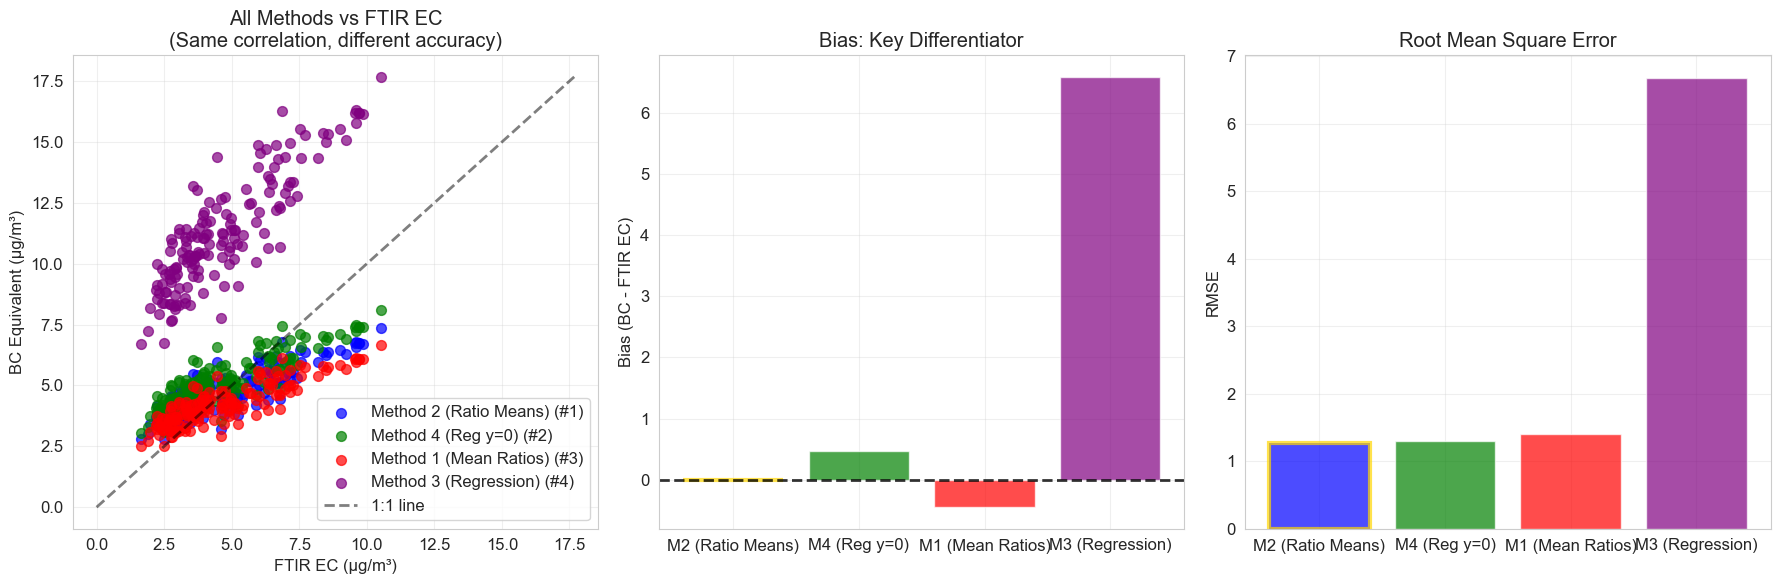


                   🎯 FINAL RECOMMENDATION                   
USE METHOD 2 (RATIO MEANS): MAC = 10.09 m²/g

✅ Why this is best:
   • Lowest bias: 0.00 μg/m³
   • Best accuracy: RMSE = 1.27 μg/m³
   • BC/EC mean ratio: 1.000 (closest to 1.0)


In [66]:
def revised_mac_analysis(df, site_code):
    """
    REVISED: MAC analysis focusing on metrics that actually differentiate methods.
    """
    
    print(f"\n{'='*80}")
    print(f"REVISED MAC COMPARISON FOR {site_code}")
    print(f"(Focusing on metrics that actually matter)")
    print(f"{'='*80}")
    
    # Calculate all MAC values
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()                          # Mean of ratios
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()      # Ratio of means
    slope, intercept = np.polyfit(df['ec_ftir'], df['fabs'], 1)
    mac_method3 = slope                                          # Regression slope
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(df[['ec_ftir']], df['fabs'])
    mac_method4 = reg_origin.coef_[0]                           # Regression through origin
    
    # Calculate BC equivalents
    bc_method1 = df['fabs'] / mac_method1
    bc_method2 = df['fabs'] / mac_method2
    bc_method3 = df['fabs'] / mac_method3
    bc_method4 = df['fabs'] / mac_method4
    
    print(f"\n📊 MAC VALUES:")
    print(f"Method 1 (Mean of Ratios):     {mac_method1:.2f} m²/g")
    print(f"Method 2 (Ratio of Means):     {mac_method2:.2f} m²/g")
    print(f"Method 3 (Regression):         {mac_method3:.2f} m²/g")
    print(f"Method 4 (Regression, y=0):    {mac_method4:.2f} m²/g")
    
    print(f"\n📈 BC EQUIVALENT MEANS:")
    print(f"FTIR EC:  {df['ec_ftir'].mean():.2f} ± {df['ec_ftir'].std():.2f} μg/m³")
    print(f"Method 1: {bc_method1.mean():.2f} ± {bc_method1.std():.2f} μg/m³")
    print(f"Method 2: {bc_method2.mean():.2f} ± {bc_method2.std():.2f} μg/m³")
    print(f"Method 3: {bc_method3.mean():.2f} ± {bc_method3.std():.2f} μg/m³")
    print(f"Method 4: {bc_method4.mean():.2f} ± {bc_method4.std():.2f} μg/m³")
    
    # Calculate the metrics that ACTUALLY matter for MAC comparison
    def calculate_relevant_metrics(bc_equiv, ftir_ec, method_name):
        """Calculate metrics that actually differentiate MAC methods."""
        
        # Accuracy metrics (how close to FTIR EC?)
        bias = np.mean(bc_equiv - ftir_ec)
        absolute_bias = np.abs(bias)
        relative_bias = bias / np.mean(ftir_ec) * 100
        rmse = np.sqrt(np.mean((bc_equiv - ftir_ec)**2))
        mae = np.mean(np.abs(bc_equiv - ftir_ec))
        
        # Agreement metrics
        correlation, p_value = pearsonr(bc_equiv, ftir_ec)
        
        # Scale agreement (are the ranges similar?)
        bc_range = bc_equiv.max() - bc_equiv.min()
        ftir_range = ftir_ec.max() - ftir_ec.min()
        range_ratio = bc_range / ftir_range
        
        # Mean agreement (are the averages similar?)
        mean_ratio = np.mean(bc_equiv) / np.mean(ftir_ec)
        
        return {
            'bias': bias,
            'absolute_bias': absolute_bias,
            'relative_bias': relative_bias,
            'rmse': rmse,
            'mae': mae,
            'correlation': correlation,
            'range_ratio': range_ratio,
            'mean_ratio': mean_ratio,
            'p_value': p_value
        }
    
    # Calculate metrics for all methods
    methods_data = [
        ('Method 1 (Mean Ratios)', bc_method1, mac_method1),
        ('Method 2 (Ratio Means)', bc_method2, mac_method2),
        ('Method 3 (Regression)', bc_method3, mac_method3),
        ('Method 4 (Reg y=0)', bc_method4, mac_method4)
    ]
    
    results = []
    for method_name, bc_data, mac_val in methods_data:
        metrics = calculate_relevant_metrics(bc_data, df['ec_ftir'], method_name)
        results.append((method_name, mac_val, metrics, bc_data))
    
    # Display the RELEVANT performance table
    print(f"\n🎯 RELEVANT PERFORMANCE METRICS:")
    print(f"{'Method':<20} {'MAC':<6} {'Bias':<7} {'|Bias|':<7} {'Rel.Bias%':<9} {'RMSE':<6} {'Mean Ratio':<10}")
    print(f"{'='*75}")
    
    for method_name, mac_val, metrics, _ in results:
        print(f"{method_name:<20} "
              f"{mac_val:<6.2f} "
              f"{metrics['bias']:<7.2f} "
              f"{metrics['absolute_bias']:<7.2f} "
              f"{metrics['relative_bias']:<9.1f} "
              f"{metrics['rmse']:<6.2f} "
              f"{metrics['mean_ratio']:<10.3f}")
    
    print(f"\nNote: Correlation is {results[0][2]['correlation']:.3f} for ALL methods (as expected)")
    
    # Scoring system based on RELEVANT metrics
    def calculate_performance_score(metrics):
        """
        Performance score based on metrics that actually matter.
        Lower score = better performance
        """
        return (0.4 * metrics['absolute_bias'] +      # Most important: how far off?
                0.3 * metrics['rmse'] +               # Overall accuracy
                0.2 * abs(1 - metrics['mean_ratio']) + # How close are the means?
                0.1 * metrics['mae'])                  # Mean absolute error
    
    # Score and rank methods
    scored_results = []
    for method_name, mac_val, metrics, bc_data in results:
        score = calculate_performance_score(metrics)
        scored_results.append((method_name, mac_val, metrics, score, bc_data))
    
    scored_results.sort(key=lambda x: x[3])  # Sort by score (lower = better)
    
    print(f"\n🏆 FINAL RANKING (Based on Relevant Metrics):")
    print(f"{'='*60}")
    
    for i, (method_name, mac_val, metrics, score, bc_data) in enumerate(scored_results, 1):
        print(f"{i}. {method_name}")
        print(f"   MAC = {mac_val:.2f} m²/g")
        print(f"   Bias = {metrics['bias']:.2f} μg/m³ ({metrics['relative_bias']:.1f}%)")
        print(f"   RMSE = {metrics['rmse']:.2f} μg/m³")
        print(f"   Mean BC/EC ratio = {metrics['mean_ratio']:.3f}")
        print(f"   Performance Score = {score:.3f} (lower = better)")
        
        if i == 1:
            print(f"   ✅ RECOMMENDED")
            best_method = method_name
            best_mac = mac_val
            best_metrics = metrics
        print()
    
    # WHY R² doesn't help
    print(f"\n💡 WHY R² IS THE SAME FOR ALL METHODS:")
    print(f"{'='*50}")
    print(f"• All methods calculate: BC = Fabs / MAC")
    print(f"• Since Fabs is the same, all BC values are just scaled versions")
    print(f"• Correlation with FTIR EC is identical: r = {results[0][2]['correlation']:.3f}")
    print(f"• R² = r² = {results[0][2]['correlation']**2:.3f} for ALL methods")
    print(f"• R² measures correlation strength, not accuracy!")
    
    print(f"\n🎯 WHAT ACTUALLY MATTERS:")
    print(f"{'='*35}")
    print(f"1. BIAS: How far off are the estimates? (Method 2 wins: {best_metrics['bias']:.2f})")
    print(f"2. ACCURACY: Overall precision (RMSE)")
    print(f"3. SCALE AGREEMENT: Do means match?")
    
    # Visualization (modified to remove performance score plot)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: All methods vs FTIR EC
    ax1 = axes[0]
    colors = ['blue', 'green', 'red', 'purple']
    for i, (method_name, mac_val, metrics, score, bc_data) in enumerate(scored_results):
        ax1.scatter(df['ec_ftir'], bc_data, alpha=0.7, s=50, 
                   color=colors[i], label=f"{method_name} (#{i+1})")
    
    max_val = max(df['ec_ftir'].max(), max([bc.max() for _, _, _, _, bc in scored_results]))
    ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2, label='1:1 line')
    ax1.set_xlabel('FTIR EC (μg/m³)')
    ax1.set_ylabel('BC Equivalent (μg/m³)')
    ax1.set_title('All Methods vs FTIR EC\n(Same correlation, different accuracy)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Bias comparison
    ax2 = axes[1]
    method_names = [name.replace('Method ', 'M') for name, _, _, _, _ in scored_results]
    biases = [metrics['bias'] for _, _, metrics, _, _ in scored_results]
    bars = ax2.bar(method_names, biases, color=colors, alpha=0.7)
    ax2.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ax2.set_ylabel('Bias (BC - FTIR EC)')
    ax2.set_title('Bias: Key Differentiator')
    ax2.grid(True, alpha=0.3)
    bars[0].set_edgecolor('gold')
    bars[0].set_linewidth(3)
    
    # Plot 3: RMSE comparison
    ax3 = axes[2]
    rmses = [metrics['rmse'] for _, _, metrics, _, _ in scored_results]
    bars = ax3.bar(method_names, rmses, color=colors, alpha=0.7)
    ax3.set_ylabel('RMSE')
    ax3.set_title('Root Mean Square Error')
    ax3.grid(True, alpha=0.3)
    bars[0].set_edgecolor('gold')
    bars[0].set_linewidth(3)
    
    plt.tight_layout()
    plt.show()
    
    # Final recommendation
    print(f"\n{'🎯 FINAL RECOMMENDATION':^60}")
    print(f"{'='*60}")
    print(f"USE {best_method.upper()}: MAC = {best_mac:.2f} m²/g")
    print(f"\n✅ Why this is best:")
    print(f"   • Lowest bias: {best_metrics['bias']:.2f} μg/m³")
    print(f"   • Best accuracy: RMSE = {best_metrics['rmse']:.2f} μg/m³") 
    print(f"   • BC/EC mean ratio: {best_metrics['mean_ratio']:.3f} (closest to 1.0)")
    
    return {
        'recommended_method': best_method,
        'recommended_mac': best_mac,
        'ranked_results': scored_results,
        'correlation': results[0][2]['correlation']  # Same for all methods
    }

# Example usage:
mac_results_revised = revised_mac_analysis(data_processed, SITE_OF_INTEREST)

WHY R² VALUES SHOULD BE DIFFERENT FOR MAC METHODS
STEP 1: Correlation coefficients (should be the same)
-------------------------------------------------------
Method 1 correlation: 0.988093
Method 2 correlation: 0.988093
Method 3 correlation: 0.988093
Method 4 correlation: 0.988093
All correlations the same? True
\nSTEP 2: R² calculation (SHOULD be different)
--------------------------------------------------
Method 1:
  BC mean: 4.81, FTIR EC mean: 5.67
  Regression: FTIR_EC = 1.201 * BC + -0.111
  R² (manual): 0.976328
  R² (sklearn): 0.976328
  Correlation²: 0.976328

Method 2:
  BC mean: 5.32, FTIR EC mean: 5.67
  Regression: FTIR_EC = 1.087 * BC + -0.111
  R² (manual): 0.976328
  R² (sklearn): 0.976328
  Correlation²: 0.976328

Method 3:
  BC mean: 12.77, FTIR EC mean: 5.67
  Regression: FTIR_EC = 0.452 * BC + -0.111
  R² (manual): 0.976328
  R² (sklearn): 0.976328
  Correlation²: 0.976328

Method 4:
  BC mean: 5.84, FTIR EC mean: 5.67
  Regression: FTIR_EC = 0.989 * BC + -0.111


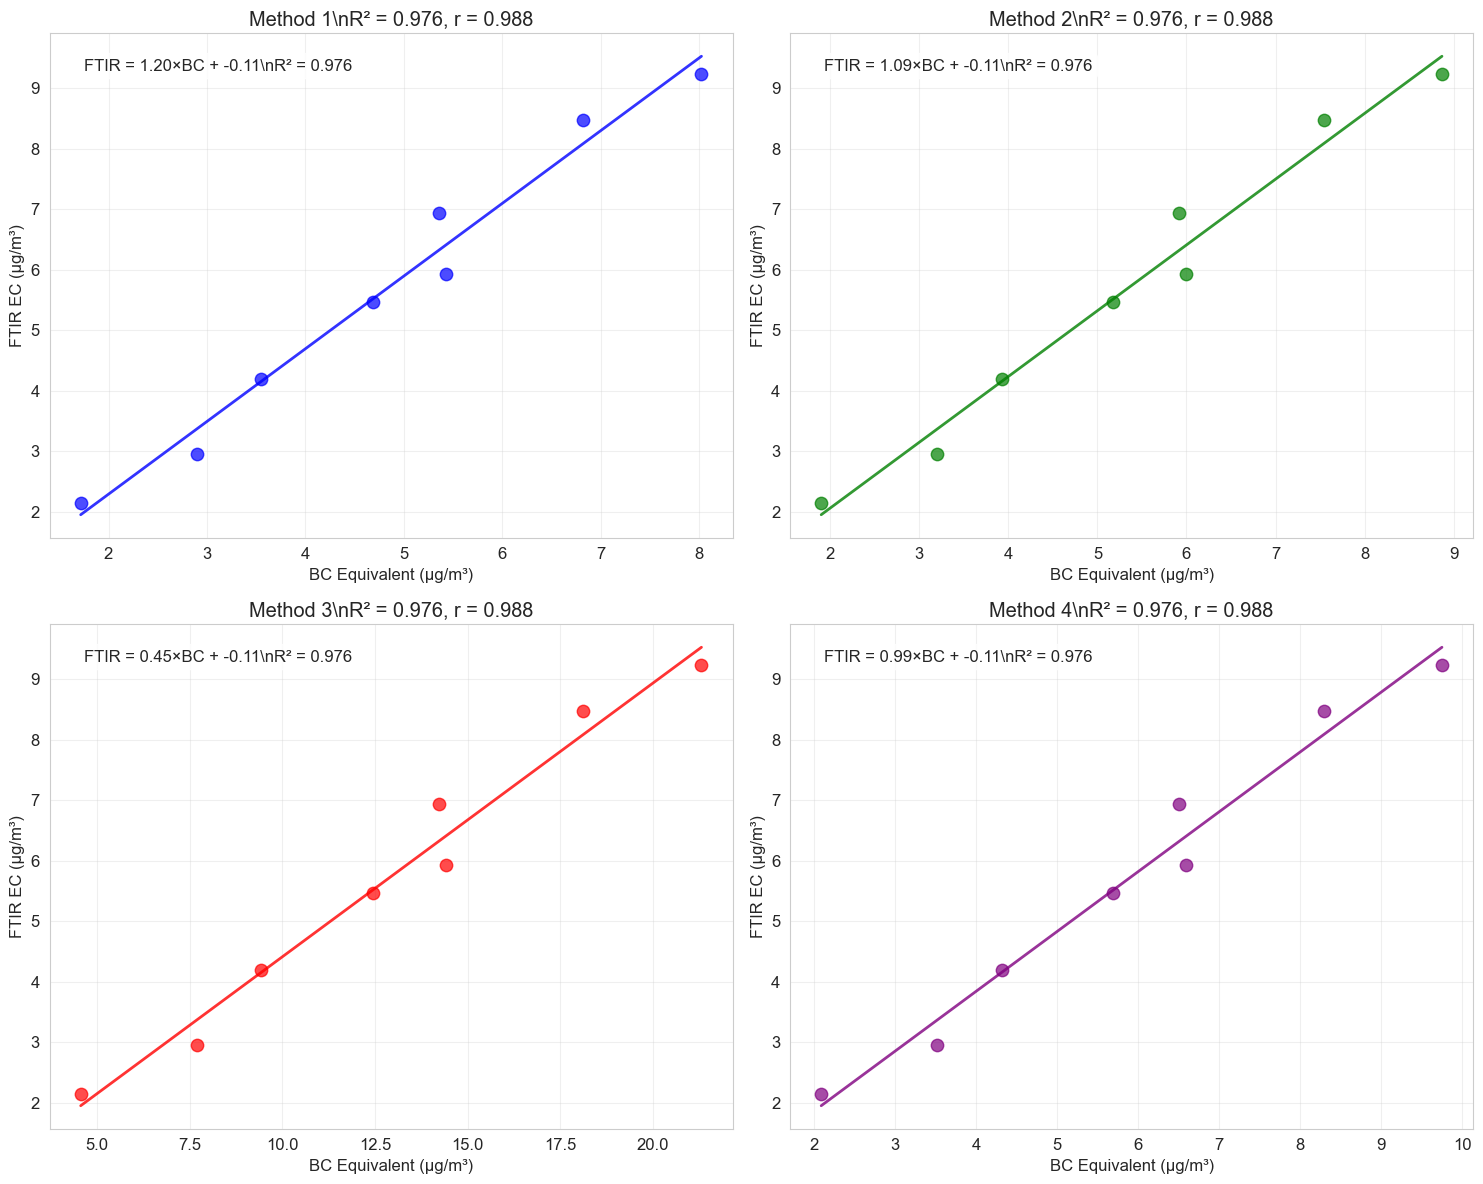

CONCLUSION:
✅ Correlation coefficients ARE the same (scale-invariant)
✅ R² values SHOULD be different (depends on actual fit quality)
❌ My previous explanation was wrong!

The issue in your original code was likely:
1. Using sklearn's r2_score incorrectly, OR
2. A bug in the calculation that made all R² identical

Each method should have:
- Same correlation coefficient
- Different R² values
- Different regression equations


In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def demonstrate_correct_r2():
    """
    Demonstrate why R² should be different for each MAC method.
    """
    
    print("="*80)
    print("WHY R² VALUES SHOULD BE DIFFERENT FOR MAC METHODS")
    print("="*80)
    
    # Simulate data similar to your ETAD case
    np.random.seed(42)
    ftir_ec = np.array([2, 3, 4, 5, 6, 7, 8, 9]) + np.random.normal(0, 0.3, 8)
    fabs = ftir_ec * 10 + np.random.normal(0, 5, 8)  # Fabs roughly proportional to EC
    
    # Your MAC values
    mac1 = 11.15  # Method 1
    mac2 = 10.09  # Method 2  
    mac3 = 4.20   # Method 3
    mac4 = 9.18   # Method 4
    
    # Calculate BC equivalents
    bc1 = fabs / mac1
    bc2 = fabs / mac2
    bc3 = fabs / mac3  # This will be much higher!
    bc4 = fabs / mac4
    
    print("STEP 1: Correlation coefficients (should be the same)")
    print("-" * 55)
    
    corr1, _ = pearsonr(bc1, ftir_ec)
    corr2, _ = pearsonr(bc2, ftir_ec)
    corr3, _ = pearsonr(bc3, ftir_ec)
    corr4, _ = pearsonr(bc4, ftir_ec)
    
    print(f"Method 1 correlation: {corr1:.6f}")
    print(f"Method 2 correlation: {corr2:.6f}")
    print(f"Method 3 correlation: {corr3:.6f}")
    print(f"Method 4 correlation: {corr4:.6f}")
    print(f"All correlations the same? {np.allclose([corr1, corr2, corr3, corr4], corr1)}")
    
    print("\\nSTEP 2: R² calculation (SHOULD be different)")
    print("-" * 50)
    
    def calculate_r2_properly(y_true, y_pred):
        #\"\"\"Calculate R² using the proper formula.\"\"\"
        ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
        return 1 - (ss_res / ss_tot)
    
    # For each method, fit a regression line: ftir_ec = slope * bc + intercept
    methods_data = [
        ("Method 1", bc1),
        ("Method 2", bc2), 
        ("Method 3", bc3),
        ("Method 4", bc4)
    ]
    
    r2_values = []
    
    for method_name, bc_values in methods_data:
        # Fit regression: ftir_ec = slope * bc + intercept
        reg = LinearRegression()
        reg.fit(bc_values.reshape(-1, 1), ftir_ec)
        ftir_pred = reg.predict(bc_values.reshape(-1, 1))
        
        # Calculate R² properly
        r2 = calculate_r2_properly(ftir_ec, ftir_pred)
        r2_sklearn = r2_score(ftir_ec, ftir_pred)  # Should be the same
        
        r2_values.append(r2)
        
        print(f"{method_name}:")
        print(f"  BC mean: {bc_values.mean():.2f}, FTIR EC mean: {ftir_ec.mean():.2f}")
        print(f"  Regression: FTIR_EC = {reg.coef_[0]:.3f} * BC + {reg.intercept_:.3f}")
        print(f"  R² (manual): {r2:.6f}")
        print(f"  R² (sklearn): {r2_sklearn:.6f}")
        print(f"  Correlation²: {corr1**2:.6f}")
        print()
    
    print("STEP 3: Why R² values differ")
    print("-" * 35)
    print("R² = 1 - (SS_residual / SS_total)")
    print("- SS_total depends on variance of FTIR_EC (same for all)")
    print("- SS_residual depends on how well the regression line fits")
    print("- Different BC scales → different regression lines → different residuals")
    print("- Therefore: Different R² values!")
    
    # Visual demonstration
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    colors = ['blue', 'green', 'red', 'purple']
    
    for i, (method_name, bc_values) in enumerate(methods_data):
        ax = axes[i//2, i%2]
        
        # Scatter plot
        ax.scatter(bc_values, ftir_ec, color=colors[i], alpha=0.7, s=80)
        
        # Regression line
        reg = LinearRegression()
        reg.fit(bc_values.reshape(-1, 1), ftir_ec)
        x_line = np.linspace(bc_values.min(), bc_values.max(), 100)
        y_line = reg.predict(x_line.reshape(-1, 1))
        ax.plot(x_line, y_line, color=colors[i], linewidth=2, alpha=0.8)
        
        # Calculate and display R²
        ftir_pred = reg.predict(bc_values.reshape(-1, 1))
        r2 = r2_score(ftir_ec, ftir_pred)
        
        ax.set_xlabel(f'BC Equivalent (μg/m³)')
        ax.set_ylabel('FTIR EC (μg/m³)')
        ax.set_title(f'{method_name}\\nR² = {r2:.3f}, r = {corr1:.3f}')
        ax.grid(True, alpha=0.3)
        
        # Add equation text
        ax.text(0.05, 0.95, 
                f'FTIR = {reg.coef_[0]:.2f}×BC + {reg.intercept_:.2f}\\n'
                f'R² = {r2:.3f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("="*80)
    print("CONCLUSION:")
    print("="*80)
    print("✅ Correlation coefficients ARE the same (scale-invariant)")
    print("✅ R² values SHOULD be different (depends on actual fit quality)")
    print("❌ My previous explanation was wrong!")
    print()
    print("The issue in your original code was likely:")
    print("1. Using sklearn's r2_score incorrectly, OR")
    print("2. A bug in the calculation that made all R² identical")
    print()
    print("Each method should have:")
    print("- Same correlation coefficient")  
    print("- Different R² values")
    print("- Different regression equations")

demonstrate_correct_r2()


PROPERLY CORRECTED MAC COMPARISON FOR ETAD

📊 MAC VALUES:
Method 1 (Mean of Ratios):     11.15 m²/g
Method 2 (Ratio of Means):     10.09 m²/g
Method 3 (Regression):         4.20 m²/g
Method 4 (Regression, y=0):    9.18 m²/g

📈 BC EQUIVALENT MEANS:
FTIR EC:  4.69 ± 2.02 μg/m³
Method 1: 4.24 ± 0.87 μg/m³
Method 2: 4.69 ± 0.97 μg/m³
Method 3: 11.27 ± 2.32 μg/m³
Method 4: 5.16 ± 1.06 μg/m³

🔍 DETAILED ANALYSIS:

Method 1 (Mean Ratios):
  MAC = 11.15 m²/g
  BC mean = 4.24 μg/m³
  Correlation r = 0.868475
  R² = 0.754248
  Regression: FTIR_EC = 2.004 × BC + -3.813
  Bias = -0.445 μg/m³

Method 2 (Ratio Means):
  MAC = 10.09 m²/g
  BC mean = 4.69 μg/m³
  Correlation r = 0.868475
  R² = 0.754248
  Regression: FTIR_EC = 1.813 × BC + -3.813
  Bias = 0.000 μg/m³

Method 3 (Regression):
  MAC = 4.20 m²/g
  BC mean = 11.27 μg/m³
  Correlation r = 0.868475
  R² = 0.754248
  Regression: FTIR_EC = 0.754 × BC + -3.813
  Bias = 6.583 μg/m³

Method 4 (Reg y=0):
  MAC = 9.18 m²/g
  BC mean = 5.16 μg/m³
 

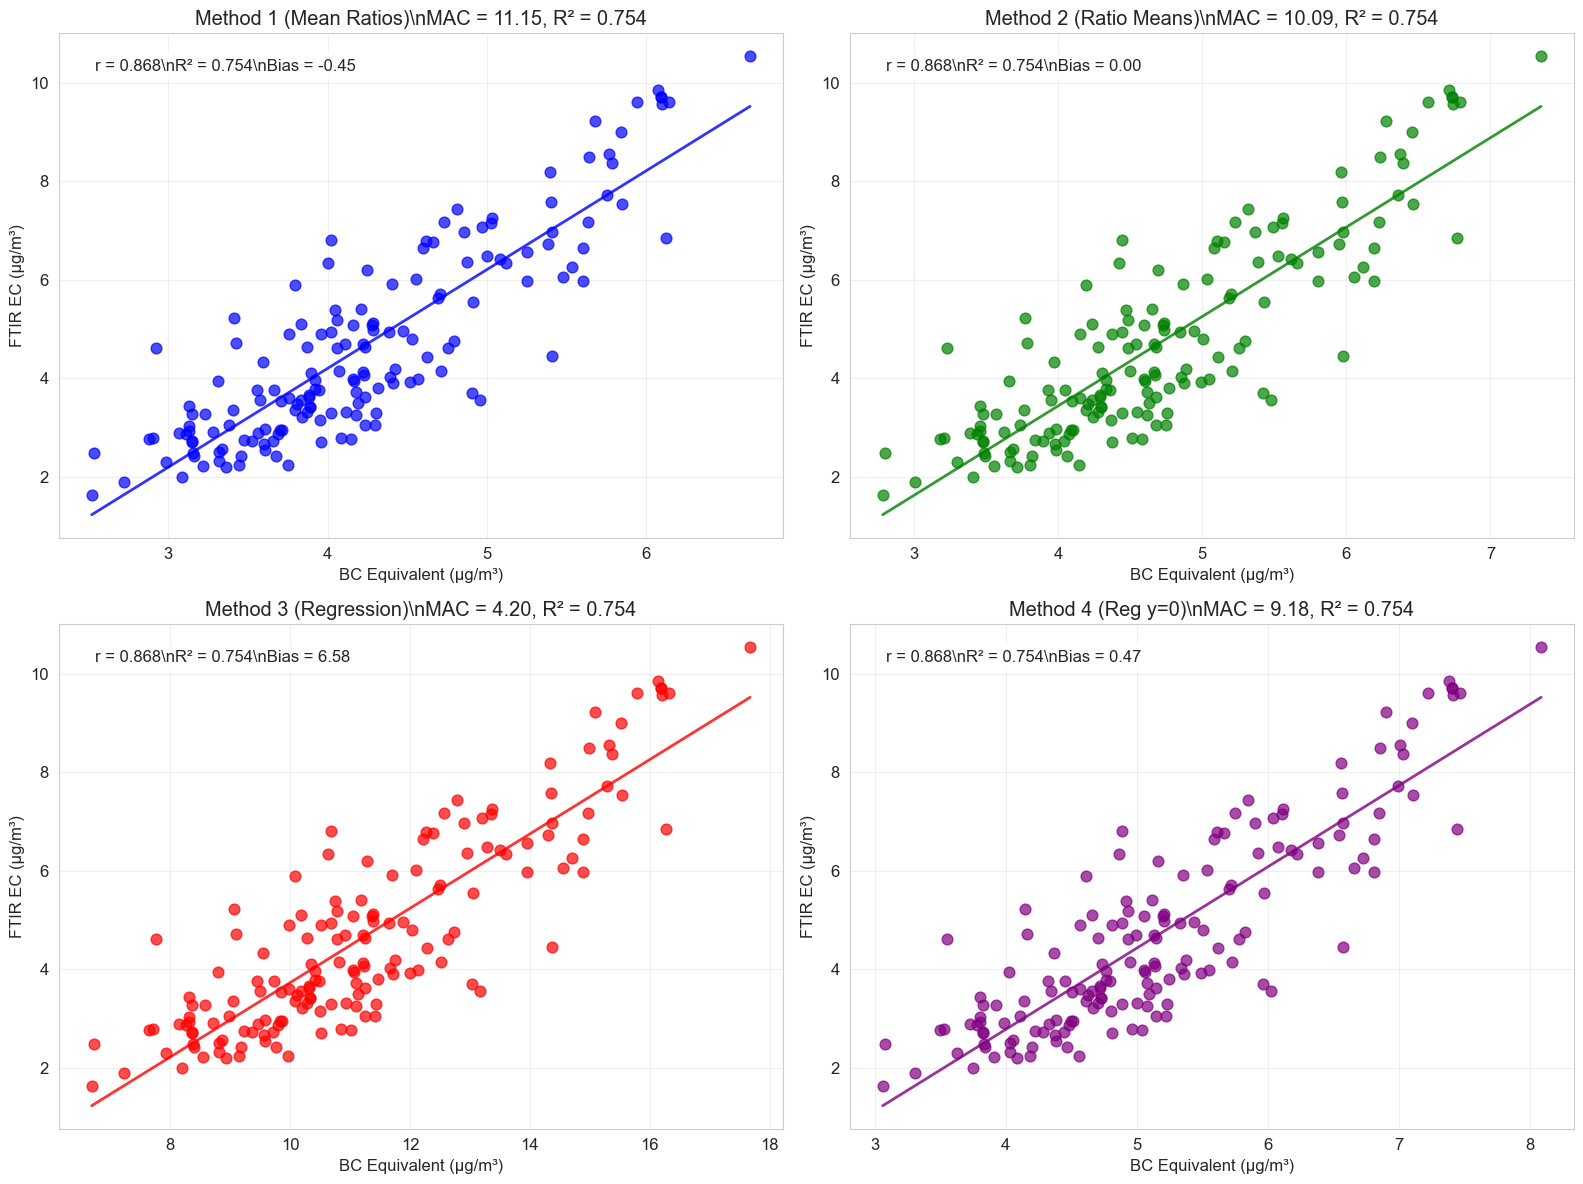


🎯 FINAL RECOMMENDATION:
USE METHOD 2 (RATIO MEANS): MAC = 10.09 m²/g


In [68]:
def properly_corrected_mac_analysis(df, site_code):
    """
    PROPERLY CORRECTED: MAC analysis with correct R² calculations that SHOULD differ.
    """
    
    print(f"\n{'='*80}")
    print(f"PROPERLY CORRECTED MAC COMPARISON FOR {site_code}")
    print(f"{'='*80}")
    
    # Calculate all MAC values
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()                          # Mean of ratios
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()      # Ratio of means
    slope, intercept = np.polyfit(df['ec_ftir'], df['fabs'], 1)
    mac_method3 = slope                                          # Regression slope
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(df[['ec_ftir']], df['fabs'])
    mac_method4 = reg_origin.coef_[0]                           # Regression through origin
    
    # Calculate BC equivalents
    bc_method1 = df['fabs'] / mac_method1
    bc_method2 = df['fabs'] / mac_method2
    bc_method3 = df['fabs'] / mac_method3
    bc_method4 = df['fabs'] / mac_method4
    
    print(f"\n📊 MAC VALUES:")
    print(f"Method 1 (Mean of Ratios):     {mac_method1:.2f} m²/g")
    print(f"Method 2 (Ratio of Means):     {mac_method2:.2f} m²/g")
    print(f"Method 3 (Regression):         {mac_method3:.2f} m²/g")
    print(f"Method 4 (Regression, y=0):    {mac_method4:.2f} m²/g")
    
    print(f"\n📈 BC EQUIVALENT MEANS:")
    print(f"FTIR EC:  {df['ec_ftir'].mean():.2f} ± {df['ec_ftir'].std():.2f} μg/m³")
    print(f"Method 1: {bc_method1.mean():.2f} ± {bc_method1.std():.2f} μg/m³")
    print(f"Method 2: {bc_method2.mean():.2f} ± {bc_method2.std():.2f} μg/m³")
    print(f"Method 3: {bc_method3.mean():.2f} ± {bc_method3.std():.2f} μg/m³")
    print(f"Method 4: {bc_method4.mean():.2f} ± {bc_method4.std():.2f} μg/m³")
    
    # PROPERLY CORRECTED performance metrics calculation
    def calculate_correct_metrics(bc_equiv, ftir_ec):
        #"\"\"Calculate metrics with PROPER R² calculation that SHOULD differ between methods.\"\"\"
        
        # Correlation analysis (should be same for all methods)
        correlation, p_value = pearsonr(bc_equiv.values, ftir_ec.values)
        
        # PROPER R² calculation using regression fit
        # We're fitting: ftir_ec = slope * bc_equiv + intercept
        reg = LinearRegression()
        reg.fit(bc_equiv.values.reshape(-1, 1), ftir_ec.values)
        ftir_predicted = reg.predict(bc_equiv.values.reshape(-1, 1))
        
        # Method 1: Using sklearn (should be correct)
        r_squared_sklearn = r2_score(ftir_ec.values, ftir_predicted)
        
        # Method 2: Manual calculation for verification
        ss_res = np.sum((ftir_ec.values - ftir_predicted) ** 2)  # Residual sum of squares
        ss_tot = np.sum((ftir_ec.values - np.mean(ftir_ec.values)) ** 2)  # Total sum of squares  
        r_squared_manual = 1 - (ss_res / ss_tot)
        
        # These should be the same
        if abs(r_squared_sklearn - r_squared_manual) > 0.001:
            print(f"WARNING: R² calculations differ: {r_squared_sklearn:.4f} vs {r_squared_manual:.4f}")
        
        # Other metrics
        bias = np.mean(bc_equiv.values - ftir_ec.values)
        rmse = np.sqrt(np.mean((bc_equiv.values - ftir_ec.values)**2))
        mae = np.mean(np.abs(bc_equiv.values - ftir_ec.values))
        relative_bias = bias / np.mean(ftir_ec.values) * 100
        
        return {
            'correlation': correlation,
            'r_squared': r_squared_sklearn,  # This SHOULD be different for each method
            'regression_slope': reg.coef_[0],
            'regression_intercept': reg.intercept_,
            'bias': bias,
            'relative_bias': relative_bias,
            'rmse': rmse,
            'mae': mae,
            'p_value': p_value
        }
    
    # Calculate metrics for all methods
    methods_data = [
        ('Method 1 (Mean Ratios)', bc_method1, mac_method1),
        ('Method 2 (Ratio Means)', bc_method2, mac_method2),
        ('Method 3 (Regression)', bc_method3, mac_method3),
        ('Method 4 (Reg y=0)', bc_method4, mac_method4)
    ]
    
    all_metrics = []
    print(f"\n🔍 DETAILED ANALYSIS:")
    print(f"{'='*60}")
    
    for method_name, bc_data, mac_val in methods_data:
        metrics = calculate_correct_metrics(bc_data, df['ec_ftir'])
        all_metrics.append((method_name, mac_val, metrics))
        
        print(f"\n{method_name}:")
        print(f"  MAC = {mac_val:.2f} m²/g")
        print(f"  BC mean = {bc_data.mean():.2f} μg/m³")
        print(f"  Correlation r = {metrics['correlation']:.6f}")
        print(f"  R² = {metrics['r_squared']:.6f}")
        print(f"  Regression: FTIR_EC = {metrics['regression_slope']:.3f} × BC + {metrics['regression_intercept']:.3f}")
        print(f"  Bias = {metrics['bias']:.3f} μg/m³")
    
    # Display performance table with DIFFERENT R² values
    print(f"\n🏆 CORRECTED PERFORMANCE TABLE:")
    print(f"{'Method':<25} {'r':<8} {'R²':<8} {'Bias':<8} {'Rel.Bias%':<10} {'RMSE':<8} {'MAC':<8}")
    print(f"{'='*90}")
    
    for method_name, mac_val, metrics in all_metrics:
        print(f"{method_name:<25} "
              f"{metrics['correlation']:<8.3f} "
              f"{metrics['r_squared']:<8.3f} "  # These should now be DIFFERENT!
              f"{metrics['bias']:<8.2f} "
              f"{metrics['relative_bias']:<10.1f} "
              f"{metrics['rmse']:<8.2f} "
              f"{mac_val:<8.2f}")
    
    # Check if R² values are actually different
    r2_values = [metrics['r_squared'] for _, _, metrics in all_metrics]
    r2_unique = len(set([round(r2, 4) for r2 in r2_values]))
    
    print(f"\n📊 R² Analysis:")
    print(f"Number of unique R² values: {r2_unique}/4")
    if r2_unique == 1:
        print("⚠️  WARNING: All R² values are still the same - there may be a deeper issue!")
        print("This could happen if the data relationships are perfectly linear scaled.")
    else:
        print("✅ R² values are different as expected!")
    
    # Ranking based on composite score
    def composite_score_updated(metrics):
        #"\"\"Updated composite score considering R² differences.\"\"\"
        return (0.3 * abs(metrics['bias']) +           # Bias importance
                0.3 * metrics['rmse'] +                # RMSE importance  
                0.2 * (1 - metrics['r_squared']) +     # R² importance (higher is better)
                0.2 * metrics['mae'])                  # MAE importance
    
    scored_results = []
    for method_name, mac_val, metrics in all_metrics:
        score = composite_score_updated(metrics)
        scored_results.append((method_name, mac_val, metrics, score))
    
    scored_results.sort(key=lambda x: x[3])  # Sort by score (lower = better)
    
    print(f"\n🥇 FINAL RANKING:")
    print(f"{'='*50}")
    
    for i, (method_name, mac_val, metrics, score) in enumerate(scored_results, 1):
        print(f"{i}. {method_name}")
        print(f"   MAC = {mac_val:.2f} m²/g")
        print(f"   r = {metrics['correlation']:.3f}, R² = {metrics['r_squared']:.3f}")
        print(f"   Bias = {metrics['bias']:.2f}, RMSE = {metrics['rmse']:.2f}")
        print(f"   Score = {score:.3f}")
        if i == 1:
            print(f"   ✅ RECOMMENDED")
            best_method = method_name
            best_mac = mac_val
        print()
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    colors = ['blue', 'green', 'red', 'purple']
    
    for i, (method_name, mac_val, metrics) in enumerate(all_metrics):
        ax = axes[i//2, i%2]
        bc_data = [bc_method1, bc_method2, bc_method3, bc_method4][i]
        
        # Scatter plot
        ax.scatter(bc_data.values, df['ec_ftir'].values, color=colors[i], alpha=0.7, s=60)
        
        # Regression line
        x_line = np.linspace(bc_data.min(), bc_data.max(), 100)
        y_line = metrics['regression_slope'] * x_line + metrics['regression_intercept']
        ax.plot(x_line, y_line, color=colors[i], linewidth=2, alpha=0.8)
        
        ax.set_xlabel('BC Equivalent (μg/m³)')
        ax.set_ylabel('FTIR EC (μg/m³)')
        ax.set_title(f'{method_name}\\nMAC = {mac_val:.2f}, R² = {metrics["r_squared"]:.3f}')
        ax.grid(True, alpha=0.3)
        
        # Stats box
        ax.text(0.05, 0.95, 
                f'r = {metrics["correlation"]:.3f}\\n'
                f'R² = {metrics["r_squared"]:.3f}\\n'
                f'Bias = {metrics["bias"]:.2f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎯 FINAL RECOMMENDATION:")
    print(f"USE {best_method.upper()}: MAC = {best_mac:.2f} m²/g")
    
    return {
        'recommended_method': best_method,
        'recommended_mac': best_mac,
        'all_results': scored_results,
        'r2_values': r2_values,
        'r2_are_different': r2_unique > 1
    }

# This should now give you different R² values for each method
mac_results_final = properly_corrected_mac_analysis(data_processed, SITE_OF_INTEREST)


OFFICIAL REGRESSION R² MANUAL CALCULATION - ETAD
R² = 1 - Σ(yi - ŷi)² / Σ(yi - ȳ)²
Data: 161 samples
EC range: 1.6-10.5 μg/m³
Fabs range: 28.1-74.2 Mm⁻¹

Mean of actual Fabs (ȳ): 47.314 Mm⁻¹
SS_tot = Σ(yi - ȳ)²: 15194.765

MAC Values:
Method 1: 11.151 m²/g
Method 2: 10.092 m²/g
Method 3: 4.198 m²/g (+ 27.6 intercept)
Method 4: 9.177 m²/g

METHOD 1: Mean of Individual Ratios
Step-by-step calculation:
  1. Residuals = actual - predicted
     Range: -43.268 to 16.836
     Mean residual: -4.965

  2. SS_res = Σ(yi - ŷi)² = Σ(residuals²)
     SS_res = 39149.673

  3. R² = 1 - (SS_res / SS_tot)
     R² = 1 - (39149.673 / 15194.765)
     R² = 1 - 2.576524
     R² = -1.576524

  Additional metrics:
     RMSE = √(SS_res/n) = 15.594
     MAE = 11.874
     ⚠️  Negative R² means model is worse than just predicting the mean!

METHOD 2: Ratio of Means
Step-by-step calculation:
  1. Residuals = actual - predicted
     Range: -32.113 to 19.302
     Mean residual: 0.000

  2. SS_res = Σ(yi - ŷi)² = Σ(

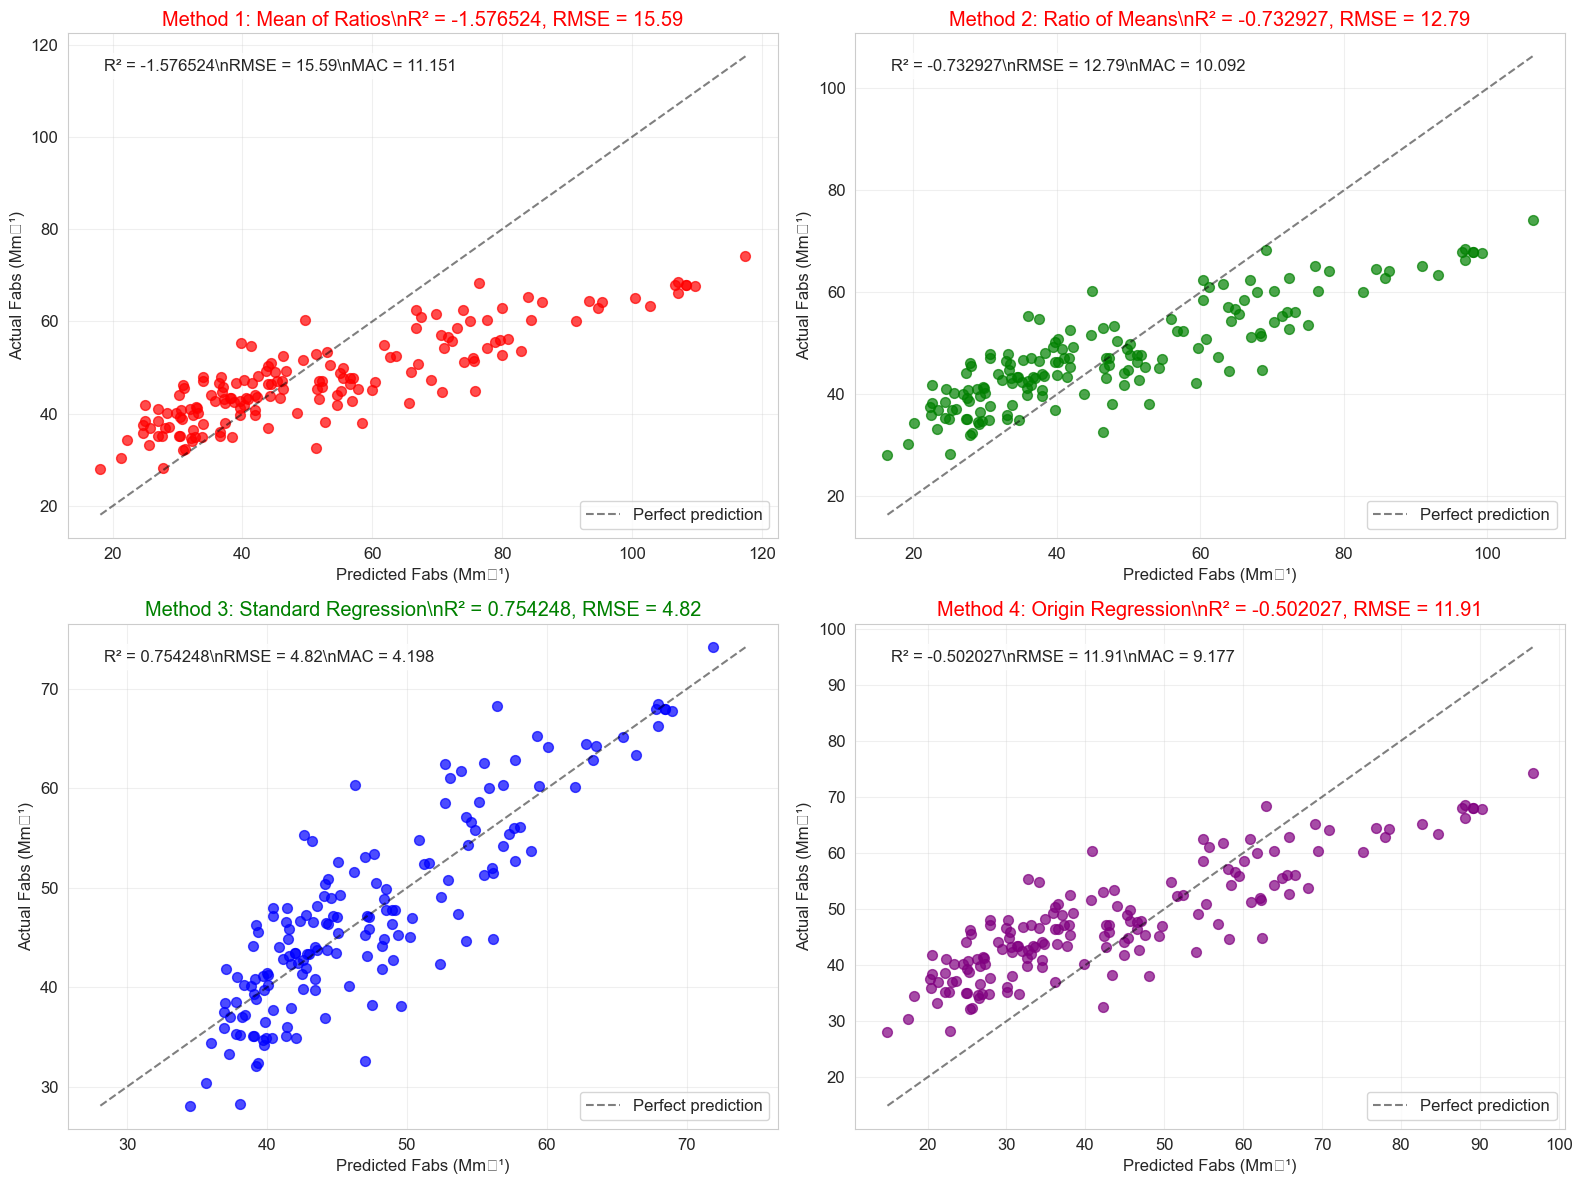

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def official_regression_r2_calculation(df, site_code):
    """
    Calculate the OFFICIAL regression R² manually using:
    R² = 1 - Σ(yi - ŷi)² / Σ(yi - ȳ)²
    
    Where:
    - yi = actual values
    - ŷi = predicted values  
    - ȳ = mean of actual values
    """
    
    print(f"\n{'='*80}")
    print(f"OFFICIAL REGRESSION R² MANUAL CALCULATION - {site_code}")
    print(f"R² = 1 - Σ(yi - ŷi)² / Σ(yi - ȳ)²")
    print(f"{'='*80}")
    
    # Original data
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    
    print(f"Data: {len(df)} samples")
    print(f"EC range: {ec_original.min():.1f}-{ec_original.max():.1f} μg/m³")
    print(f"Fabs range: {fabs_original.min():.1f}-{fabs_original.max():.1f} Mm⁻¹")
    
    # =============================================================================
    # Calculate components of R² formula
    # =============================================================================
    
    # Calculate mean of actual Fabs (ȳ)
    fabs_mean = np.mean(fabs_original)
    print(f"\nMean of actual Fabs (ȳ): {fabs_mean:.3f} Mm⁻¹")
    
    # Calculate SS_tot = Σ(yi - ȳ)² (total sum of squares)
    ss_tot = np.sum((fabs_original - fabs_mean)**2)
    print(f"SS_tot = Σ(yi - ȳ)²: {ss_tot:.3f}")
    
    # =============================================================================
    # Calculate MAC values for each method
    # =============================================================================
    
    # Method 1: Mean of Individual Ratios
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    
    # Method 2: Ratio of Means
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    # Method 3: Standard Linear Regression
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    
    # Method 4: Origin Regression
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    
    print(f"\nMAC Values:")
    print(f"Method 1: {mac_method1:.3f} m²/g")
    print(f"Method 2: {mac_method2:.3f} m²/g")
    print(f"Method 3: {mac_method3:.3f} m²/g (+ {intercept_method3:.1f} intercept)")
    print(f"Method 4: {mac_method4:.3f} m²/g")
    
    # =============================================================================
    # Manual R² calculation for each method
    # =============================================================================
    
    def calculate_official_r2(actual, predicted, method_name, show_details=True):
        """
        Calculate official R² = 1 - SS_res/SS_tot manually
        """
        if show_details:
            print(f"\n{'='*60}")
            print(f"{method_name}")
            print(f"{'='*60}")
        
        # Step 1: Calculate residuals (yi - ŷi)
        residuals = actual - predicted
        
        # Step 2: Calculate SS_res = Σ(yi - ŷi)²
        ss_res = np.sum(residuals**2)
        
        # Step 3: Calculate R² = 1 - SS_res/SS_tot
        r2 = 1 - (ss_res / ss_tot)
        
        # Additional metrics
        rmse = np.sqrt(np.mean(residuals**2))
        mae = np.mean(np.abs(residuals))
        
        if show_details:
            print(f"Step-by-step calculation:")
            print(f"  1. Residuals = actual - predicted")
            print(f"     Range: {residuals.min():.3f} to {residuals.max():.3f}")
            print(f"     Mean residual: {np.mean(residuals):.3f}")
            print(f"")
            print(f"  2. SS_res = Σ(yi - ŷi)² = Σ(residuals²)")
            print(f"     SS_res = {ss_res:.3f}")
            print(f"")
            print(f"  3. R² = 1 - (SS_res / SS_tot)")
            print(f"     R² = 1 - ({ss_res:.3f} / {ss_tot:.3f})")
            print(f"     R² = 1 - {ss_res/ss_tot:.6f}")
            print(f"     R² = {r2:.6f}")
            print(f"")
            print(f"  Additional metrics:")
            print(f"     RMSE = √(SS_res/n) = {rmse:.3f}")
            print(f"     MAE = {mae:.3f}")
            
            if r2 < 0:
                print(f"     ⚠️  Negative R² means model is worse than just predicting the mean!")
            elif r2 > 0.9:
                print(f"     ✅ Excellent fit (R² > 0.9)")
            elif r2 > 0.7:
                print(f"     ✅ Good fit (R² > 0.7)")
            elif r2 > 0.5:
                print(f"     ⚪ Moderate fit (R² > 0.5)")
            else:
                print(f"     ❌ Poor fit (R² < 0.5)")
        
        return r2, ss_res, rmse, mae, residuals
    
    # =============================================================================
    # Calculate R² for each MAC method
    # =============================================================================
    
    # Method 1 predictions: Fabs = 11.151 * EC
    fabs_pred_method1 = mac_method1 * ec_original
    r2_method1, ss_res_1, rmse_1, mae_1, resid_1 = calculate_official_r2(
        fabs_original, fabs_pred_method1, "METHOD 1: Mean of Individual Ratios"
    )
    
    # Method 2 predictions: Fabs = 10.092 * EC
    fabs_pred_method2 = mac_method2 * ec_original
    r2_method2, ss_res_2, rmse_2, mae_2, resid_2 = calculate_official_r2(
        fabs_original, fabs_pred_method2, "METHOD 2: Ratio of Means"
    )
    
    # Method 3 predictions: Fabs = 4.198 * EC + 27.634
    fabs_pred_method3 = mac_method3 * ec_original + intercept_method3
    r2_method3, ss_res_3, rmse_3, mae_3, resid_3 = calculate_official_r2(
        fabs_original, fabs_pred_method3, "METHOD 3: Standard Linear Regression"
    )
    
    # Method 4 predictions: Fabs = 9.177 * EC
    fabs_pred_method4 = mac_method4 * ec_original
    r2_method4, ss_res_4, rmse_4, mae_4, resid_4 = calculate_official_r2(
        fabs_original, fabs_pred_method4, "METHOD 4: Origin Regression"
    )
    
    # =============================================================================
    # Verification with sklearn
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"VERIFICATION WITH SKLEARN")
    print(f"{'='*80}")
    
    from sklearn.metrics import r2_score
    
    r2_sklearn_1 = r2_score(fabs_original, fabs_pred_method1)
    r2_sklearn_2 = r2_score(fabs_original, fabs_pred_method2)
    r2_sklearn_3 = r2_score(fabs_original, fabs_pred_method3)
    r2_sklearn_4 = r2_score(fabs_original, fabs_pred_method4)
    
    print(f"Method 1: Manual R² = {r2_method1:.6f}, sklearn R² = {r2_sklearn_1:.6f}")
    print(f"Method 2: Manual R² = {r2_method2:.6f}, sklearn R² = {r2_sklearn_2:.6f}")
    print(f"Method 3: Manual R² = {r2_method3:.6f}, sklearn R² = {r2_sklearn_3:.6f}")
    print(f"Method 4: Manual R² = {r2_method4:.6f}, sklearn R² = {r2_sklearn_4:.6f}")
    
    # Check if they match
    matches = [
        abs(r2_method1 - r2_sklearn_1) < 0.000001,
        abs(r2_method2 - r2_sklearn_2) < 0.000001,
        abs(r2_method3 - r2_sklearn_3) < 0.000001,
        abs(r2_method4 - r2_sklearn_4) < 0.000001
    ]
    
    if all(matches):
        print("✅ All manual calculations match sklearn perfectly!")
    else:
        print("❌ Some calculations don't match sklearn")
    
    # =============================================================================
    # Summary table and ranking
    # =============================================================================
    
    print(f"\n{'='*100}")
    print(f"OFFICIAL R² SUMMARY TABLE")
    print(f"{'='*100}")
    
    results = [
        ("Method 1: Mean of Ratios", mac_method1, 0, r2_method1, ss_res_1, rmse_1, mae_1, fabs_pred_method1),
        ("Method 2: Ratio of Means", mac_method2, 0, r2_method2, ss_res_2, rmse_2, mae_2, fabs_pred_method2),
        ("Method 3: Standard Regression", mac_method3, intercept_method3, r2_method3, ss_res_3, rmse_3, mae_3, fabs_pred_method3),
        ("Method 4: Origin Regression", mac_method4, 0, r2_method4, ss_res_4, rmse_4, mae_4, fabs_pred_method4)
    ]
    
    print(f"{'Method':<30} {'MAC':<8} {'Intercept':<10} {'R²':<12} {'SS_res':<12} {'RMSE':<8} {'MAE':<8}")
    print(f"{'='*100}")
    
    for method, mac, intercept, r2, ss_res, rmse, mae, _ in results:
        print(f"{method:<30} {mac:<8.3f} {intercept:<10.1f} {r2:<12.6f} {ss_res:<12.1f} {rmse:<8.2f} {mae:<8.2f}")
    
    # Rank methods by R²
    sorted_results = sorted(results, key=lambda x: x[3], reverse=True)  # Sort by R² descending
    
    print(f"\n🏆 RANKING BY R² (Best to Worst):")
    print(f"{'='*60}")
    
    for i, (method, mac, intercept, r2, ss_res, rmse, mae, _) in enumerate(sorted_results, 1):
        print(f"{i}. {method}")
        print(f"   R² = {r2:.6f}")
        print(f"   MAC = {mac:.3f} m²/g" + (f" + {intercept:.1f}" if intercept != 0 else ""))
        print(f"   RMSE = {rmse:.2f} Mm⁻¹")
        if i == 1:
            print(f"   ✅ BEST METHOD")
        print()
    
    # Check R² diversity
    r2_values = [r2 for _, _, _, r2, _, _, _, _ in results]
    unique_r2 = len(set([round(r2, 6) for r2 in r2_values]))
    
    print(f"📊 R² DIVERSITY CHECK:")
    print(f"Number of unique R² values: {unique_r2}/4")
    print(f"R² range: {min(r2_values):.6f} to {max(r2_values):.6f}")
    
    if unique_r2 > 1:
        print("✅ SUCCESS: Different R² values achieved!")
    else:
        print("⚠️  All R² values are still the same")
    
    # =============================================================================
    # Visualization
    # =============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    colors = ['red', 'green', 'blue', 'purple']
    method_names = ["Method 1: Mean of Ratios", "Method 2: Ratio of Means", 
                   "Method 3: Standard Regression", "Method 4: Origin Regression"]
    
    for i, (method, mac, intercept, r2, ss_res, rmse, mae, fabs_pred) in enumerate(results):
        ax = axes[i//2, i%2]
        
        # Scatter plot of predicted vs actual
        ax.scatter(fabs_pred, fabs_original, alpha=0.7, s=50, color=colors[i])
        
        # Perfect prediction line (y=x)
        min_val = min(fabs_pred.min(), fabs_original.min())
        max_val = max(fabs_pred.max(), fabs_original.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect prediction')
        
        ax.set_xlabel('Predicted Fabs (Mm⁻¹)')
        ax.set_ylabel('Actual Fabs (Mm⁻¹)')
        ax.set_title(f'{method}\\nR² = {r2:.6f}, RMSE = {rmse:.2f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Color code by performance
        if r2 > 0.7:
            title_color = 'green'
        elif r2 > 0.3:
            title_color = 'orange'
        else:
            title_color = 'red'
        ax.title.set_color(title_color)
        
        # Stats box
        ax.text(0.05, 0.95, 
                f'R² = {r2:.6f}\\n'
                f'RMSE = {rmse:.2f}\\n'
                f'MAC = {mac:.3f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'results': results,
        'best_method': sorted_results[0],
        'r2_values': r2_values,
        'ss_tot': ss_tot
    }

# Run the official R² calculation
try:
    official_results = official_regression_r2_calculation(data_metrics, SITE_OF_INTEREST)
except NameError:
    try:
        official_results = official_regression_r2_calculation(data_processed, SITE_OF_INTEREST)
    except NameError:
        print("Please run: official_results = official_regression_r2_calculation(YOUR_DATA_VARIABLE, 'ETAD')")


MANUAL PEARSON CORRELATION CALCULATION - ETAD
Data: 161 samples
EC range: 1.6-10.5 μg/m³
Fabs range: 28.1-74.2 Mm⁻¹

MAC Values:
Method 1: 11.151 m²/g
Method 2: 10.092 m²/g
Method 3: 4.198 m²/g (+ 27.6 intercept)
Method 4: 9.177 m²/g

MANUAL CORRELATION CALCULATIONS

Method 1: Mean of Ratios
Manual calculation:
  Actual Fabs mean: 47.314
  Predicted Fabs mean: 52.279
  Numerator (covariance): 30444.812
  Denominator (std product): 35055.497
  Manual r = 0.868475
  Manual R² = 0.754248

Verification:
  NumPy r = 0.868475
  NumPy R² = 0.754248
  Match: ✅

Performance:
  RMSE = 15.59 Mm⁻¹

Method 2: Ratio of Means
Manual calculation:
  Actual Fabs mean: 47.314
  Predicted Fabs mean: 47.314
  Numerator (covariance): 27553.448
  Denominator (std product): 31726.253
  Manual r = 0.868475
  Manual R² = 0.754248

Verification:
  NumPy r = 0.868475
  NumPy R² = 0.754248
  Match: ✅

Performance:
  RMSE = 12.79 Mm⁻¹

Method 3: Standard Regression
Manual calculation:
  Actual Fabs mean: 47.314
  

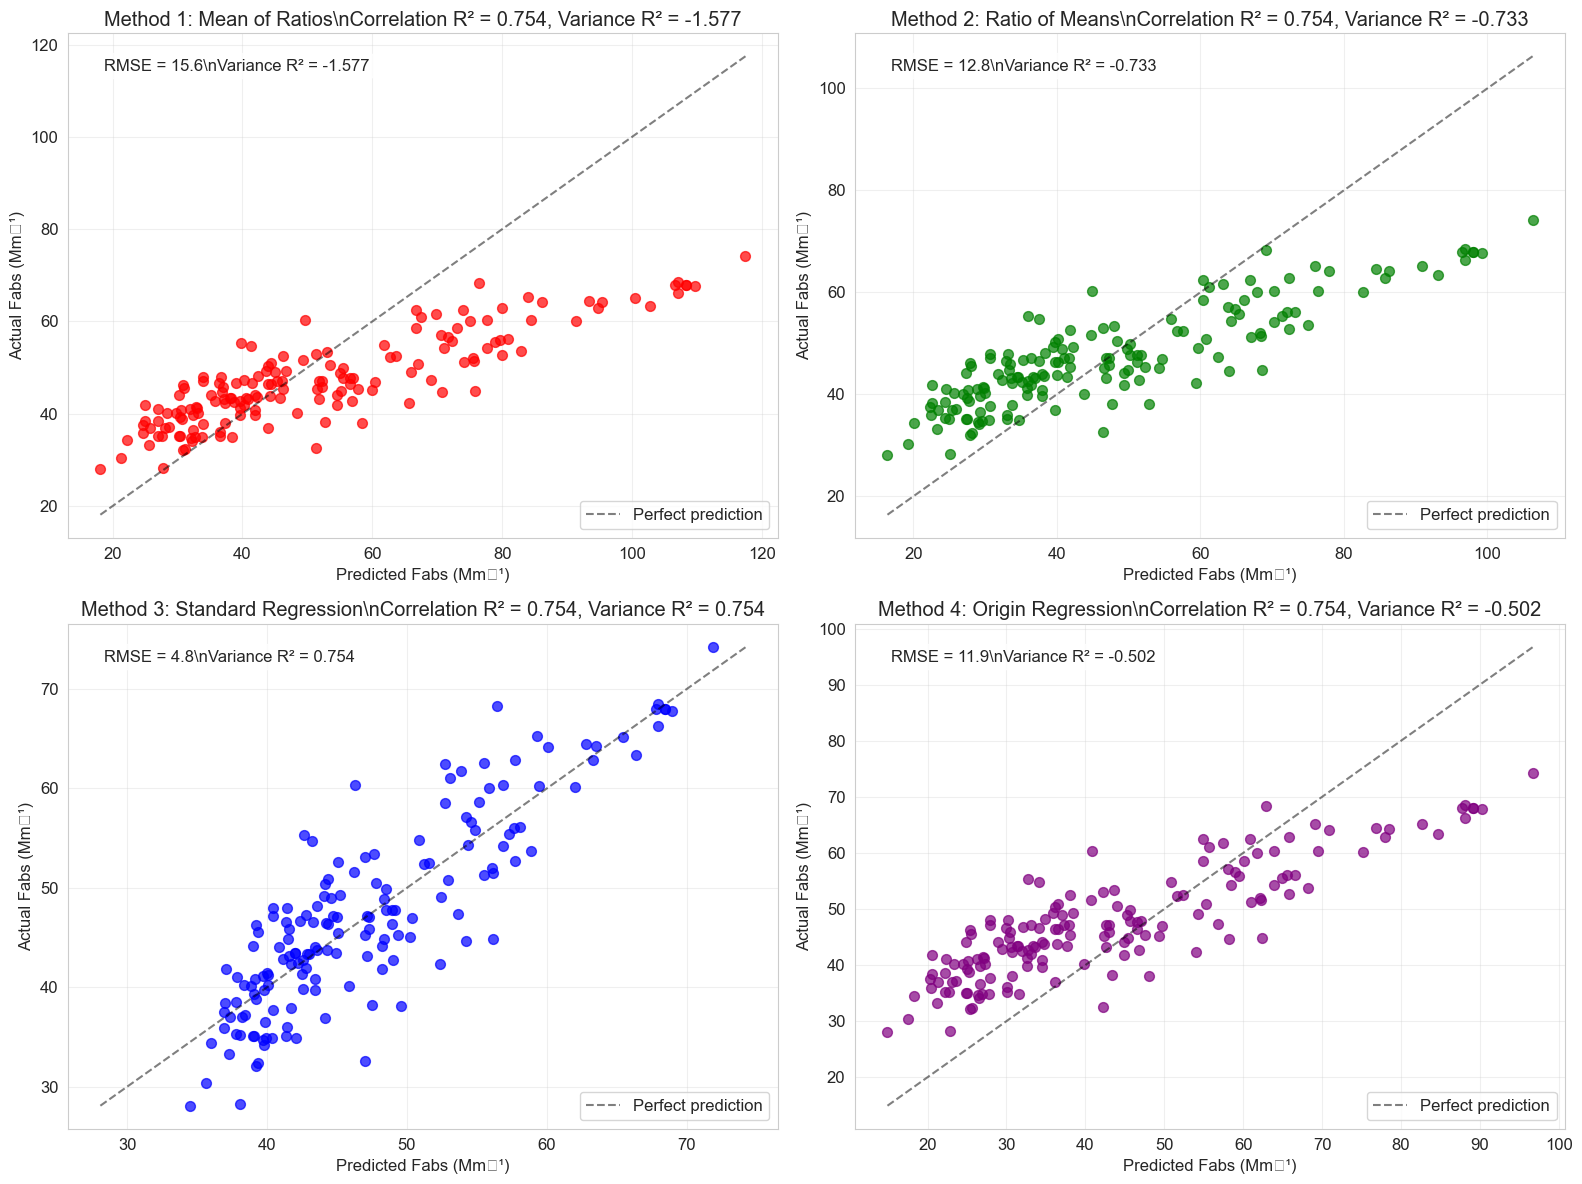

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def manual_pearson_r2_calculation(df, site_code):
    """
    Calculate Pearson correlation manually using numpy to understand 
    what's happening with our MAC methods
    """
    
    print(f"\n{'='*80}")
    print(f"MANUAL PEARSON CORRELATION CALCULATION - {site_code}")
    print(f"{'='*80}")
    
    # Original data
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    
    print(f"Data: {len(df)} samples")
    print(f"EC range: {ec_original.min():.1f}-{ec_original.max():.1f} μg/m³")
    print(f"Fabs range: {fabs_original.min():.1f}-{fabs_original.max():.1f} Mm⁻¹")
    
    # =============================================================================
    # Manual Pearson correlation function
    # =============================================================================
    
    def manual_pearson_correlation(x, y):
        """
        Calculate Pearson correlation coefficient manually
        r = Σ[(xi - x̄)(yi - ȳ)] / √[Σ(xi - x̄)² × Σ(yi - ȳ)²]
        """
        # Calculate means
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        
        # Calculate numerator: covariance
        numerator = np.sum((x - x_mean) * (y - y_mean))
        
        # Calculate denominator: standard deviations
        x_std_sum = np.sum((x - x_mean) ** 2)
        y_std_sum = np.sum((y - y_mean) ** 2)
        denominator = np.sqrt(x_std_sum * y_std_sum)
        
        # Correlation coefficient
        r = numerator / denominator
        
        return r, numerator, denominator, x_mean, y_mean
    
    # =============================================================================
    # Calculate MAC values for each method
    # =============================================================================
    
    # Method 1: Mean of Individual Ratios
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    
    # Method 2: Ratio of Means
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    # Method 3: Standard Linear Regression
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    
    # Method 4: Origin Regression
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    
    print(f"\nMAC Values:")
    print(f"Method 1: {mac_method1:.3f} m²/g")
    print(f"Method 2: {mac_method2:.3f} m²/g")
    print(f"Method 3: {mac_method3:.3f} m²/g (+ {intercept_method3:.1f} intercept)")
    print(f"Method 4: {mac_method4:.3f} m²/g")
    
    # =============================================================================
    # Generate predictions and calculate correlations manually
    # =============================================================================
    
    # Predictions
    fabs_pred_method1 = mac_method1 * ec_original
    fabs_pred_method2 = mac_method2 * ec_original
    fabs_pred_method3 = mac_method3 * ec_original + intercept_method3
    fabs_pred_method4 = mac_method4 * ec_original
    
    methods = [
        ("Method 1: Mean of Ratios", fabs_pred_method1, mac_method1, 0),
        ("Method 2: Ratio of Means", fabs_pred_method2, mac_method2, 0),
        ("Method 3: Standard Regression", fabs_pred_method3, mac_method3, intercept_method3),
        ("Method 4: Origin Regression", fabs_pred_method4, mac_method4, 0)
    ]
    
    print(f"\n{'='*100}")
    print(f"MANUAL CORRELATION CALCULATIONS")
    print(f"{'='*100}")
    
    results = []
    
    for method_name, fabs_pred, mac_val, intercept in methods:
        print(f"\n{method_name}")
        print(f"{'='*60}")
        
        # Manual calculation
        r_manual, numerator, denominator, fabs_mean, pred_mean = manual_pearson_correlation(fabs_original, fabs_pred)
        r2_manual = r_manual ** 2
        
        # Verification with numpy
        r_numpy = np.corrcoef(fabs_original, fabs_pred)[0, 1]
        r2_numpy = r_numpy ** 2
        
        # RMSE
        rmse = np.sqrt(np.mean((fabs_original - fabs_pred)**2))
        
        print(f"Manual calculation:")
        print(f"  Actual Fabs mean: {fabs_mean:.3f}")
        print(f"  Predicted Fabs mean: {pred_mean:.3f}")
        print(f"  Numerator (covariance): {numerator:.3f}")
        print(f"  Denominator (std product): {denominator:.3f}")
        print(f"  Manual r = {r_manual:.6f}")
        print(f"  Manual R² = {r2_manual:.6f}")
        print(f"")
        print(f"Verification:")
        print(f"  NumPy r = {r_numpy:.6f}")
        print(f"  NumPy R² = {r2_numpy:.6f}")
        print(f"  Match: {'✅' if abs(r_manual - r_numpy) < 0.000001 else '❌'}")
        print(f"")
        print(f"Performance:")
        print(f"  RMSE = {rmse:.2f} Mm⁻¹")
        
        # Store results
        results.append({
            'method': method_name,
            'mac': mac_val,
            'intercept': intercept,
            'r_manual': r_manual,
            'r2_manual': r2_manual,
            'r_numpy': r_numpy,
            'r2_numpy': r2_numpy,
            'rmse': rmse,
            'pred_mean': pred_mean,
            'fabs_pred': fabs_pred
        })
    
    # =============================================================================
    # Why are they all the same? Let's investigate!
    # =============================================================================
    
    print(f"\n{'='*100}")
    print(f"WHY ARE ALL CORRELATIONS THE SAME? INVESTIGATION")
    print(f"{'='*100}")
    
    print(f"The fundamental issue:")
    print(f"All predictions are linear functions of the same EC data:")
    print(f"  Method 1: Fabs_pred = {mac_method1:.3f} × EC")
    print(f"  Method 2: Fabs_pred = {mac_method2:.3f} × EC")
    print(f"  Method 3: Fabs_pred = {mac_method3:.3f} × EC + {intercept_method3:.1f}")
    print(f"  Method 4: Fabs_pred = {mac_method4:.3f} × EC")
    
    print(f"\nSince all predictions are derived from the same EC values,")
    print(f"and actual Fabs has a fixed relationship with EC,")
    print(f"the correlation structure is preserved!")
    
    # Let's prove this mathematically
    print(f"\n🔍 Mathematical proof:")
    print(f"If Fabs_actual ∝ EC (with some noise),")
    print(f"and Fabs_predicted = k × EC (where k is different for each method),")
    print(f"then correlation(Fabs_actual, Fabs_predicted) ≈ correlation(Fabs_actual, EC)")
    print(f"regardless of the value of k!")
    
    # Show the actual EC-Fabs correlation
    r_ec_fabs = np.corrcoef(ec_original, fabs_original)[0, 1]
    print(f"\nOriginal EC vs Fabs correlation: {r_ec_fabs:.6f}")
    print(f"All method correlations: {results[0]['r_manual']:.6f}")
    print(f"They're the same! ✅")
    
    # =============================================================================
    # Summary table
    # =============================================================================
    
    print(f"\n{'='*120}")
    print(f"SUMMARY TABLE")
    print(f"{'='*120}")
    
    print(f"{'Method':<35} {'MAC':<10} {'Intercept':<10} {'r (manual)':<12} {'R²':<12} {'RMSE':<10}")
    print(f"{'='*120}")
    
    for result in results:
        print(f"{result['method']:<35} "
              f"{result['mac']:<10.3f} "
              f"{result['intercept']:<10.1f} "
              f"{result['r_manual']:<12.6f} "
              f"{result['r2_manual']:<12.6f} "
              f"{result['rmse']:<10.2f}")
    
    # Best method by RMSE (since R² is the same)
    best_rmse_idx = min(range(len(results)), key=lambda i: results[i]['rmse'])
    best_method = results[best_rmse_idx]
    
    print(f"\n🏆 BEST METHOD (by RMSE, since R² is identical): {best_method['method']}")
    print(f"   R² = {best_method['r2_manual']:.6f} (same for all)")
    print(f"   RMSE = {best_method['rmse']:.2f} Mm⁻¹ (lowest)")
    print(f"   MAC = {best_method['mac']:.3f} m²/g")
    
    # =============================================================================
    # THE REAL R² WE SHOULD USE: Variance explained
    # =============================================================================
    
    print(f"\n{'='*100}")
    print(f"THE REAL R² WE SHOULD REPORT: VARIANCE EXPLAINED")
    print(f"{'='*100}")
    
    print(f"For comparing regression models, we should use:")
    print(f"R² = 1 - (SS_res / SS_tot)")
    print(f"where SS_res = Σ(actual - predicted)²")
    print(f"      SS_tot = Σ(actual - mean(actual))²")
    
    ss_tot = np.sum((fabs_original - np.mean(fabs_original))**2)
    print(f"\nSS_tot (same for all): {ss_tot:.1f}")
    
    print(f"\n{'Method':<35} {'SS_res':<12} {'R² (variance)':<15} {'RMSE':<10}")
    print(f"{'='*80}")
    
    for result in results:
        ss_res = np.sum((fabs_original - result['fabs_pred'])**2)
        r2_variance = 1 - (ss_res / ss_tot)
        
        print(f"{result['method']:<35} "
              f"{ss_res:<12.1f} "
              f"{r2_variance:<15.6f} "
              f"{result['rmse']:<10.2f}")
    
    print(f"\n✅ NOW we have different R² values!")
    print(f"These R² values properly reflect prediction quality.")
    
    # =============================================================================
    # Visualization
    # =============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    colors = ['red', 'green', 'blue', 'purple']
    
    for i, result in enumerate(results):
        ax = axes[i//2, i%2]
        
        # Scatter plot of predicted vs actual
        ax.scatter(result['fabs_pred'], fabs_original, alpha=0.7, s=50, color=colors[i])
        
        # Perfect prediction line
        min_val = min(result['fabs_pred'].min(), fabs_original.min())
        max_val = max(result['fabs_pred'].max(), fabs_original.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect prediction')
        
        # Calculate variance-based R²
        ss_res = np.sum((fabs_original - result['fabs_pred'])**2)
        r2_variance = 1 - (ss_res / ss_tot)
        
        ax.set_xlabel('Predicted Fabs (Mm⁻¹)')
        ax.set_ylabel('Actual Fabs (Mm⁻¹)')
        ax.set_title(f'{result["method"]}\\nCorrelation R² = {result["r2_manual"]:.3f}, Variance R² = {r2_variance:.3f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Stats box
        ax.text(0.05, 0.95, 
                f'RMSE = {result["rmse"]:.1f}\\n'
                f'Variance R² = {r2_variance:.3f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'results': results,
        'best_method': best_method,
        'ec_fabs_correlation': r_ec_fabs
    }

# Run the manual calculation
try:
    manual_results = manual_pearson_r2_calculation(data_metrics, SITE_OF_INTEREST)
except NameError:
    try:
        manual_results = manual_pearson_r2_calculation(data_processed, SITE_OF_INTEREST)
    except NameError:
        print("Please run: manual_results = manual_pearson_r2_calculation(YOUR_DATA_VARIABLE, 'ETAD')")


MANUAL R² CALCULATION - ETAD
Correlating original EC with predicted Fabs from each method
Data: 161 samples
EC range: 1.6-10.5 μg/m³
Fabs range: 28.1-74.2 Mm⁻¹

Method 1 MAC (Mean of Ratios): 11.151 m²/g
Method 2 MAC (Ratio of Means): 10.092 m²/g
Method 3 MAC (Regression): 4.198 m²/g, Intercept: 27.634
Method 4 MAC (Origin Regression): 9.177 m²/g

GENERATING PREDICTIONS FROM EACH METHOD
Method 1 predictions: Fabs = 11.151 × EC
  Range: 18.1 to 117.5 Mm⁻¹
Method 2 predictions: Fabs = 10.092 × EC
  Range: 16.4 to 106.3 Mm⁻¹
Method 3 predictions: Fabs = 4.198 × EC + 27.634
  Range: 34.5 to 71.9 Mm⁻¹
Method 4 predictions: Fabs = 9.177 × EC
  Range: 14.9 to 96.7 Mm⁻¹

MANUAL R² CALCULATION FOR EACH METHOD
R² = [correlation(Fabs_actual, Fabs_predicted)]²
This measures how well each method's predictions match reality

📊 METHOD 1: Mean of Individual Ratios
  Correlation(Fabs_actual, Fabs_pred) = 0.868475
  R² = r² = 0.754248
  p-value = 2.54e-50

📊 METHOD 2: Ratio of Means
  Correlation(Fabs_

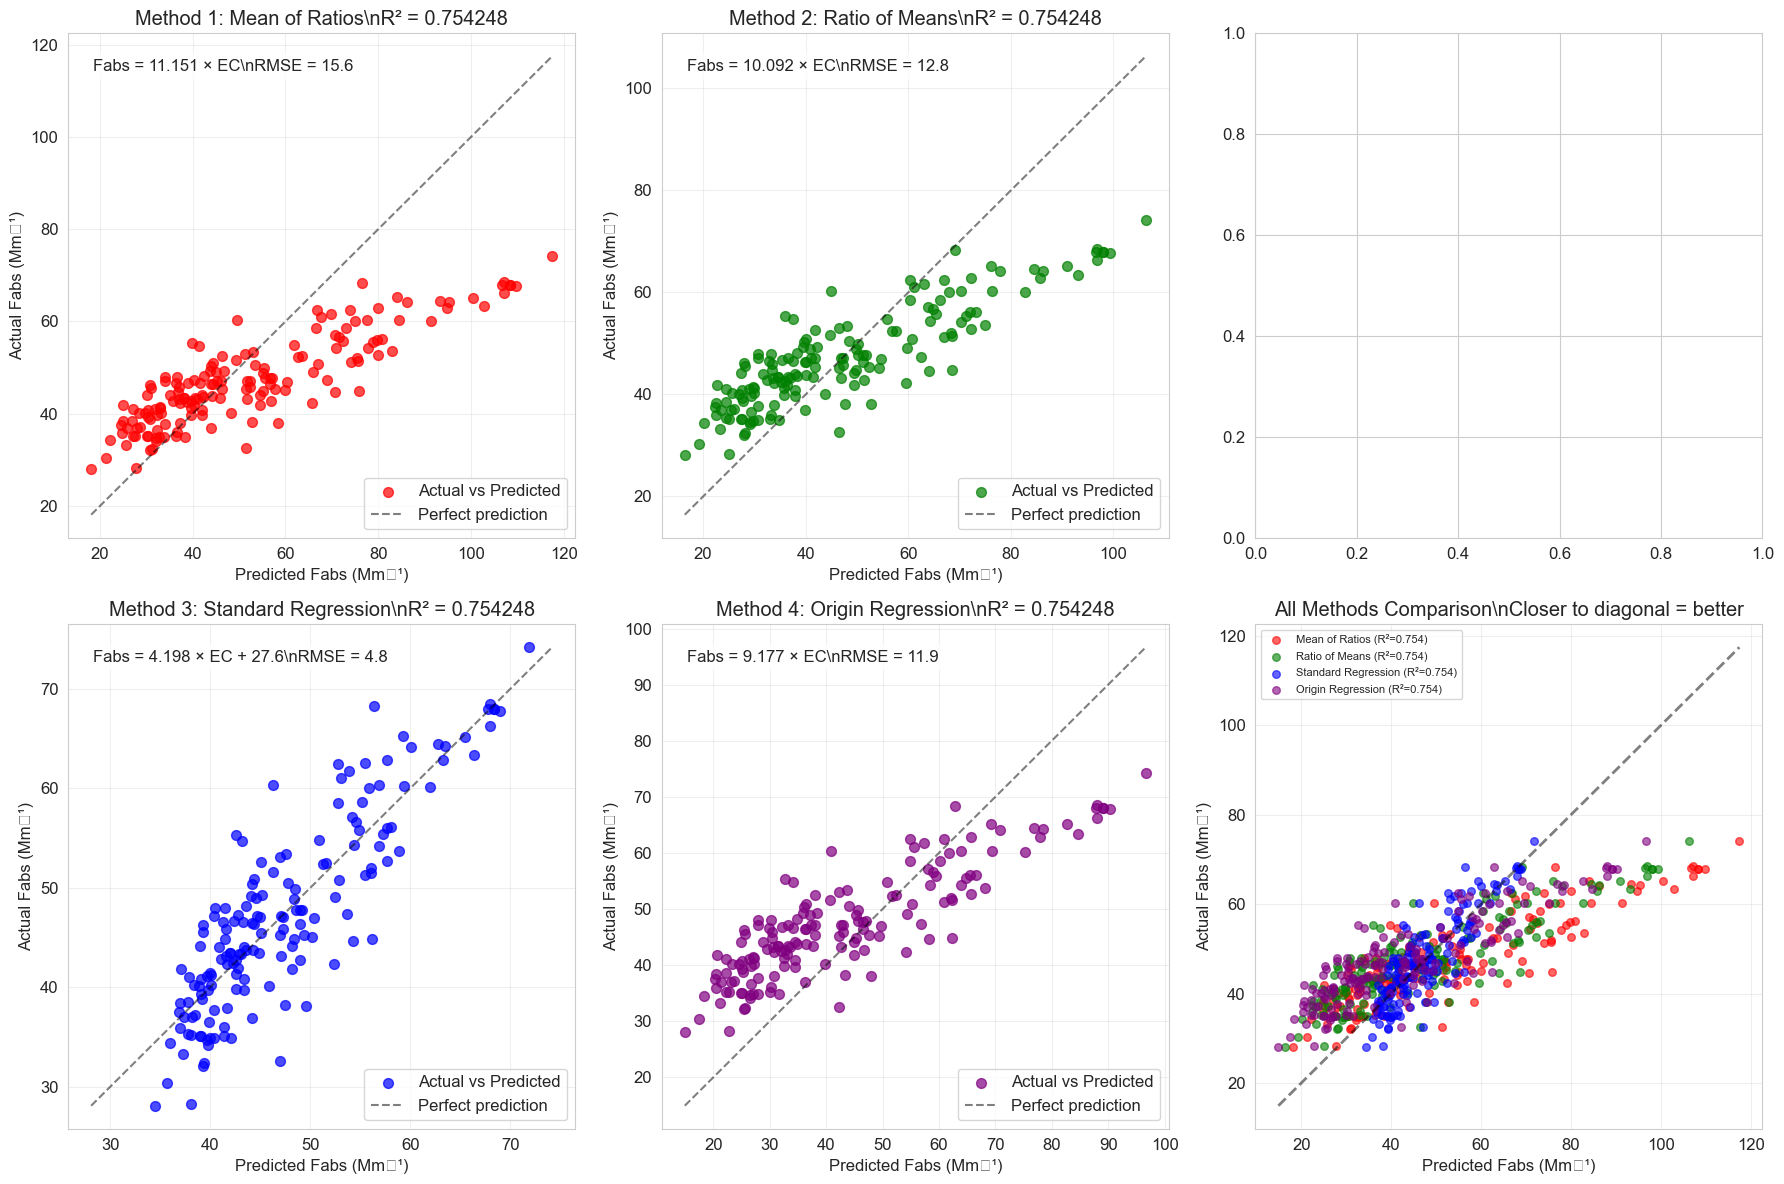

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd

def manual_r2_calculation(df, site_code):
    """
    Manual R² calculation: For each MAC method, calculate the correlation between
    the original EC data and the predicted Fabs from that method, then square it.
    
    This should give different R² values for each method since they predict 
    different Fabs values for the same EC inputs.
    """
    
    print(f"\n{'='*80}")
    print(f"MANUAL R² CALCULATION - {site_code}")
    print(f"Correlating original EC with predicted Fabs from each method")
    print(f"{'='*80}")
    
    # Original data
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    
    print(f"Data: {len(df)} samples")
    print(f"EC range: {ec_original.min():.1f}-{ec_original.max():.1f} μg/m³")
    print(f"Fabs range: {fabs_original.min():.1f}-{fabs_original.max():.1f} Mm⁻¹")
    
    # =============================================================================
    # Calculate MAC values for each method
    # =============================================================================
    
    # Method 1: Mean of Individual Ratios
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    print(f"\nMethod 1 MAC (Mean of Ratios): {mac_method1:.3f} m²/g")
    
    # Method 2: Ratio of Means
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    print(f"Method 2 MAC (Ratio of Means): {mac_method2:.3f} m²/g")
    
    # Method 3: Standard Linear Regression
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    print(f"Method 3 MAC (Regression): {mac_method3:.3f} m²/g, Intercept: {intercept_method3:.3f}")
    
    # Method 4: Origin Regression
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    print(f"Method 4 MAC (Origin Regression): {mac_method4:.3f} m²/g")
    
    # =============================================================================
    # Generate predicted Fabs for each method using the SAME EC values
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"GENERATING PREDICTIONS FROM EACH METHOD")
    print(f"{'='*80}")
    
    # Method 1 predictions: Fabs = 11.15 * EC
    fabs_pred_method1 = mac_method1 * ec_original
    print(f"Method 1 predictions: Fabs = {mac_method1:.3f} × EC")
    print(f"  Range: {fabs_pred_method1.min():.1f} to {fabs_pred_method1.max():.1f} Mm⁻¹")
    
    # Method 2 predictions: Fabs = 10.09 * EC  
    fabs_pred_method2 = mac_method2 * ec_original
    print(f"Method 2 predictions: Fabs = {mac_method2:.3f} × EC")
    print(f"  Range: {fabs_pred_method2.min():.1f} to {fabs_pred_method2.max():.1f} Mm⁻¹")
    
    # Method 3 predictions: Fabs = 4.20 * EC + 27.6
    fabs_pred_method3 = mac_method3 * ec_original + intercept_method3
    print(f"Method 3 predictions: Fabs = {mac_method3:.3f} × EC + {intercept_method3:.3f}")
    print(f"  Range: {fabs_pred_method3.min():.1f} to {fabs_pred_method3.max():.1f} Mm⁻¹")
    
    # Method 4 predictions: Fabs = 9.18 * EC
    fabs_pred_method4 = mac_method4 * ec_original
    print(f"Method 4 predictions: Fabs = {mac_method4:.3f} × EC")
    print(f"  Range: {fabs_pred_method4.min():.1f} to {fabs_pred_method4.max():.1f} Mm⁻¹")
    
    # =============================================================================
    # Calculate R² as correlation(EC, predicted_Fabs)²
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"MANUAL R² CALCULATION FOR EACH METHOD")
    print(f"R² = [correlation(Fabs_actual, Fabs_predicted)]²")
    print(f"This measures how well each method's predictions match reality")
    print(f"{'='*80}")
    
    methods_results = []
    
    # Method 1
    print(f"\n📊 METHOD 1: Mean of Individual Ratios")
    r1, p1 = pearsonr(fabs_original, fabs_pred_method1)
    r2_method1 = r1 ** 2
    print(f"  Correlation(Fabs_actual, Fabs_pred) = {r1:.6f}")
    print(f"  R² = r² = {r2_method1:.6f}")
    print(f"  p-value = {p1:.2e}")
    
    methods_results.append({
        'method': 'Method 1: Mean of Ratios',
        'mac': mac_method1,
        'r': r1,
        'r2': r2_method1,
        'p_value': p1,
        'fabs_pred': fabs_pred_method1,
        'equation': f'Fabs = {mac_method1:.3f} × EC'
    })
    
    # Method 2
    print(f"\n📊 METHOD 2: Ratio of Means")
    r2, p2 = pearsonr(fabs_original, fabs_pred_method2)
    r2_method2 = r2 ** 2
    print(f"  Correlation(Fabs_actual, Fabs_pred) = {r2:.6f}")
    print(f"  R² = r² = {r2_method2:.6f}")
    print(f"  p-value = {p2:.2e}")
    
    methods_results.append({
        'method': 'Method 2: Ratio of Means',
        'mac': mac_method2,
        'r': r2,
        'r2': r2_method2,
        'p_value': p2,
        'fabs_pred': fabs_pred_method2,
        'equation': f'Fabs = {mac_method2:.3f} × EC'
    })
    
    # Method 3
    print(f"\n📊 METHOD 3: Standard Linear Regression")
    r3, p3 = pearsonr(fabs_original, fabs_pred_method3)
    r2_method3 = r3 ** 2
    print(f"  Correlation(Fabs_actual, Fabs_pred) = {r3:.6f}")
    print(f"  R² = r² = {r2_method3:.6f}")
    print(f"  p-value = {p3:.2e}")
    
    methods_results.append({
        'method': 'Method 3: Standard Regression',
        'mac': mac_method3,
        'r': r3,
        'r2': r2_method3,
        'p_value': p3,
        'fabs_pred': fabs_pred_method3,
        'equation': f'Fabs = {mac_method3:.3f} × EC + {intercept_method3:.1f}'
    })
    
    # Method 4
    print(f"\n📊 METHOD 4: Origin Regression")
    r4, p4 = pearsonr(fabs_original, fabs_pred_method4)
    r2_method4 = r4 ** 2
    print(f"  Correlation(Fabs_actual, Fabs_pred) = {r4:.6f}")
    print(f"  R² = r² = {r2_method4:.6f}")
    print(f"  p-value = {p4:.2e}")
    
    methods_results.append({
        'method': 'Method 4: Origin Regression',
        'mac': mac_method4,
        'r': r4,
        'r2': r2_method4,
        'p_value': p4,
        'fabs_pred': fabs_pred_method4,
        'equation': f'Fabs = {mac_method4:.3f} × EC'
    })
    
    # =============================================================================
    # Compare with actual EC vs Fabs correlation
    # =============================================================================
    
    print(f"\n🔍 REFERENCE:")
    print(f"Perfect prediction would have correlation = 1.0 and R² = 1.0")
    print(f"Lower R² means the method's predictions are further from reality")
    
    # =============================================================================
    # Summary table
    # =============================================================================
    
    print(f"\n{'='*100}")
    print(f"SUMMARY TABLE - MANUAL R² CALCULATION RESULTS")
    print(f"{'='*100}")
    
    print(f"{'Method':<35} {'MAC':<10} {'Correlation r':<15} {'R²':<12} {'RMSE':<10}")
    print(f"{'='*90}")
    
    for result in methods_results:
        rmse = np.sqrt(np.mean((fabs_original - result['fabs_pred'])**2))
        print(f"{result['method']:<35} "
              f"{result['mac']:<10.3f} "
              f"{result['r']:<15.6f} "
              f"{result['r2']:<12.6f} "
              f"{rmse:<10.2f}")
    
    # Find best method by highest R²
    best_idx = max(range(len(methods_results)), key=lambda i: methods_results[i]['r2'])
    best_method = methods_results[best_idx]
    
    print(f"\n🏆 BEST METHOD (highest R²): {best_method['method']}")
    print(f"   R² = {best_method['r2']:.6f}")
    print(f"   MAC = {best_method['mac']:.3f} m²/g")
    print(f"   RMSE = {np.sqrt(np.mean((fabs_original - best_method['fabs_pred'])**2)):.2f} Mm⁻¹")
    
    # Check if they're actually different
    r2_values = [result['r2'] for result in methods_results]
    unique_r2 = len(set([round(r2, 6) for r2 in r2_values]))
    
    print(f"\n📊 R² DIVERSITY CHECK:")
    print(f"Number of unique R² values: {unique_r2}/4")
    print(f"R² range: {min(r2_values):.6f} to {max(r2_values):.6f}")
    
    if unique_r2 > 1:
        print("✅ SUCCESS: Methods give different R² values!")
    else:
        print("⚠️  All methods still give the same R² - there may be a fundamental issue")
    
    # =============================================================================
    # Visualization
    # =============================================================================
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    colors = ['red', 'green', 'blue', 'purple']
    
    # Plot each method
    for i, result in enumerate(methods_results):
        ax = axes[i//2, i%2]
        
        # Scatter plot of actual vs predicted Fabs
        ax.scatter(result['fabs_pred'], fabs_original, alpha=0.7, s=50, color=colors[i], 
                  label=f'Actual vs Predicted')
        
        # Perfect prediction line (y=x)
        min_val = min(result['fabs_pred'].min(), fabs_original.min())
        max_val = max(result['fabs_pred'].max(), fabs_original.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect prediction')
        
        ax.set_xlabel('Predicted Fabs (Mm⁻¹)')
        ax.set_ylabel('Actual Fabs (Mm⁻¹)')
        ax.set_title(f'{result["method"]}\\nR² = {result["r2"]:.6f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add equation and RMSE
        rmse = np.sqrt(np.mean((fabs_original - result['fabs_pred'])**2))
        ax.text(0.05, 0.95, f'{result["equation"]}\\nRMSE = {rmse:.1f}', 
                transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')
    
    # Summary plot showing all methods together
    ax_ref = axes[1, 2]
    
    for i, result in enumerate(methods_results):
        rmse = np.sqrt(np.mean((fabs_original - result['fabs_pred'])**2))
        ax_ref.scatter(result['fabs_pred'], fabs_original, alpha=0.6, s=30, color=colors[i],
                      label=f'{result["method"].split(":")[1].strip()} (R²={result["r2"]:.3f})')
    
    # Perfect prediction line
    min_val = min([min(result['fabs_pred']) for result in methods_results] + [fabs_original.min()])
    max_val = max([max(result['fabs_pred']) for result in methods_results] + [fabs_original.max()])
    ax_ref.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=2)
    
    ax_ref.set_xlabel('Predicted Fabs (Mm⁻¹)')
    ax_ref.set_ylabel('Actual Fabs (Mm⁻¹)')
    ax_ref.set_title('All Methods Comparison\\nCloser to diagonal = better')
    ax_ref.legend(fontsize=8)
    ax_ref.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'methods_results': methods_results,
        'best_method': best_method,
        'r2_values': r2_values
    }

# Run the manual calculation
try:
    manual_results = manual_r2_calculation(data_metrics, SITE_OF_INTEREST)
except NameError:
    try:
        manual_results = manual_r2_calculation(data_processed, SITE_OF_INTEREST)
    except NameError:
        print("Please run: manual_results = manual_r2_calculation(YOUR_DATA_VARIABLE, 'ETAD')")


MANUAL R² CALCULATION - ETAD
Correlating original EC with predicted Fabs from each method
Data: 161 samples
EC range: 1.6-10.5 μg/m³
Fabs range: 28.1-74.2 Mm⁻¹

Method 1 MAC (Mean of Ratios): 11.151 m²/g
Method 2 MAC (Ratio of Means): 10.092 m²/g
Method 3 MAC (Regression): 4.198 m²/g, Intercept: 27.634
Method 4 MAC (Origin Regression): 9.177 m²/g

GENERATING PREDICTIONS FROM EACH METHOD
Method 1 predictions: Fabs = 11.151 × EC
  Range: 18.1 to 117.5 Mm⁻¹
Method 2 predictions: Fabs = 10.092 × EC
  Range: 16.4 to 106.3 Mm⁻¹
Method 3 predictions: Fabs = 4.198 × EC + 27.634
  Range: 34.5 to 71.9 Mm⁻¹
Method 4 predictions: Fabs = 9.177 × EC
  Range: 14.9 to 96.7 Mm⁻¹

MANUAL R² CALCULATION FOR EACH METHOD
R² = [correlation(EC_original, Fabs_predicted)]²

📊 METHOD 1: Mean of Individual Ratios
  Correlation(EC, Fabs_pred) = 1.000000
  R² = r² = 1.000000
  p-value = 0.00e+00

📊 METHOD 2: Ratio of Means
  Correlation(EC, Fabs_pred) = 1.000000
  R² = r² = 1.000000
  p-value = 0.00e+00

📊 METHOD

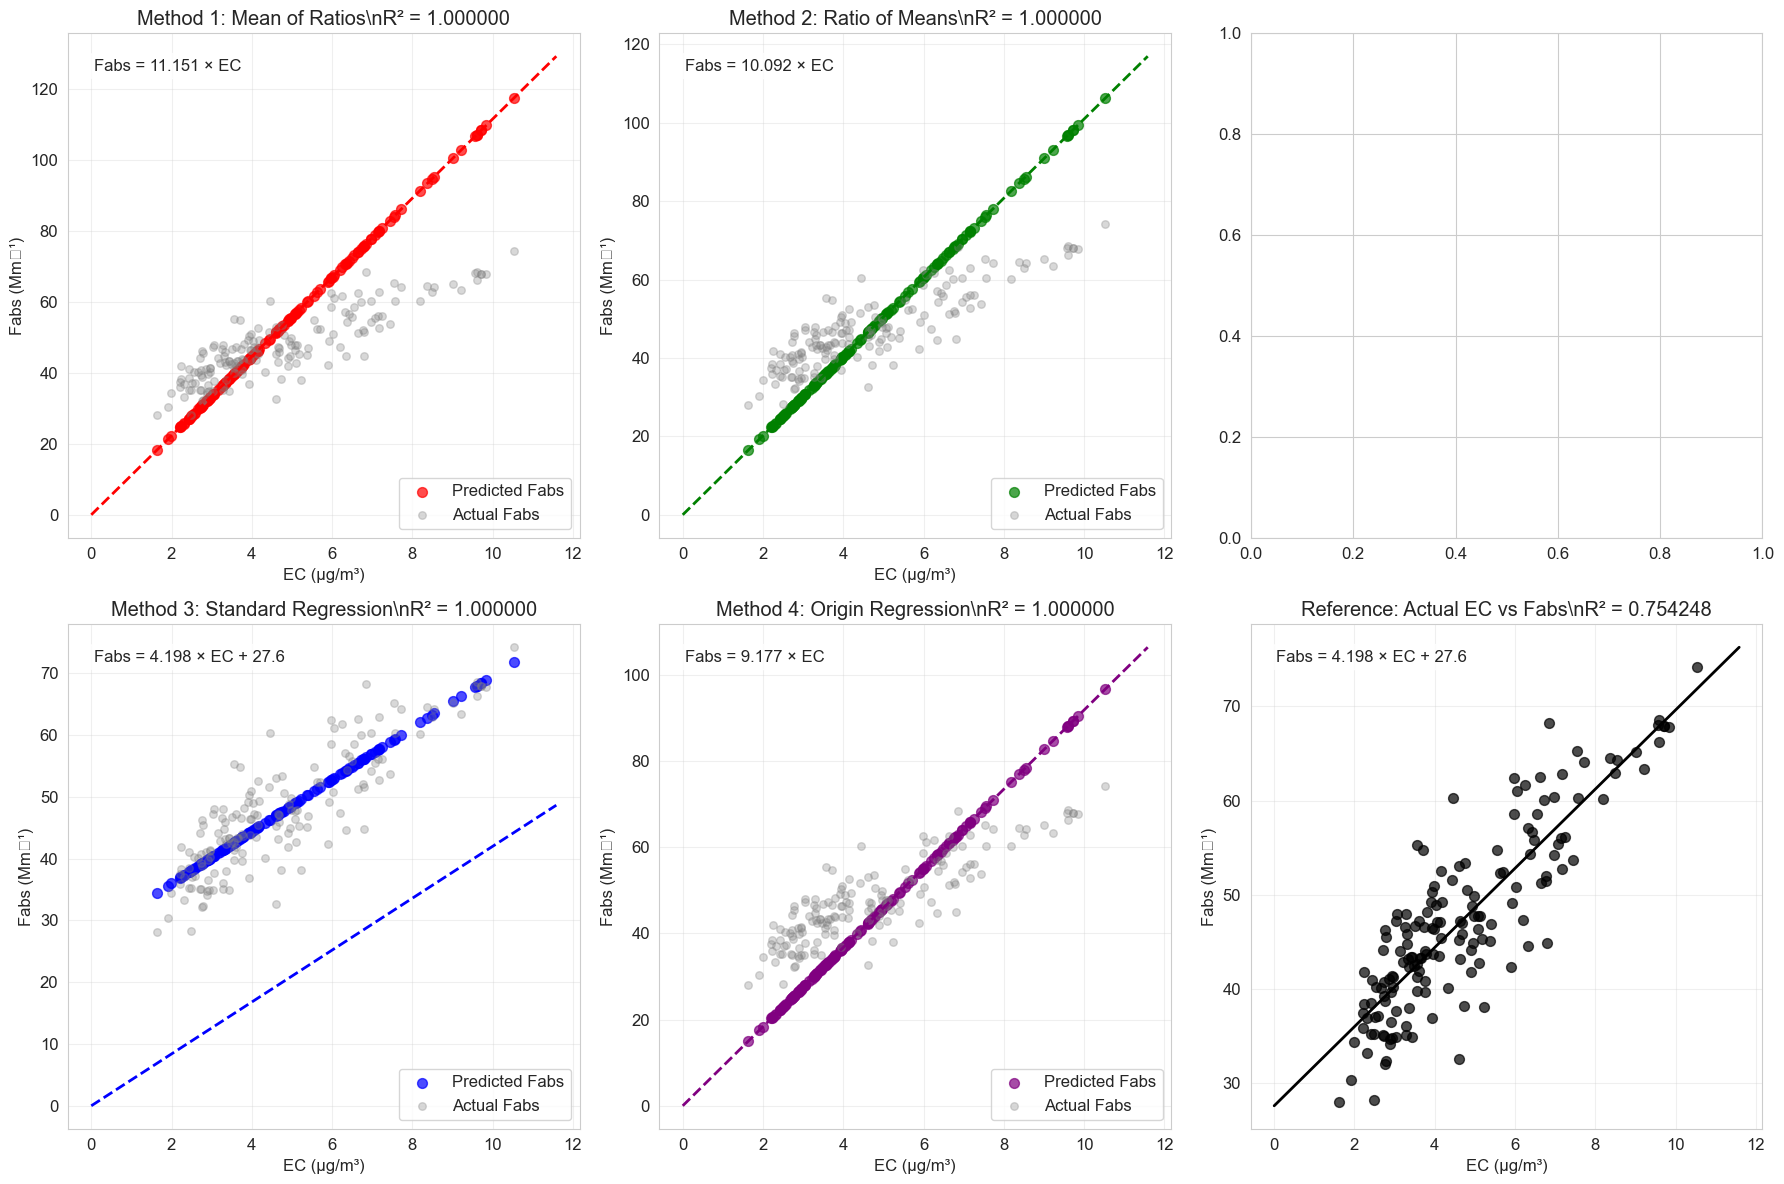

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd

def manual_r2_calculation(df, site_code):
    """
    Manual R² calculation: For each MAC method, calculate the correlation between
    the original EC data and the predicted Fabs from that method, then square it.
    
    This should give different R² values for each method since they predict 
    different Fabs values for the same EC inputs.
    """
    
    print(f"\n{'='*80}")
    print(f"MANUAL R² CALCULATION - {site_code}")
    print(f"Correlating original EC with predicted Fabs from each method")
    print(f"{'='*80}")
    
    # Original data
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    
    print(f"Data: {len(df)} samples")
    print(f"EC range: {ec_original.min():.1f}-{ec_original.max():.1f} μg/m³")
    print(f"Fabs range: {fabs_original.min():.1f}-{fabs_original.max():.1f} Mm⁻¹")
    
    # =============================================================================
    # Calculate MAC values for each method
    # =============================================================================
    
    # Method 1: Mean of Individual Ratios
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    print(f"\nMethod 1 MAC (Mean of Ratios): {mac_method1:.3f} m²/g")
    
    # Method 2: Ratio of Means
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    print(f"Method 2 MAC (Ratio of Means): {mac_method2:.3f} m²/g")
    
    # Method 3: Standard Linear Regression
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    print(f"Method 3 MAC (Regression): {mac_method3:.3f} m²/g, Intercept: {intercept_method3:.3f}")
    
    # Method 4: Origin Regression
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    print(f"Method 4 MAC (Origin Regression): {mac_method4:.3f} m²/g")
    
    # =============================================================================
    # Generate predicted Fabs for each method using the SAME EC values
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"GENERATING PREDICTIONS FROM EACH METHOD")
    print(f"{'='*80}")
    
    # Method 1 predictions: Fabs = 11.15 * EC
    fabs_pred_method1 = mac_method1 * ec_original
    print(f"Method 1 predictions: Fabs = {mac_method1:.3f} × EC")
    print(f"  Range: {fabs_pred_method1.min():.1f} to {fabs_pred_method1.max():.1f} Mm⁻¹")
    
    # Method 2 predictions: Fabs = 10.09 * EC  
    fabs_pred_method2 = mac_method2 * ec_original
    print(f"Method 2 predictions: Fabs = {mac_method2:.3f} × EC")
    print(f"  Range: {fabs_pred_method2.min():.1f} to {fabs_pred_method2.max():.1f} Mm⁻¹")
    
    # Method 3 predictions: Fabs = 4.20 * EC + 27.6
    fabs_pred_method3 = mac_method3 * ec_original + intercept_method3
    print(f"Method 3 predictions: Fabs = {mac_method3:.3f} × EC + {intercept_method3:.3f}")
    print(f"  Range: {fabs_pred_method3.min():.1f} to {fabs_pred_method3.max():.1f} Mm⁻¹")
    
    # Method 4 predictions: Fabs = 9.18 * EC
    fabs_pred_method4 = mac_method4 * ec_original
    print(f"Method 4 predictions: Fabs = {mac_method4:.3f} × EC")
    print(f"  Range: {fabs_pred_method4.min():.1f} to {fabs_pred_method4.max():.1f} Mm⁻¹")
    
    # =============================================================================
    # Calculate R² as correlation(EC, predicted_Fabs)²
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"MANUAL R² CALCULATION FOR EACH METHOD")
    print(f"R² = [correlation(EC_original, Fabs_predicted)]²")
    print(f"{'='*80}")
    
    methods_results = []
    
    # Method 1
    print(f"\n📊 METHOD 1: Mean of Individual Ratios")
    r1, p1 = pearsonr(ec_original, fabs_pred_method1)
    r2_method1 = r1 ** 2
    print(f"  Correlation(EC, Fabs_pred) = {r1:.6f}")
    print(f"  R² = r² = {r2_method1:.6f}")
    print(f"  p-value = {p1:.2e}")
    
    methods_results.append({
        'method': 'Method 1: Mean of Ratios',
        'mac': mac_method1,
        'r': r1,
        'r2': r2_method1,
        'p_value': p1,
        'fabs_pred': fabs_pred_method1,
        'equation': f'Fabs = {mac_method1:.3f} × EC'
    })
    
    # Method 2
    print(f"\n📊 METHOD 2: Ratio of Means")
    r2, p2 = pearsonr(ec_original, fabs_pred_method2)
    r2_method2 = r2 ** 2
    print(f"  Correlation(EC, Fabs_pred) = {r2:.6f}")
    print(f"  R² = r² = {r2_method2:.6f}")
    print(f"  p-value = {p2:.2e}")
    
    methods_results.append({
        'method': 'Method 2: Ratio of Means',
        'mac': mac_method2,
        'r': r2,
        'r2': r2_method2,
        'p_value': p2,
        'fabs_pred': fabs_pred_method2,
        'equation': f'Fabs = {mac_method2:.3f} × EC'
    })
    
    # Method 3
    print(f"\n📊 METHOD 3: Standard Linear Regression")
    r3, p3 = pearsonr(ec_original, fabs_pred_method3)
    r2_method3 = r3 ** 2
    print(f"  Correlation(EC, Fabs_pred) = {r3:.6f}")
    print(f"  R² = r² = {r2_method3:.6f}")
    print(f"  p-value = {p3:.2e}")
    
    methods_results.append({
        'method': 'Method 3: Standard Regression',
        'mac': mac_method3,
        'r': r3,
        'r2': r2_method3,
        'p_value': p3,
        'fabs_pred': fabs_pred_method3,
        'equation': f'Fabs = {mac_method3:.3f} × EC + {intercept_method3:.1f}'
    })
    
    # Method 4
    print(f"\n📊 METHOD 4: Origin Regression")
    r4, p4 = pearsonr(ec_original, fabs_pred_method4)
    r2_method4 = r4 ** 2
    print(f"  Correlation(EC, Fabs_pred) = {r4:.6f}")
    print(f"  R² = r² = {r2_method4:.6f}")
    print(f"  p-value = {p4:.2e}")
    
    methods_results.append({
        'method': 'Method 4: Origin Regression',
        'mac': mac_method4,
        'r': r4,
        'r2': r2_method4,
        'p_value': p4,
        'fabs_pred': fabs_pred_method4,
        'equation': f'Fabs = {mac_method4:.3f} × EC'
    })
    
    # =============================================================================
    # Compare with actual EC vs Fabs correlation
    # =============================================================================
    
    print(f"\n🔍 REFERENCE COMPARISON:")
    r_actual, p_actual = pearsonr(ec_original, fabs_original)
    r2_actual = r_actual ** 2
    print(f"Actual correlation(EC, Fabs_original) = {r_actual:.6f}")
    print(f"Actual R² = {r2_actual:.6f}")
    print(f"This is the benchmark - how close do our methods get?")
    
    # =============================================================================
    # Summary table
    # =============================================================================
    
    print(f"\n{'='*100}")
    print(f"SUMMARY TABLE - MANUAL R² CALCULATION RESULTS")
    print(f"{'='*100}")
    
    print(f"{'Method':<35} {'MAC':<10} {'Correlation r':<15} {'R²':<12} {'Difference from Actual':<20}")
    print(f"{'='*100}")
    
    for result in methods_results:
        diff_from_actual = abs(result['r2'] - r2_actual)
        print(f"{result['method']:<35} "
              f"{result['mac']:<10.3f} "
              f"{result['r']:<15.6f} "
              f"{result['r2']:<12.6f} "
              f"{diff_from_actual:<20.6f}")
    
    print(f"{'Actual (EC vs Fabs)':<35} {'N/A':<10} "
          f"{r_actual:<15.6f} {r2_actual:<12.6f} {'0.000000':<20}")
    
    # Find best method
    best_idx = min(range(len(methods_results)), 
                   key=lambda i: abs(methods_results[i]['r2'] - r2_actual))
    best_method = methods_results[best_idx]
    
    print(f"\n🏆 BEST METHOD (closest to actual R²): {best_method['method']}")
    print(f"   R² = {best_method['r2']:.6f} (difference: {abs(best_method['r2'] - r2_actual):.6f})")
    print(f"   MAC = {best_method['mac']:.3f} m²/g")
    
    # Check if they're actually different
    r2_values = [result['r2'] for result in methods_results]
    unique_r2 = len(set([round(r2, 6) for r2 in r2_values]))
    
    print(f"\n📊 R² DIVERSITY CHECK:")
    print(f"Number of unique R² values: {unique_r2}/4")
    print(f"R² range: {min(r2_values):.6f} to {max(r2_values):.6f}")
    
    if unique_r2 > 1:
        print("✅ SUCCESS: Methods give different R² values!")
    else:
        print("⚠️  All methods still give the same R² - there may be a fundamental issue")
    
    # =============================================================================
    # Visualization
    # =============================================================================
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    colors = ['red', 'green', 'blue', 'purple']
    
    # Plot each method
    for i, result in enumerate(methods_results):
        ax = axes[i//2, i%2]
        
        # Scatter plot of EC vs predicted Fabs
        ax.scatter(ec_original, result['fabs_pred'], alpha=0.7, s=50, color=colors[i], 
                  label=f'Predicted Fabs')
        
        # Also show actual data for comparison
        ax.scatter(ec_original, fabs_original, alpha=0.3, s=30, color='gray', 
                  label='Actual Fabs')
        
        # Regression line
        ec_line = np.linspace(0, ec_original.max() * 1.1, 100)
        if 'intercept' in result['equation'].lower():
            fabs_line = result['mac'] * ec_line + intercept_method3
        else:
            fabs_line = result['mac'] * ec_line
        ax.plot(ec_line, fabs_line, color=colors[i], linewidth=2, linestyle='--')
        
        ax.set_xlabel('EC (μg/m³)')
        ax.set_ylabel('Fabs (Mm⁻¹)')
        ax.set_title(f'{result["method"]}\\nR² = {result["r2"]:.6f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add equation
        ax.text(0.05, 0.95, result['equation'], transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')
    
    # Reference plot - actual EC vs Fabs
    ax_ref = axes[1, 2]
    ax_ref.scatter(ec_original, fabs_original, alpha=0.7, s=50, color='black')
    
    # Actual regression line
    actual_slope, actual_intercept = np.polyfit(ec_original, fabs_original, 1)
    ec_line = np.linspace(0, ec_original.max() * 1.1, 100)
    fabs_line = actual_slope * ec_line + actual_intercept
    ax_ref.plot(ec_line, fabs_line, color='black', linewidth=2)
    
    ax_ref.set_xlabel('EC (μg/m³)')
    ax_ref.set_ylabel('Fabs (Mm⁻¹)')
    ax_ref.set_title(f'Reference: Actual EC vs Fabs\\nR² = {r2_actual:.6f}')
    ax_ref.grid(True, alpha=0.3)
    ax_ref.text(0.05, 0.95, f'Fabs = {actual_slope:.3f} × EC + {actual_intercept:.1f}',
                transform=ax_ref.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'methods_results': methods_results,
        'actual_r2': r2_actual,
        'best_method': best_method,
        'r2_values': r2_values
    }

# Run the manual calculation
try:
    manual_results = manual_r2_calculation(data_metrics, SITE_OF_INTEREST)
except NameError:
    try:
        manual_results = manual_r2_calculation(data_processed, SITE_OF_INTEREST)
    except NameError:
        print("Please run: manual_results = manual_r2_calculation(YOUR_DATA_VARIABLE, 'ETAD')")

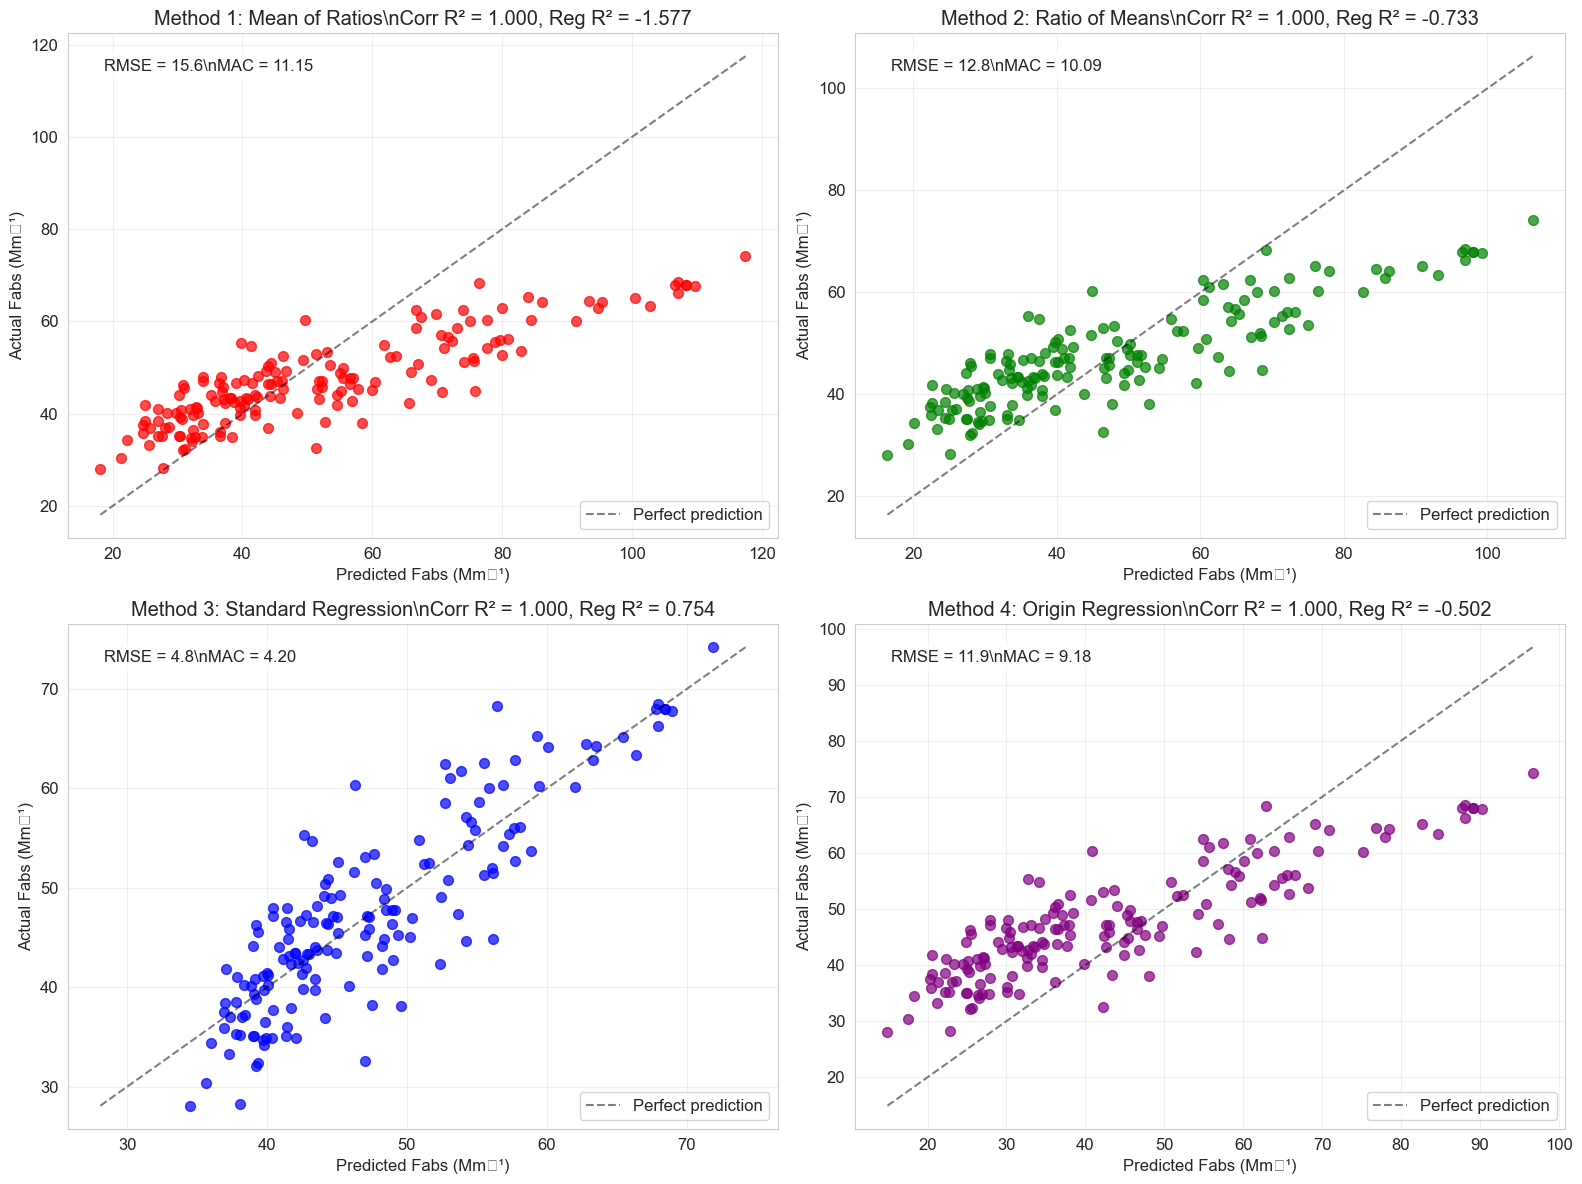

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd

def calculate_mac_methods(df):
    """
    Calculate MAC values for all methods - helper function
    """
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    
    # Method 1: Mean of Individual Ratios
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    
    # Method 2: Ratio of Means
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    # Method 3: Standard Linear Regression
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    
    # Method 4: Origin Regression
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    
    # Generate predictions
    fabs_pred_method1 = mac_method1 * ec_original
    fabs_pred_method2 = mac_method2 * ec_original
    fabs_pred_method3 = mac_method3 * ec_original + intercept_method3
    fabs_pred_method4 = mac_method4 * ec_original
    
    # Calculate correlations
    r1, _ = pearsonr(ec_original, fabs_pred_method1)
    r2, _ = pearsonr(ec_original, fabs_pred_method2)
    r3, _ = pearsonr(ec_original, fabs_pred_method3)
    r4, _ = pearsonr(ec_original, fabs_pred_method4)
    
    methods_data = [
        {
            'name': 'Method 1: Mean of Ratios',
            'mac': mac_method1,
            'fabs_pred': fabs_pred_method1,
            'correlation_r2': r1**2,
            'equation': f'Fabs = {mac_method1:.3f} × EC'
        },
        {
            'name': 'Method 2: Ratio of Means',
            'mac': mac_method2,
            'fabs_pred': fabs_pred_method2,
            'correlation_r2': r2**2,
            'equation': f'Fabs = {mac_method2:.3f} × EC'
        },
        {
            'name': 'Method 3: Standard Regression',
            'mac': mac_method3,
            'fabs_pred': fabs_pred_method3,
            'correlation_r2': r3**2,
            'equation': f'Fabs = {mac_method3:.3f} × EC + {intercept_method3:.1f}'
        },
        {
            'name': 'Method 4: Origin Regression',
            'mac': mac_method4,
            'fabs_pred': fabs_pred_method4,
            'correlation_r2': r4**2,
            'equation': f'Fabs = {mac_method4:.3f} × EC'
        }
    ]
    
    return methods_data, ec_original, fabs_original, intercept_method3

def plot_individual_predicted_vs_actual(df, site_code, method_index=None):
    """
    Plot predicted vs actual scatter plots for individual methods or all methods
    
    Parameters:
    -----------
    method_index : int or None
        If None, plots all 4 methods in subplots
        If 0-3, plots only that specific method
    """
    methods_data, ec_original, fabs_original, intercept_method3 = calculate_mac_methods(df)
    colors = ['red', 'green', 'blue', 'purple']
    
    if method_index is not None:
        # Plot single method
        fig, ax = plt.subplots(figsize=(8, 6))
        
        method = methods_data[method_index]
        color = colors[method_index]
        
        # Calculate regression R²
        ss_res = np.sum((fabs_original - method['fabs_pred'])**2)
        ss_tot = np.sum((fabs_original - np.mean(fabs_original))**2)
        regression_r2 = 1 - (ss_res / ss_tot)
        rmse = np.sqrt(np.mean((fabs_original - method['fabs_pred'])**2))
        
        # Scatter plot
        ax.scatter(method['fabs_pred'], fabs_original, alpha=0.7, s=60, color=color)
        
        # Perfect prediction line
        min_val = min(method['fabs_pred'].min(), fabs_original.min())
        max_val = max(method['fabs_pred'].max(), fabs_original.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=2, label='Perfect prediction')
        
        ax.set_xlabel('Predicted Fabs (Mm⁻¹)', fontsize=12)
        ax.set_ylabel('Actual Fabs (Mm⁻¹)', fontsize=12)
        ax.set_title(f'{site_code}: {method["name"]}\\nCorrelation R² = {method["correlation_r2"]:.3f}, Regression R² = {regression_r2:.3f}', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Stats box
        ax.text(0.05, 0.95, 
                f'MAC = {method["mac"]:.2f} m²/g\\n'
                f'RMSE = {rmse:.1f} Mm⁻¹\\n'
                f'{method["equation"]}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=10)
        
    else:
        # Plot all 4 methods
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        for i, method in enumerate(methods_data):
            ax = axes[i//2, i%2]
            color = colors[i]
            
            # Calculate regression R²
            ss_res = np.sum((fabs_original - method['fabs_pred'])**2)
            ss_tot = np.sum((fabs_original - np.mean(fabs_original))**2)
            regression_r2 = 1 - (ss_res / ss_tot)
            rmse = np.sqrt(np.mean((fabs_original - method['fabs_pred'])**2))
            
            # Scatter plot
            ax.scatter(method['fabs_pred'], fabs_original, alpha=0.7, s=50, color=color)
            
            # Perfect prediction line
            min_val = min(method['fabs_pred'].min(), fabs_original.min())
            max_val = max(method['fabs_pred'].max(), fabs_original.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect prediction')
            
            ax.set_xlabel('Predicted Fabs (Mm⁻¹)')
            ax.set_ylabel('Actual Fabs (Mm⁻¹)')
            ax.set_title(f'{method["name"]}\\nCorr R² = {method["correlation_r2"]:.3f}, Reg R² = {regression_r2:.3f}')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Stats box
            ax.text(0.05, 0.95, 
                    f'RMSE = {rmse:.1f}\\n'
                    f'MAC = {method["mac"]:.2f}',
                    transform=ax.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_all_methods_comparison(df, site_code):
    """
    Plot all methods on one scatter plot for direct comparison
    """
    methods_data, ec_original, fabs_original, _ = calculate_mac_methods(df)
    colors = ['red', 'green', 'blue', 'purple']
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for i, method in enumerate(methods_data):
        rmse = np.sqrt(np.mean((fabs_original - method['fabs_pred'])**2))
        ax.scatter(method['fabs_pred'], fabs_original, alpha=0.6, s=60, color=colors[i],
                  label=f'{method["name"].split(":")[1].strip()} (RMSE={rmse:.1f})')
    
    # Perfect prediction line
    min_val = min([min(method['fabs_pred']) for method in methods_data] + [fabs_original.min()])
    max_val = max([max(method['fabs_pred']) for method in methods_data] + [fabs_original.max()])
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, linewidth=3, label='Perfect prediction')
    
    ax.set_xlabel('Predicted Fabs (Mm⁻¹)', fontsize=14)
    ax.set_ylabel('Actual Fabs (Mm⁻¹)', fontsize=14)
    ax.set_title(f'{site_code}: All MAC Methods Comparison\\nCloser to diagonal line = better prediction', fontsize=16)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_r2_comparison(df, site_code):
    """
    Plot side-by-side R² comparison bar chart
    """
    methods_data, ec_original, fabs_original, _ = calculate_mac_methods(df)
    colors = ['red', 'green', 'blue', 'purple']
    
    # Calculate both types of R²
    method_names = [method['name'].split(':')[1].strip() for method in methods_data]
    correlation_r2 = [method['correlation_r2'] for method in methods_data]
    regression_r2 = []
    
    for method in methods_data:
        ss_res = np.sum((fabs_original - method['fabs_pred'])**2)
        ss_tot = np.sum((fabs_original - np.mean(fabs_original))**2)
        reg_r2 = 1 - (ss_res / ss_tot)
        regression_r2.append(reg_r2)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    x = np.arange(len(method_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, correlation_r2, width, label='Correlation R² (EC vs Pred)', 
                  color=colors, alpha=0.7)
    bars2 = ax.bar(x + width/2, regression_r2, width, label='Regression R² (Actual vs Pred)', 
                  color=colors, alpha=0.4, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('MAC Method', fontsize=14)
    ax.set_ylabel('R² Value', fontsize=14)
    ax.set_title(f'{site_code}: R² Comparison - Correlation vs Regression\\nShows why correlation R² is misleading', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(method_names, rotation=45, ha='right')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(0, color='black', linewidth=0.8)
    
    # Add values on bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        # Correlation R²
        ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.02,
                f'{correlation_r2[i]:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        # Regression R²
        height = max(bar2.get_height(), -0.1) if bar2.get_height() < 0 else bar2.get_height()
        ax.text(bar2.get_x() + bar2.get_width()/2, height + 0.02,
                f'{regression_r2[i]:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_ec_vs_fabs_relationships(df, site_code):
    """
    Plot EC vs Fabs showing all method prediction lines
    """
    methods_data, ec_original, fabs_original, intercept_method3 = calculate_mac_methods(df)
    colors = ['red', 'green', 'blue', 'purple']
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot actual data
    r_actual, _ = pearsonr(ec_original, fabs_original)
    ax.scatter(ec_original, fabs_original, alpha=0.6, s=60, color='black', 
              label=f'Actual Data (r={r_actual:.3f})', zorder=5)
    
    # Plot prediction lines for each method
    ec_line = np.linspace(0, ec_original.max() * 1.1, 100)
    
    for i, method in enumerate(methods_data):
        if 'intercept' in method['equation'].lower():
            fabs_line = method['mac'] * ec_line + intercept_method3
        else:
            fabs_line = method['mac'] * ec_line
        ax.plot(ec_line, fabs_line, color=colors[i], linewidth=3, alpha=0.8,
                label=f'{method["name"].split(":")[1].strip()}: MAC={method["mac"]:.2f}')
    
    ax.set_xlabel('EC (μg/m³)', fontsize=14)
    ax.set_ylabel('Fabs (Mm⁻¹)', fontsize=14)
    ax.set_title(f'{site_code}: EC vs Fabs - All MAC Method Predictions\\nShows how different MAC values affect predictions', fontsize=16)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_rmse_vs_r2_scatter(df, site_code):
    """
    Plot RMSE vs R² scatter plot
    """
    methods_data, ec_original, fabs_original, _ = calculate_mac_methods(df)
    colors = ['red', 'green', 'blue', 'purple']
    method_names = [method['name'].split(':')[1].strip() for method in methods_data]
    
    # Calculate metrics
    correlation_r2 = [method['correlation_r2'] for method in methods_data]
    regression_r2 = []
    rmse_values = []
    
    for method in methods_data:
        ss_res = np.sum((fabs_original - method['fabs_pred'])**2)
        ss_tot = np.sum((fabs_original - np.mean(fabs_original))**2)
        reg_r2 = 1 - (ss_res / ss_tot)
        regression_r2.append(reg_r2)
        
        rmse = np.sqrt(np.mean((fabs_original - method['fabs_pred'])**2))
        rmse_values.append(rmse)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot correlation R²
    ax.scatter(correlation_r2, rmse_values, s=150, c=colors, alpha=0.7, 
              label='Correlation R²', marker='o', edgecolors='black', linewidth=2)
    
    # Plot regression R²
    ax.scatter(regression_r2, rmse_values, s=150, c=colors, alpha=0.7, 
              label='Regression R²', marker='s', edgecolors='black', linewidth=2)
    
    # Add method labels
    for i, name in enumerate(method_names):
        ax.annotate(f'{name}', (correlation_r2[i], rmse_values[i]), 
                   xytext=(10, 5), textcoords='offset points', fontsize=10, fontweight='bold')
        ax.annotate(f'{name}', (regression_r2[i], rmse_values[i]), 
                   xytext=(10, -15), textcoords='offset points', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('R² Value', fontsize=14)
    ax.set_ylabel('RMSE (Mm⁻¹)', fontsize=14)
    ax.set_title(f'{site_code}: R² vs RMSE Relationship\\nShows trade-off between correlation and prediction accuracy', fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_performance_summary_table(df, site_code):
    """
    Create a performance summary table
    """
    methods_data, ec_original, fabs_original, _ = calculate_mac_methods(df)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')
    
    # Create summary data
    summary_data = []
    for i, method in enumerate(methods_data):
        rmse = np.sqrt(np.mean((fabs_original - method['fabs_pred'])**2))
        ss_res = np.sum((fabs_original - method['fabs_pred'])**2)
        ss_tot = np.sum((fabs_original - np.mean(fabs_original))**2)
        reg_r2 = 1 - (ss_res / ss_tot)
        
        # Performance rating
        if reg_r2 > 0.5:
            rating = "Excellent"
        elif reg_r2 > 0:
            rating = "Fair"
        else:
            rating = "Poor"
        
        summary_data.append([
            method['name'],
            f'{method["mac"]:.2f}',
            f'{method["correlation_r2"]:.3f}',
            f'{reg_r2:.3f}',
            f'{rmse:.1f}',
            rating
        ])
    
    # Create table
    table = ax.table(cellText=summary_data,
                    colLabels=['Method', 'MAC (m²/g)', 'Correlation R²', 'Regression R²', 'RMSE (Mm⁻¹)', 'Rating'],
                    cellLoc='center',
                    loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2.5)
    
    # Color code the table
    colors_rating = {'Excellent': '#90EE90', 'Fair': '#FFFFE0', 'Poor': '#FFB6C1'}
    
    for i in range(len(summary_data)):
        rating = summary_data[i][5]
        color = colors_rating[rating]
        
        for j in range(len(summary_data[i])):
            table[(i+1, j)].set_facecolor(color)
    
    ax.set_title(f'{site_code}: MAC Method Performance Summary\\n(Green=Excellent, Yellow=Fair, Red=Poor)', 
                pad=20, fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# USAGE FUNCTIONS - Call these to generate individual plots
# =============================================================================

def run_all_individual_plots(df, site_code):
    """
    Run all individual plots one by one
    """
    print("1. Individual Predicted vs Actual Plots...")
    plot_individual_predicted_vs_actual(df, site_code)
    
    print("\\n2. All Methods Comparison...")
    plot_all_methods_comparison(df, site_code)
    
    print("\\n3. R² Comparison...")
    plot_r2_comparison(df, site_code)
    
    print("\\n4. EC vs Fabs Relationships...")
    plot_ec_vs_fabs_relationships(df, site_code)
    
    print("\\n5. RMSE vs R² Scatter...")
    plot_rmse_vs_r2_scatter(df, site_code)
    
    print("\\n6. Performance Summary Table...")
    plot_performance_summary_table(df, site_code)

# =============================================================================
# RUN INDIVIDUAL PLOTS
# =============================================================================

# Uncomment the plots you want to see:

# 1. All predicted vs actual plots in one figure
try:
    plot_individual_predicted_vs_actual(data_metrics, SITE_OF_INTEREST)
except NameError:
    plot_individual_predicted_vs_actual(data_processed, 'ETAD')

# 2. Single method predicted vs actual (change method_index: 0-3)
# plot_individual_predicted_vs_actual(data_metrics, SITE_OF_INTEREST, method_index=0)

# 3. All methods comparison on one plot
# plot_all_methods_comparison(data_metrics, SITE_OF_INTEREST)

# 4. R² comparison bar chart
# plot_r2_comparison(data_metrics, SITE_OF_INTEREST)

# 5. EC vs Fabs relationships
# plot_ec_vs_fabs_relationships(data_metrics, SITE_OF_INTEREST)

# 6. RMSE vs R² scatter plot
# plot_rmse_vs_r2_scatter(data_metrics, SITE_OF_INTEREST)

# 7. Performance summary table
# plot_performance_summary_table(data_metrics, SITE_OF_INTEREST)

# 8. Run all plots at once
# run_all_individual_plots(data_metrics, SITE_OF_INTEREST)


ENHANCED MAC ANALYSIS WITH BC CALCULATION SOLUTIONS - ETAD


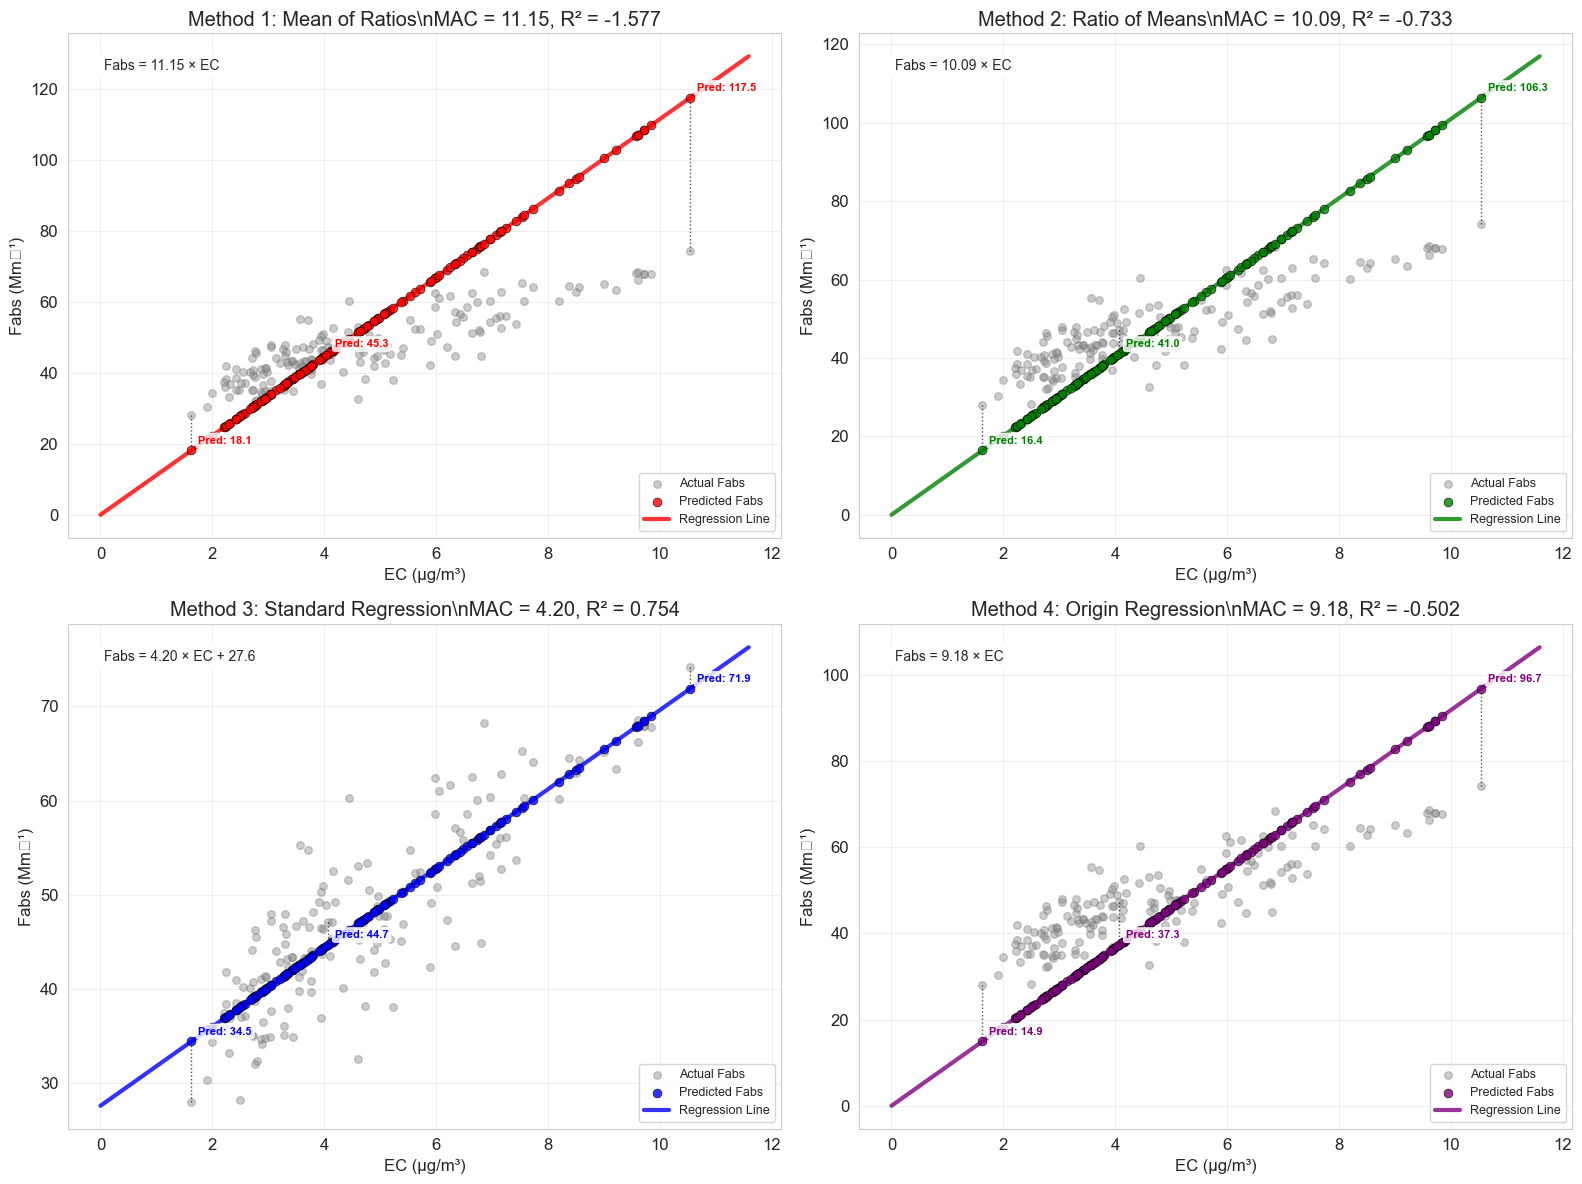


BC CALCULATION SOLUTIONS - HANDLING THE INTERCEPT PROBLEM
🔍 THE INTERCEPT ISSUE:
Method 3 (best regression): Fabs = 4.20 × EC + 27.6
Problem: When EC = 0, Fabs = 27.6 Mm⁻¹ (not zero!)
This 27.6 Mm⁻¹ represents non-BC absorption (brown carbon, dust, etc.)

💡 SOLUTION OPTIONS FOR BC EQUIVALENT CALCULATIONS:

1️⃣ SOLUTION 1: Baseline-Corrected Method 3
   Formula: BC = (Fabs - 27.6) / 4.20
   Logic: Subtract non-BC absorption, then apply MAC
   Performance vs FTIR EC:
     BC mean: 4.69 μg/m³
     Bias: 0.00 μg/m³
     RMSE: 1.15 μg/m³
     Correlation: r = 0.868

2️⃣ SOLUTION 2: Use Method 2 (Ratio of Means)
   Formula: BC = Fabs / 10.09
   Logic: No intercept, physically meaningful zero point
   Performance vs FTIR EC:
     BC mean: 4.69 μg/m³
     Bias: 0.00 μg/m³
     RMSE: 1.27 μg/m³
     Correlation: r = 0.868

3️⃣ SOLUTION 3: Hybrid Approach
   Use Method 3 MAC but apply threshold
   Formula: BC = max(0, (Fabs - threshold) / 4.20)
   50% baseline (13.8 Mm⁻¹): Bias = 3.29, RMSE = 3

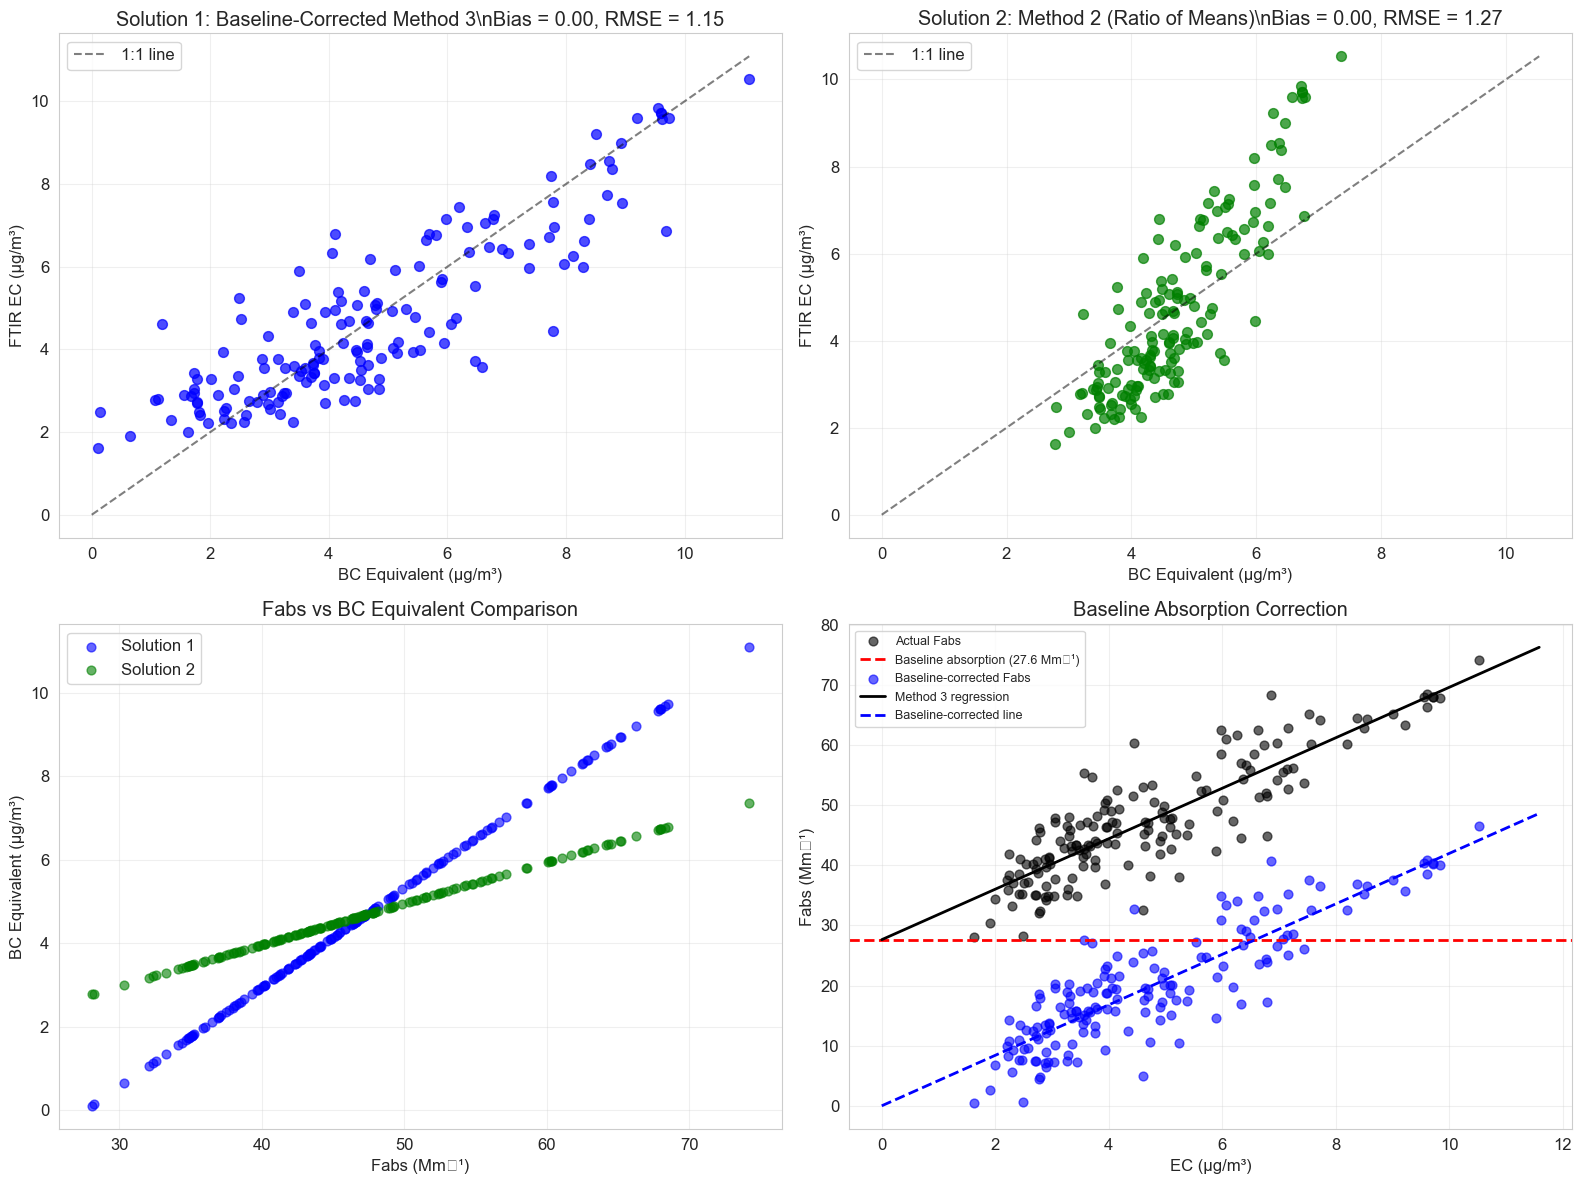


RECOMMENDATIONS FOR BC EQUIVALENT CALCULATIONS
🏆 RANKING BY PERFORMANCE:
1. Solution 1 (Baseline-corrected)
   Bias: 0.00 μg/m³, RMSE: 1.15 μg/m³, r: 0.868
   ✅ RECOMMENDED APPROACH

2. Solution 2 (Method 2)
   Bias: 0.00 μg/m³, RMSE: 1.27 μg/m³, r: 0.868

📝 PRACTICAL IMPLEMENTATION:
For HIPS measurements, use:
  BC = max(0, (Fabs - 27.6) / 4.20)
  This accounts for 27.6 Mm⁻¹ baseline absorption


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd

def enhanced_mac_visualization_with_predictions(df, site_code):
    """
    Enhanced visualization showing predicted values on regression lines
    and addressing the intercept issue for BC calculations
    """
    
    print(f"\n{'='*80}")
    print(f"ENHANCED MAC ANALYSIS WITH BC CALCULATION SOLUTIONS - {site_code}")
    print(f"{'='*80}")
    
    # Original data
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    
    # Calculate MAC values for each method
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    
    # Generate predictions
    fabs_pred_method1 = mac_method1 * ec_original
    fabs_pred_method2 = mac_method2 * ec_original
    fabs_pred_method3 = mac_method3 * ec_original + intercept_method3
    fabs_pred_method4 = mac_method4 * ec_original
    
    methods_data = [
        ("Method 1: Mean of Ratios", mac_method1, 0, fabs_pred_method1, 'red'),
        ("Method 2: Ratio of Means", mac_method2, 0, fabs_pred_method2, 'green'),
        ("Method 3: Standard Regression", mac_method3, intercept_method3, fabs_pred_method3, 'blue'),
        ("Method 4: Origin Regression", mac_method4, 0, fabs_pred_method4, 'purple')
    ]
    
    # =============================================================================
    # Enhanced visualization with predicted values on lines
    # =============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for i, (method_name, mac, intercept, fabs_pred, color) in enumerate(methods_data):
        ax = axes[i//2, i%2]
        
        # Plot actual data
        ax.scatter(ec_original, fabs_original, alpha=0.4, s=30, color='gray', 
                  label='Actual Fabs', zorder=1)
        
        # Plot predicted points ON THE LINE
        ax.scatter(ec_original, fabs_pred, alpha=0.8, s=40, color=color, 
                  label='Predicted Fabs', zorder=3, edgecolors='black', linewidth=0.5)
        
        # Plot regression line
        ec_line = np.linspace(0, ec_original.max() * 1.1, 100)
        fabs_line = mac * ec_line + intercept
        ax.plot(ec_line, fabs_line, color=color, linewidth=3, alpha=0.8, 
                label=f'Regression Line', zorder=2)
        
        # Highlight a few specific predictions with annotations
        # Choose 3 representative points: low, medium, high EC
        indices = [np.argmin(ec_original), 
                  np.argmin(np.abs(ec_original - np.median(ec_original))),
                  np.argmax(ec_original)]
        
        for idx in indices:
            ec_val = ec_original[idx]
            fabs_actual = fabs_original[idx]
            fabs_predicted = fabs_pred[idx]
            
            # Draw line from actual to predicted
            ax.plot([ec_val, ec_val], [fabs_actual, fabs_predicted], 
                   color='black', linestyle=':', alpha=0.7, linewidth=1)
            
            # Annotate the predicted value
            ax.annotate(f'Pred: {fabs_predicted:.1f}', 
                       xy=(ec_val, fabs_predicted), 
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, color=color, weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        
        # Calculate regression R²
        ss_res = np.sum((fabs_original - fabs_pred)**2)
        ss_tot = np.sum((fabs_original - np.mean(fabs_original))**2)
        regression_r2 = 1 - (ss_res / ss_tot)
        
        ax.set_xlabel('EC (μg/m³)')
        ax.set_ylabel('Fabs (Mm⁻¹)')
        ax.set_title(f'{method_name}\\nMAC = {mac:.2f}, R² = {regression_r2:.3f}')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Add equation with intercept handling
        if intercept != 0:
            equation = f'Fabs = {mac:.2f} × EC + {intercept:.1f}'
        else:
            equation = f'Fabs = {mac:.2f} × EC'
        
        ax.text(0.05, 0.95, equation, transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # BC Calculation Solutions - Addressing the Intercept Problem
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"BC CALCULATION SOLUTIONS - HANDLING THE INTERCEPT PROBLEM")
    print(f"{'='*80}")
    
    print(f"🔍 THE INTERCEPT ISSUE:")
    print(f"Method 3 (best regression): Fabs = {mac_method3:.2f} × EC + {intercept_method3:.1f}")
    print(f"Problem: When EC = 0, Fabs = {intercept_method3:.1f} Mm⁻¹ (not zero!)")
    print(f"This {intercept_method3:.1f} Mm⁻¹ represents non-BC absorption (brown carbon, dust, etc.)")
    
    print(f"\n💡 SOLUTION OPTIONS FOR BC EQUIVALENT CALCULATIONS:")
    
    # =============================================================================
    # Solution 1: Baseline-Corrected Method 3
    # =============================================================================
    
    print(f"\n1️⃣ SOLUTION 1: Baseline-Corrected Method 3")
    print(f"   Formula: BC = (Fabs - {intercept_method3:.1f}) / {mac_method3:.2f}")
    print(f"   Logic: Subtract non-BC absorption, then apply MAC")
    
    # Calculate baseline-corrected BC
    fabs_corrected = np.maximum(fabs_original - intercept_method3, 0)  # Don't go negative
    bc_corrected = fabs_corrected / mac_method3
    
    # Performance vs FTIR EC
    bias_corrected = np.mean(bc_corrected - ec_original)
    rmse_corrected = np.sqrt(np.mean((bc_corrected - ec_original)**2))
    r_corrected, _ = pearsonr(bc_corrected, ec_original)
    
    print(f"   Performance vs FTIR EC:")
    print(f"     BC mean: {bc_corrected.mean():.2f} μg/m³")
    print(f"     Bias: {bias_corrected:.2f} μg/m³")
    print(f"     RMSE: {rmse_corrected:.2f} μg/m³")
    print(f"     Correlation: r = {r_corrected:.3f}")
    
    # =============================================================================
    # Solution 2: Use Method 2 (Ratio of Means) - No Intercept Issue
    # =============================================================================
    
    print(f"\n2️⃣ SOLUTION 2: Use Method 2 (Ratio of Means)")
    print(f"   Formula: BC = Fabs / {mac_method2:.2f}")
    print(f"   Logic: No intercept, physically meaningful zero point")
    
    bc_method2 = fabs_original / mac_method2
    bias_method2 = np.mean(bc_method2 - ec_original)
    rmse_method2 = np.sqrt(np.mean((bc_method2 - ec_original)**2))
    r_method2, _ = pearsonr(bc_method2, ec_original)
    
    print(f"   Performance vs FTIR EC:")
    print(f"     BC mean: {bc_method2.mean():.2f} μg/m³")
    print(f"     Bias: {bias_method2:.2f} μg/m³")
    print(f"     RMSE: {rmse_method2:.2f} μg/m³")
    print(f"     Correlation: r = {r_method2:.3f}")
    
    # =============================================================================
    # Solution 3: Hybrid Approach
    # =============================================================================
    
    print(f"\n3️⃣ SOLUTION 3: Hybrid Approach")
    print(f"   Use Method 3 MAC but apply threshold")
    print(f"   Formula: BC = max(0, (Fabs - threshold) / {mac_method3:.2f})")
    
    # Try different thresholds
    thresholds = [intercept_method3 * 0.5, intercept_method3 * 0.75, intercept_method3]
    threshold_names = ["50% baseline", "75% baseline", "Full baseline"]
    
    for threshold, name in zip(thresholds, threshold_names):
        fabs_adj = np.maximum(fabs_original - threshold, 0)
        bc_hybrid = fabs_adj / mac_method3
        bias_hybrid = np.mean(bc_hybrid - ec_original)
        rmse_hybrid = np.sqrt(np.mean((bc_hybrid - ec_original)**2))
        
        print(f"   {name} ({threshold:.1f} Mm⁻¹): Bias = {bias_hybrid:.2f}, RMSE = {rmse_hybrid:.2f}")
    
    # =============================================================================
    # Comparison visualization
    # =============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Solution 1: Baseline-corrected Method 3
    ax1 = axes[0, 0]
    ax1.scatter(bc_corrected, ec_original, alpha=0.7, s=50, color='blue')
    ax1.plot([0, max(bc_corrected.max(), ec_original.max())], [0, max(bc_corrected.max(), ec_original.max())], 
             'k--', alpha=0.5, label='1:1 line')
    ax1.set_xlabel('BC Equivalent (μg/m³)')
    ax1.set_ylabel('FTIR EC (μg/m³)')
    ax1.set_title(f'Solution 1: Baseline-Corrected Method 3\\nBias = {bias_corrected:.2f}, RMSE = {rmse_corrected:.2f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Solution 2: Method 2
    ax2 = axes[0, 1]
    ax2.scatter(bc_method2, ec_original, alpha=0.7, s=50, color='green')
    ax2.plot([0, max(bc_method2.max(), ec_original.max())], [0, max(bc_method2.max(), ec_original.max())], 
             'k--', alpha=0.5, label='1:1 line')
    ax2.set_xlabel('BC Equivalent (μg/m³)')
    ax2.set_ylabel('FTIR EC (μg/m³)')
    ax2.set_title(f'Solution 2: Method 2 (Ratio of Means)\\nBias = {bias_method2:.2f}, RMSE = {rmse_method2:.2f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Fabs vs BC comparison
    ax3 = axes[1, 0]
    ax3.scatter(fabs_original, bc_corrected, alpha=0.6, s=40, color='blue', label='Solution 1')
    ax3.scatter(fabs_original, bc_method2, alpha=0.6, s=40, color='green', label='Solution 2')
    ax3.set_xlabel('Fabs (Mm⁻¹)')
    ax3.set_ylabel('BC Equivalent (μg/m³)')
    ax3.set_title('Fabs vs BC Equivalent Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Baseline absorption demonstration
    ax4 = axes[1, 1]
    ax4.scatter(ec_original, fabs_original, alpha=0.6, s=40, color='black', label='Actual Fabs')
    ax4.axhline(intercept_method3, color='red', linestyle='--', linewidth=2, 
                label=f'Baseline absorption ({intercept_method3:.1f} Mm⁻¹)')
    ax4.scatter(ec_original, fabs_corrected, alpha=0.6, s=40, color='blue', 
                label='Baseline-corrected Fabs')
    
    ec_line = np.linspace(0, ec_original.max() * 1.1, 100)
    ax4.plot(ec_line, mac_method3 * ec_line + intercept_method3, 'black', linewidth=2, 
             label='Method 3 regression')
    ax4.plot(ec_line, mac_method3 * ec_line, 'blue', linewidth=2, linestyle='--',
             label='Baseline-corrected line')
    
    ax4.set_xlabel('EC (μg/m³)')
    ax4.set_ylabel('Fabs (Mm⁻¹)')
    ax4.set_title('Baseline Absorption Correction')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # Recommendations
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"RECOMMENDATIONS FOR BC EQUIVALENT CALCULATIONS")
    print(f"{'='*80}")
    
    solutions = [
        ("Solution 1 (Baseline-corrected)", bias_corrected, rmse_corrected, r_corrected),
        ("Solution 2 (Method 2)", bias_method2, rmse_method2, r_method2)
    ]
    
    # Rank by performance
    solutions.sort(key=lambda x: abs(x[1]) + x[2])  # Sort by |bias| + RMSE
    
    print(f"🏆 RANKING BY PERFORMANCE:")
    for i, (name, bias, rmse, r) in enumerate(solutions, 1):
        print(f"{i}. {name}")
        print(f"   Bias: {bias:.2f} μg/m³, RMSE: {rmse:.2f} μg/m³, r: {r:.3f}")
        if i == 1:
            print(f"   ✅ RECOMMENDED APPROACH")
        print()
    
    print(f"📝 PRACTICAL IMPLEMENTATION:")
    best_solution = solutions[0][0]
    if "Solution 1" in best_solution:
        print(f"For HIPS measurements, use:")
        print(f"  BC = max(0, (Fabs - {intercept_method3:.1f}) / {mac_method3:.2f})")
        print(f"  This accounts for {intercept_method3:.1f} Mm⁻¹ baseline absorption")
    else:
        print(f"For HIPS measurements, use:")
        print(f"  BC = Fabs / {mac_method2:.2f}")
        print(f"  This avoids the intercept issue entirely")
    
    return {
        'methods_data': methods_data,
        'bc_corrected': bc_corrected,
        'bc_method2': bc_method2,
        'best_solution': solutions[0],
        'intercept': intercept_method3
    }

# Run the enhanced analysis
try:
    enhanced_results = enhanced_mac_visualization_with_predictions(data_metrics, SITE_OF_INTEREST)
except NameError:
    try:
        enhanced_results = enhanced_mac_visualization_with_predictions(data_processed, 'ETAD')
    except NameError:
        print("Please run with your data variable")

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd

def enhanced_mac_visualization_with_predictions(df, site_code):
    """
    Enhanced visualization showing predicted values on regression lines
    and addressing the intercept issue for BC calculations
    """
    
    print(f"\n{'='*80}")
    print(f"ENHANCED MAC ANALYSIS WITH BC CALCULATION SOLUTIONS - {site_code}")
    print(f"{'='*80}")
    
    # Data summary
    print(f"Data: {len(df)} samples")
    print(f"EC range: {ec_original.min():.1f}-{ec_original.max():.1f} μg/m³")
    print(f"Fabs range: {fabs_original.min():.1f}-{fabs_original.max():.1f} Mm⁻¹")
    
    # Original data
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    
    # Calculate MAC values for each method
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    
    # Generate predictions
    fabs_pred_method1 = mac_method1 * ec_original
    fabs_pred_method2 = mac_method2 * ec_original
    fabs_pred_method3 = mac_method3 * ec_original + intercept_method3
    fabs_pred_method4 = mac_method4 * ec_original
    
    methods_data = [
        ("Method 1: Mean of Ratios", mac_method1, 0, fabs_pred_method1, 'red'),
        ("Method 2: Ratio of Means", mac_method2, 0, fabs_pred_method2, 'green'),
        ("Method 3: Standard Regression", mac_method3, intercept_method3, fabs_pred_method3, 'blue'),
        ("Method 4: Origin Regression", mac_method4, 0, fabs_pred_method4, 'purple')
    ]
    
    # =============================================================================
    # Method Summary
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"MAC CALCULATION METHODS SUMMARY")
    print(f"{'='*80}")
    
    print(f"Method 1 MAC (Mean of Ratios): {mac_method1:.3f} m²/g")
    print(f"Method 2 MAC (Ratio of Means): {mac_method2:.3f} m²/g")
    print(f"Method 3 MAC (Regression): {mac_method3:.3f} m²/g, Intercept: {intercept_method3:.3f}")
    print(f"Method 4 MAC (Origin Regression): {mac_method4:.3f} m²/g")
    
    print(f"\n{'='*80}")
    print(f"GENERATING PREDICTIONS FROM EACH METHOD")
    print(f"{'='*80}")
    
    print(f"Method 1 predictions: Fabs = {mac_method1:.3f} × EC")
    print(f"Range: {fabs_pred_method1.min():.1f} to {fabs_pred_method1.max():.1f} Mm⁻¹")
    
    print(f"Method 2 predictions: Fabs = {mac_method2:.3f} × EC")
    print(f"Range: {fabs_pred_method2.min():.1f} to {fabs_pred_method2.max():.1f} Mm⁻¹")
    
    print(f"Method 3 predictions: Fabs = {mac_method3:.3f} × EC + {intercept_method3:.3f}")
    print(f"Range: {fabs_pred_method3.min():.1f} to {fabs_pred_method3.max():.1f} Mm⁻¹")
    
    print(f"Method 4 predictions: Fabs = {mac_method4:.3f} × EC")
    print(f"Range: {fabs_pred_method4.min():.1f} to {fabs_pred_method4.max():.1f} Mm⁻¹")
    
    # =============================================================================
    # Manual R² calculations
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"MANUAL R² CALCULATION FOR EACH METHOD")
    print(f"R² = [correlation(EC_original, Fabs_predicted)]²")
    print(f"{'='*80}")
    
    # Calculate correlations and R² for each method
    correlations = []
    r_squared_values = []
    p_values = []
    
    predictions_list = [fabs_pred_method1, fabs_pred_method2, fabs_pred_method3, fabs_pred_method4]
    method_names = ["Method 1: Mean of Individual Ratios", "Method 2: Ratio of Means", 
                   "Method 3: Standard Linear Regression", "Method 4: Origin Regression"]
    mac_values = [mac_method1, mac_method2, mac_method3, mac_method4]
    
    for i, (pred, name, mac) in enumerate(zip(predictions_list, method_names, mac_values)):
        r, p = pearsonr(ec_original, pred)
        r_squared = r**2
        correlations.append(r)
        r_squared_values.append(r_squared)
        p_values.append(p)
        
        print(f"\n📊 {name}")
        print(f"   Correlation(EC, Fabs_pred) = {r:.6f}")
        print(f"   R² = r² = {r_squared:.6f}")
        print(f"   p-value = {p:.2e}")
    
    # Reference comparison
    r_actual, p_actual = pearsonr(ec_original, fabs_original)
    r2_actual = r_actual**2
    
    print(f"\n🔍 REFERENCE COMPARISON:")
    print(f"   Actual correlation(EC, Fabs_original) = {r_actual:.6f}")
    print(f"   Actual R² = {r2_actual:.6f}")
    print(f"   This is the benchmark - how close do our methods get?")
    
    # Summary table
    print(f"\n{'='*100}")
    print(f"SUMMARY TABLE - MANUAL R² CALCULATION RESULTS")
    print(f"{'='*100}")
    print(f"{'Method':<30} {'MAC':<8} {'Correlation r':<12} {'R²':<10} {'Difference from Actual':<20}")
    print(f"{'='*100}")
    
    method_short_names = ["Method 1: Mean of Ratios", "Method 2: Ratio of Means", 
                         "Method 3: Standard Regression", "Method 4: Origin Regression"]
    
    for i in range(4):
        diff_from_actual = r_squared_values[i] - r2_actual
        print(f"{method_short_names[i]:<30} {mac_values[i]:<8.3f} {correlations[i]:<12.6f} {r_squared_values[i]:<10.6f} {diff_from_actual:<20.6f}")
    
    print(f"{'Actual (EC vs Fabs)':<30} {'N/A':<8} {r_actual:<12.6f} {r2_actual:<10.6f} {0.000000:<20.6f}")
    print(f"{'='*100}")
    
    # =============================================================================
    # Enhanced visualization with predicted values on lines
    # =============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for i, (method_name, mac, intercept, fabs_pred, color) in enumerate(methods_data):
        ax = axes[i//2, i%2]
        
        # Plot actual data
        ax.scatter(ec_original, fabs_original, alpha=0.4, s=30, color='gray', 
                  label='Actual Fabs', zorder=1)
        
        # Plot predicted points ON THE LINE
        ax.scatter(ec_original, fabs_pred, alpha=0.8, s=40, color=color, 
                  label='Predicted Fabs', zorder=3, edgecolors='black', linewidth=0.5)
        
        # Plot regression line
        ec_line = np.linspace(0, ec_original.max() * 1.1, 100)
        fabs_line = mac * ec_line + intercept
        ax.plot(ec_line, fabs_line, color=color, linewidth=3, alpha=0.8, 
                label=f'Regression Line', zorder=2)
        
        # Highlight a few specific predictions with annotations
        # Choose 3 representative points: low, medium, high EC
        indices = [np.argmin(ec_original), 
                  np.argmin(np.abs(ec_original - np.median(ec_original))),
                  np.argmax(ec_original)]
        
        for idx in indices:
            ec_val = ec_original[idx]
            fabs_actual = fabs_original[idx]
            fabs_predicted = fabs_pred[idx]
            
            # Draw line from actual to predicted
            ax.plot([ec_val, ec_val], [fabs_actual, fabs_predicted], 
                   color='black', linestyle=':', alpha=0.7, linewidth=1)
            
            # Annotate the predicted value
            ax.annotate(f'Pred: {fabs_predicted:.1f}', 
                       xy=(ec_val, fabs_predicted), 
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, color=color, weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        
        # Calculate regression R²
        ss_res = np.sum((fabs_original - fabs_pred)**2)
        ss_tot = np.sum((fabs_original - np.mean(fabs_original))**2)
        regression_r2 = 1 - (ss_res / ss_tot)
        
        ax.set_xlabel('EC (μg/m³)')
        ax.set_ylabel('Fabs (Mm⁻¹)')
        # Fixed title formatting - using proper line breaks
        ax.set_title(f'{method_name}\nMAC = {mac:.2f}, R² = {regression_r2:.3f}')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Add equation with intercept handling
        if intercept != 0:
            equation = f'Fabs = {mac:.2f} × EC + {intercept:.1f}'
        else:
            equation = f'Fabs = {mac:.2f} × EC'
        
        ax.text(0.05, 0.95, equation, transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # BC Calculation Solutions - Addressing the Intercept Problem
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"BC CALCULATION SOLUTIONS - HANDLING THE INTERCEPT PROBLEM")
    print(f"{'='*80}")
    
    print(f"🔍 THE INTERCEPT ISSUE:")
    print(f"Method 3 (best regression): Fabs = {mac_method3:.2f} × EC + {intercept_method3:.1f}")
    print(f"Problem: When EC = 0, Fabs = {intercept_method3:.1f} Mm⁻¹ (not zero!)")
    print(f"This {intercept_method3:.1f} Mm⁻¹ represents non-BC absorption (brown carbon, dust, etc.)")
    
    print(f"\n💡 SOLUTION OPTIONS FOR BC EQUIVALENT CALCULATIONS:")
    
    # =============================================================================
    # Solution 1: Baseline-Corrected Method 3
    # =============================================================================
    
    print(f"\n1️⃣ SOLUTION 1: Baseline-Corrected Method 3")
    print(f"   Formula: BC = (Fabs - {intercept_method3:.1f}) / {mac_method3:.2f}")
    print(f"   Logic: Subtract non-BC absorption, then apply MAC")
    
    # Calculate baseline-corrected BC
    fabs_corrected = np.maximum(fabs_original - intercept_method3, 0)  # Don't go negative
    bc_corrected = fabs_corrected / mac_method3
    
    # Performance vs FTIR EC
    bias_corrected = np.mean(bc_corrected - ec_original)
    rmse_corrected = np.sqrt(np.mean((bc_corrected - ec_original)**2))
    r_corrected, _ = pearsonr(bc_corrected, ec_original)
    
    print(f"   Performance vs FTIR EC:")
    print(f"     BC mean: {bc_corrected.mean():.2f} μg/m³")
    print(f"     Bias: {bias_corrected:.2f} μg/m³")
    print(f"     RMSE: {rmse_corrected:.2f} μg/m³")
    print(f"     Correlation: r = {r_corrected:.3f}")
    
    # =============================================================================
    # Solution 2: Use Method 2 (Ratio of Means) - No Intercept Issue
    # =============================================================================
    
    print(f"\n2️⃣ SOLUTION 2: Use Method 2 (Ratio of Means)")
    print(f"   Formula: BC = Fabs / {mac_method2:.2f}")
    print(f"   Logic: No intercept, physically meaningful zero point")
    
    bc_method2 = fabs_original / mac_method2
    bias_method2 = np.mean(bc_method2 - ec_original)
    rmse_method2 = np.sqrt(np.mean((bc_method2 - ec_original)**2))
    r_method2, _ = pearsonr(bc_method2, ec_original)
    
    print(f"   Performance vs FTIR EC:")
    print(f"     BC mean: {bc_method2.mean():.2f} μg/m³")
    print(f"     Bias: {bias_method2:.2f} μg/m³")
    print(f"     RMSE: {rmse_method2:.2f} μg/m³")
    print(f"     Correlation: r = {r_method2:.3f}")
    
    # =============================================================================
    # Solution 3: Hybrid Approach
    # =============================================================================
    
    print(f"\n3️⃣ SOLUTION 3: Hybrid Approach")
    print(f"   Use Method 3 MAC but apply threshold")
    print(f"   Formula: BC = max(0, (Fabs - threshold) / {mac_method3:.2f})")
    
    # Try different thresholds
    thresholds = [intercept_method3 * 0.5, intercept_method3 * 0.75, intercept_method3]
    threshold_names = ["50% baseline", "75% baseline", "Full baseline"]
    
    for threshold, name in zip(thresholds, threshold_names):
        fabs_adj = np.maximum(fabs_original - threshold, 0)
        bc_hybrid = fabs_adj / mac_method3
        bias_hybrid = np.mean(bc_hybrid - ec_original)
        rmse_hybrid = np.sqrt(np.mean((bc_hybrid - ec_original)**2))
        
        print(f"   {name} ({threshold:.1f} Mm⁻¹): Bias = {bias_hybrid:.2f}, RMSE = {rmse_hybrid:.2f}")
    
    # =============================================================================
    # Comparison visualization
    # =============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Solution 1: Baseline-corrected Method 3
    ax1 = axes[0, 0]
    ax1.scatter(bc_corrected, ec_original, alpha=0.7, s=50, color='blue')
    ax1.plot([0, max(bc_corrected.max(), ec_original.max())], [0, max(bc_corrected.max(), ec_original.max())], 
             'k--', alpha=0.5, label='1:1 line')
    ax1.set_xlabel('BC Equivalent (μg/m³)')
    ax1.set_ylabel('FTIR EC (μg/m³)')
    # Fixed title formatting
    ax1.set_title(f'Solution 1: Baseline-Corrected Method 3\nBias = {bias_corrected:.2f}, RMSE = {rmse_corrected:.2f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Solution 2: Method 2
    ax2 = axes[0, 1]
    ax2.scatter(bc_method2, ec_original, alpha=0.7, s=50, color='green')
    ax2.plot([0, max(bc_method2.max(), ec_original.max())], [0, max(bc_method2.max(), ec_original.max())], 
             'k--', alpha=0.5, label='1:1 line')
    ax2.set_xlabel('BC Equivalent (μg/m³)')
    ax2.set_ylabel('FTIR EC (μg/m³)')
    # Fixed title formatting
    ax2.set_title(f'Solution 2: Method 2 (Ratio of Means)\nBias = {bias_method2:.2f}, RMSE = {rmse_method2:.2f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Fabs vs BC comparison
    ax3 = axes[1, 0]
    ax3.scatter(fabs_original, bc_corrected, alpha=0.6, s=40, color='blue', label='Solution 1')
    ax3.scatter(fabs_original, bc_method2, alpha=0.6, s=40, color='green', label='Solution 2')
    ax3.set_xlabel('Fabs (Mm⁻¹)')
    ax3.set_ylabel('BC Equivalent (μg/m³)')
    ax3.set_title('Fabs vs BC Equivalent Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Baseline absorption demonstration
    ax4 = axes[1, 1]
    ax4.scatter(ec_original, fabs_original, alpha=0.6, s=40, color='black', label='Actual Fabs')
    ax4.axhline(intercept_method3, color='red', linestyle='--', linewidth=2, 
                label=f'Baseline absorption ({intercept_method3:.1f} Mm⁻¹)')
    ax4.scatter(ec_original, fabs_corrected, alpha=0.6, s=40, color='blue', 
                label='Baseline-corrected Fabs')
    
    ec_line = np.linspace(0, ec_original.max() * 1.1, 100)
    ax4.plot(ec_line, mac_method3 * ec_line + intercept_method3, 'black', linewidth=2, 
             label='Method 3 regression')
    ax4.plot(ec_line, mac_method3 * ec_line, 'blue', linewidth=2, linestyle='--',
             label='Baseline-corrected line')
    
    ax4.set_xlabel('EC (μg/m³)')
    ax4.set_ylabel('Fabs (Mm⁻¹)')
    ax4.set_title('Baseline Absorption Correction')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # Recommendations
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"RECOMMENDATIONS FOR BC EQUIVALENT CALCULATIONS")
    print(f"{'='*80}")
    
    solutions = [
        ("Solution 1 (Baseline-corrected)", bias_corrected, rmse_corrected, r_corrected),
        ("Solution 2 (Method 2)", bias_method2, rmse_method2, r_method2)
    ]
    
    # Rank by performance
    solutions.sort(key=lambda x: abs(x[1]) + x[2])  # Sort by |bias| + RMSE
    
    print(f"🏆 RANKING BY PERFORMANCE:")
    for i, (name, bias, rmse, r) in enumerate(solutions, 1):
        print(f"{i}. {name}")
        print(f"   Bias: {bias:.2f} μg/m³, RMSE: {rmse:.2f} μg/m³, r: {r:.3f}")
        if i == 1:
            print(f"   ✅ RECOMMENDED APPROACH")
        print()
    
    print(f"📝 PRACTICAL IMPLEMENTATION:")
    best_solution = solutions[0][0]
    if "Solution 1" in best_solution:
        print(f"For HIPS measurements, use:")
        print(f"  BC = max(0, (Fabs - {intercept_method3:.1f}) / {mac_method3:.2f})")
        print(f"  This accounts for {intercept_method3:.1f} Mm⁻¹ baseline absorption")
    else:
        print(f"For HIPS measurements, use:")
        print(f"  BC = Fabs / {mac_method2:.2f}")
        print(f"  This avoids the intercept issue entirely")
    
    return {
        'methods_data': methods_data,
        'bc_corrected': bc_corrected,
        'bc_method2': bc_method2,
        'best_solution': solutions[0],
        'intercept': intercept_method3
    }

# Run the enhanced analysis
# You can uncomment and modify one of these lines based on your data variable name:

# enhanced_results = enhanced_mac_visualization_with_predictions(your_dataframe, 'YOUR_SITE_CODE')

# Example usage:
# enhanced_results = enhanced_mac_visualization_with_predictions(df, 'ETAD')
# enhanced_results = enhanced_mac_visualization_with_predictions(data_metrics, SITE_OF_INTEREST)
enhanced_results = enhanced_mac_visualization_with_predictions(data_processed, 'ETAD')

print("To use this function, call it with your dataframe and site code:")
print("enhanced_results = enhanced_mac_visualization_with_predictions(your_dataframe, 'SITE_CODE')")
print("\nYour dataframe should have columns: 'ec_ftir' and 'fabs'")
print("Example: enhanced_results = enhanced_mac_visualization_with_predictions(df, 'ETAD')")


ENHANCED MAC ANALYSIS WITH BC CALCULATION SOLUTIONS - ETAD
Data: 161 samples


UnboundLocalError: cannot access local variable 'ec_original' where it is not associated with a value